## imports

In [1]:
import os
import sys
from pathlib import Path
from pprint import pformat
from tempfile import TemporaryDirectory
from datetime import datetime, timedelta
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import geopandas as gpd
import pooch
import flopy
import flopy.plot
import flopy.utils
import rasterio
from rasterio.features import rasterize
from shapely.geometry import box
import contextily as cx
import re
from shapely.geometry import Point
from multiprocessing import Pool, cpu_count
import time
print(sys.version)
print(f"numpy version: {np.__version__}")
print(f"matplotlib version: {mpl.__version__}")
print(f"flopy version: {flopy.__version__}")

3.12.8 (main, Dec  4 2024, 14:07:02) [GCC 14.2.0]
numpy version: 1.26.4
matplotlib version: 3.10.0
flopy version: 3.9.2


## Read Simulation

# path to model directory
model_ws = './model/'

# load MF6 simulation (this may take time)
sim = flopy.mf6.MFSimulation.load(sim_ws=model_ws, verbosity_level=1)

# get the GWF model
gwf = sim.get_model()

## Read Head and Budget

# manually define output file names (unlike mf2005)
head_file = os.path.join(model_ws, 'rgtihm.hds')
cbc_file = os.path.join(model_ws, 'rgtihm.cbc')

# read head file
headobj = flopy.utils.HeadFile(head_file)
head_times = headobj.get_times()
head = headobj.get_data(totim=head_times[-1])  # last timestep

# read cbc file
cbcobj = flopy.utils.CellBudgetFile(cbc_file, precision='double')
cbc_records = cbcobj.get_data(text='FLOW-JA-FACE', totim=head_times[-1])


## Plots

plt.figure(figsize=(10, 8))
plt.imshow(head[3], cmap='viridis', origin='lower')
plt.colorbar(label='Head (m)')
plt.title('Simulated Head - Layer 1 (Last Time Step)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()


# editable list of (layer, row, col) tuples
cell_indices = [(3, 700, 150), (4, 650, 200), (4, 800, 100)]  # example cells

plt.figure(figsize=(10, 6))

for layer, row, col in cell_indices:
    ts = [headobj.get_data(totim=t)[layer, row, col] for t in head_times]
    plt.plot(head_times, ts, label=f'L{layer} R{row} C{col}')

plt.xlabel('Time')
plt.ylabel('Head (m)')
plt.title('Time Series of Head at Selected Cells')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


head_start = headobj.get_data(totim=head_times[3])
head_end = headobj.get_data(totim=head_times[-1])
head_diff = head_end[3] - head_start[3]

plt.figure(figsize=(10, 8))
plt.imshow(head_diff, cmap='RdBu', origin='lower')
plt.colorbar(label='Head Change (m)')
plt.title('Head Difference (Last - First Time) | Layer 4')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()


layer_id = 8  # change if needed
plt.figure(figsize=(10, 6))
plt.hist(head[layer_id].ravel(), bins=50, edgecolor='k')
plt.title(f'Head Histogram - Layer {layer_id+1} (Last Timestep)')
plt.xlabel('Head (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

layer_id = 2  # change if needed
plt.figure(figsize=(10, 6))
plt.hist(head[layer_id].ravel(), bins=50, edgecolor='k')
plt.title(f'Head Histogram - Layer {layer_id+1} (Last Timestep)')
plt.xlabel('Head (m)')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()


## RGTIHM_2100

In [2]:
# path to model directory
model_ws = './model_2100/'

# load MF6 simulation (this may take time)
sim = flopy.mf6.MFSimulation.load(sim_ws=model_ws, verbosity_level=1)

# get the GWF model
gwf = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package oc...
    loading package ic...
    loading package ghb...
    loading package npf...
    loading package sto...
    loading package hfb...
    loading package uzf...
  loading solution package rgtihm_2100...


In [3]:
# manually define output file names (unlike mf2005)
head_file = os.path.join(model_ws, 'rgtihm_2100.hds')
cbc_file = os.path.join(model_ws, 'rgtihm_2100.cbc')

# read head file
headobj = flopy.utils.HeadFile(head_file)
head_times = headobj.get_times()
head = headobj.get_data(totim=head_times[-1])  # last timestep

# read cbc file
cbcobj = flopy.utils.CellBudgetFile(cbc_file, precision='double')
cbc_records = cbcobj.get_data(text='FLOW-JA-FACE', totim=head_times[-1])

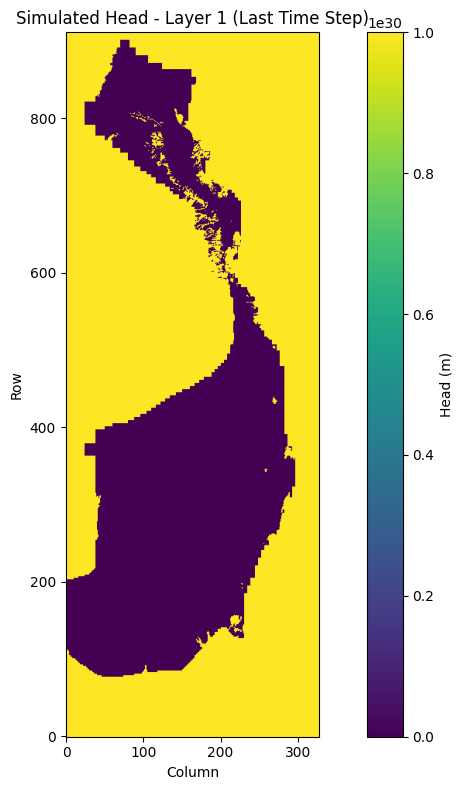

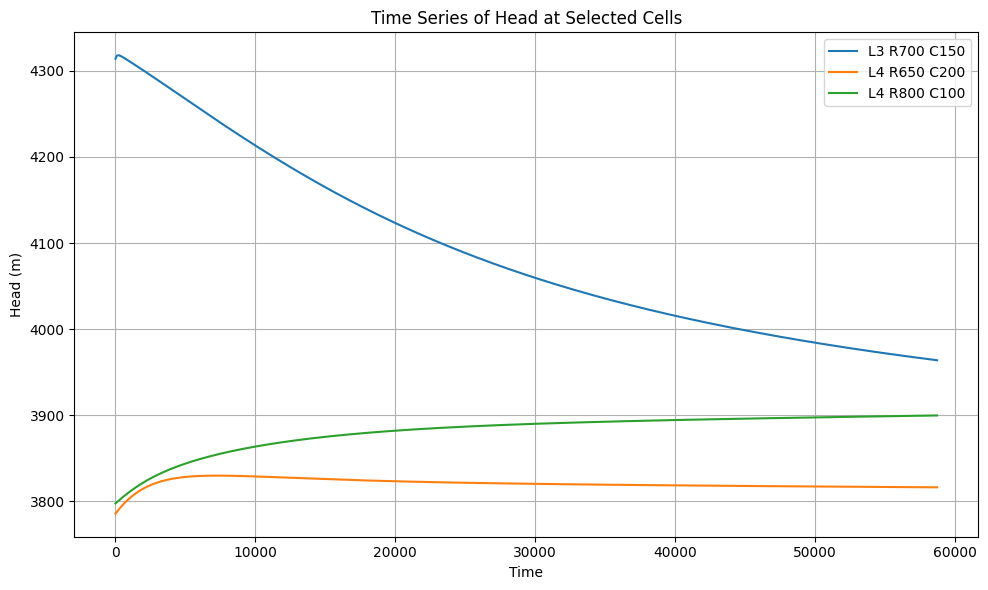

In [4]:
plt.figure(figsize=(10, 8))
plt.imshow(head[3], cmap='viridis', origin='lower')
plt.colorbar(label='Head (m)')
plt.title('Simulated Head - Layer 1 (Last Time Step)')
plt.xlabel('Column')
plt.ylabel('Row')
plt.tight_layout()
plt.show()# editable list of (layer, row, col) tuples
cell_indices = [(3, 700, 150), (4, 650, 200), (4, 800, 100)]  # example cells

plt.figure(figsize=(10, 6))

for layer, row, col in cell_indices:
    ts = [headobj.get_data(totim=t)[layer, row, col] for t in head_times]
    plt.plot(head_times, ts, label=f'L{layer} R{row} C{col}')

plt.xlabel('Time')
plt.ylabel('Head (m)')
plt.title('Time Series of Head at Selected Cells')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


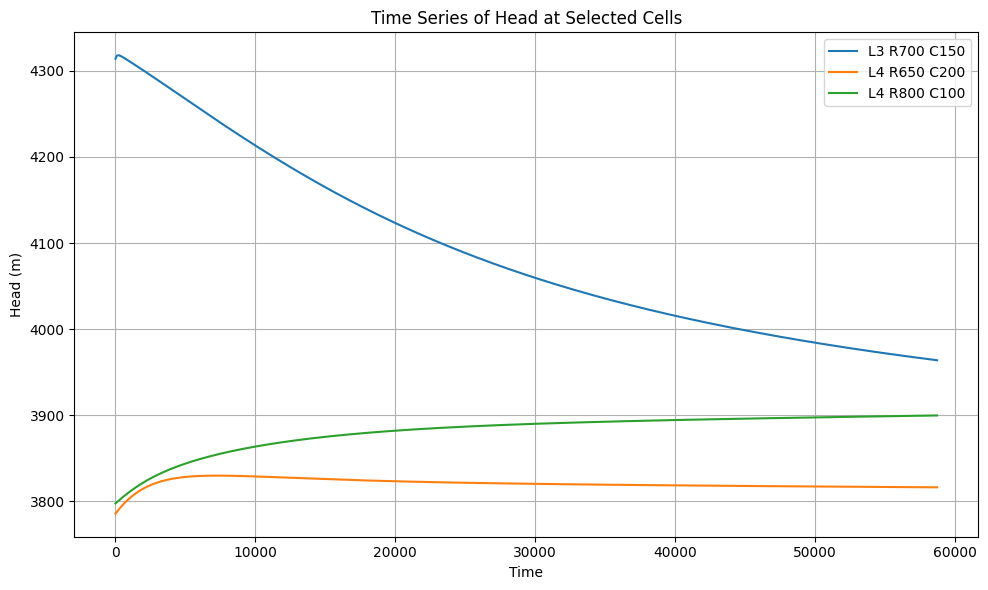

In [5]:
# editable list of (layer, row, col) tuples
cell_indices = [(3, 700, 150), (4, 650, 200), (4, 800, 100)]  # example cells

plt.figure(figsize=(10, 6))

for layer, row, col in cell_indices:
    ts = [headobj.get_data(totim=t)[layer, row, col] for t in head_times]
    plt.plot(head_times, ts, label=f'L{layer} R{row} C{col}')

plt.xlabel('Time')
plt.ylabel('Head (m)')
plt.title('Time Series of Head at Selected Cells')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Head data range (SP 10, before filtering, in feet):
Min: 966.22, Max: 1000000000000000019884624838656.00
Head data range (SP 898, before filtering, in feet):
Min: 993.12, Max: 1000000000000000019884624838656.00
L1: Active cells (idomain=1): 17879/299136
L2: Active cells (idomain=1): 17879/299136
L3: Active cells (idomain=1): 107959/299136
L4: Active cells (idomain=1): 107959/299136
L5: Active cells (idomain=1): 110244/299136
L6: Active cells (idomain=1): 110244/299136
L7: Active cells (idomain=1): 110573/299136
L8: Active cells (idomain=1): 110573/299136
L9: Active cells (idomain=1): 112576/299136

Head data range (SP 10, after filtering, in meters):
L1: Min: 1146.05, Max: 1219.29
L2: Min: 1112.62, Max: 1277.51
L3: Min: 1083.26, Max: 1590.45
L4: Min: 934.97, Max: 1586.94
L5: Min: 820.22, Max: 1586.03
L6: Min: 671.02, Max: 1585.26
L7: Min: 547.57, Max: 1584.50
L8: Min: 449.58, Max: 1583.74
L9: Min: 294.50, Max: 1669.08
Head data range (SP 898, after filtering, in meters):
L1: Min: 1132.

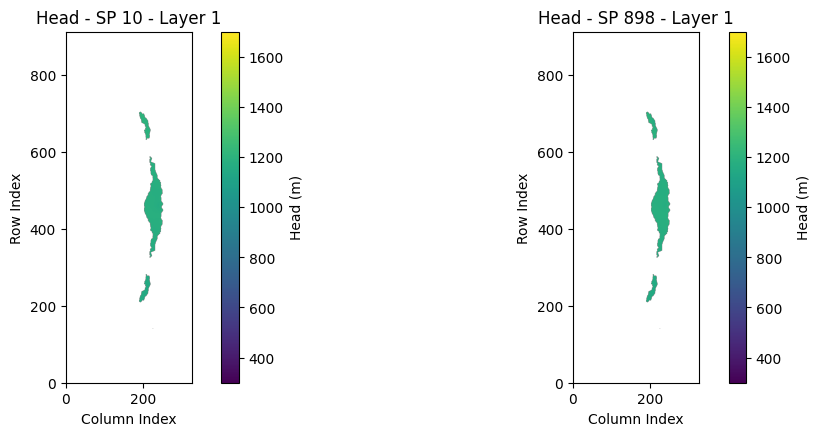

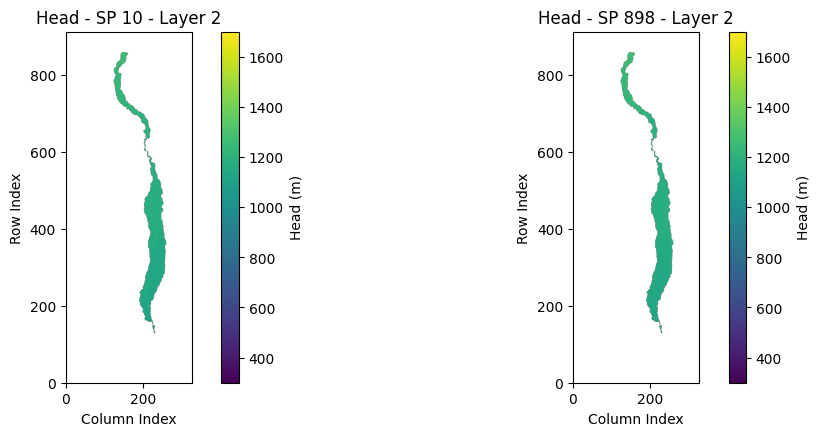

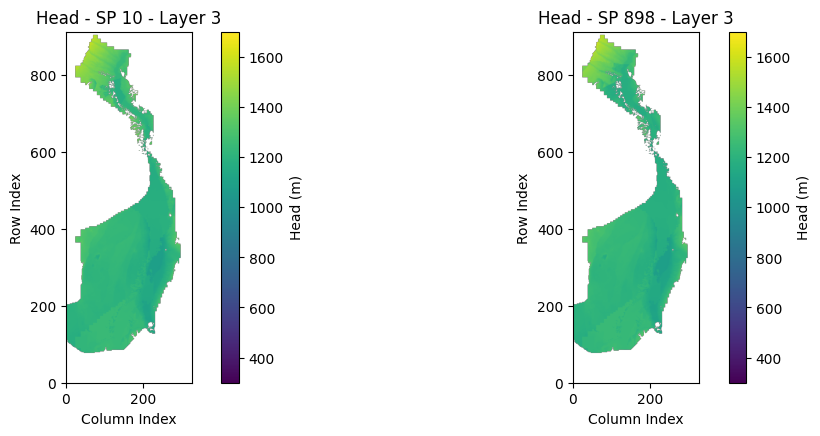

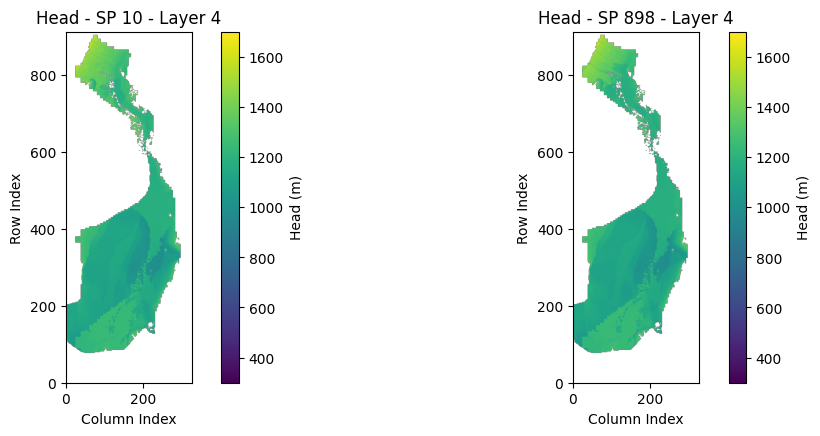

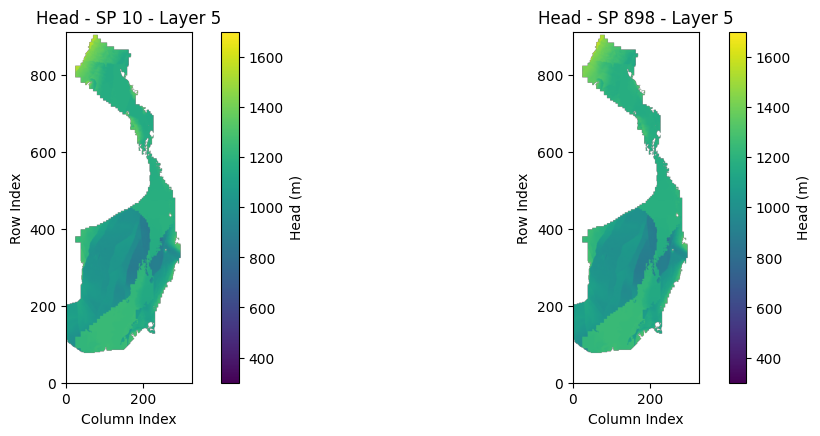

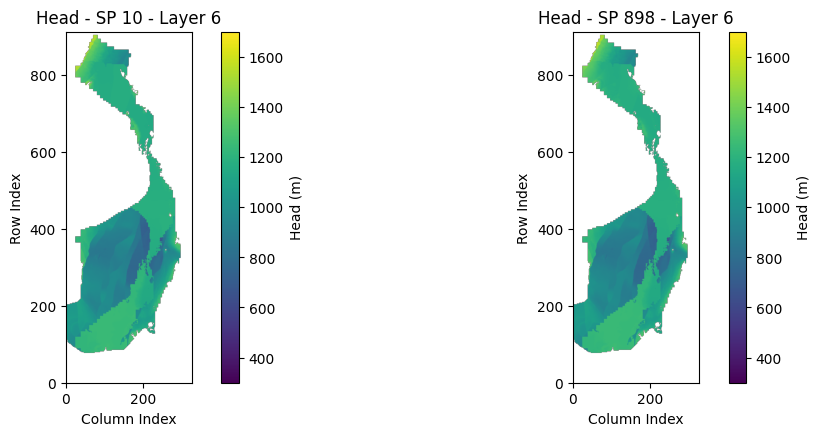

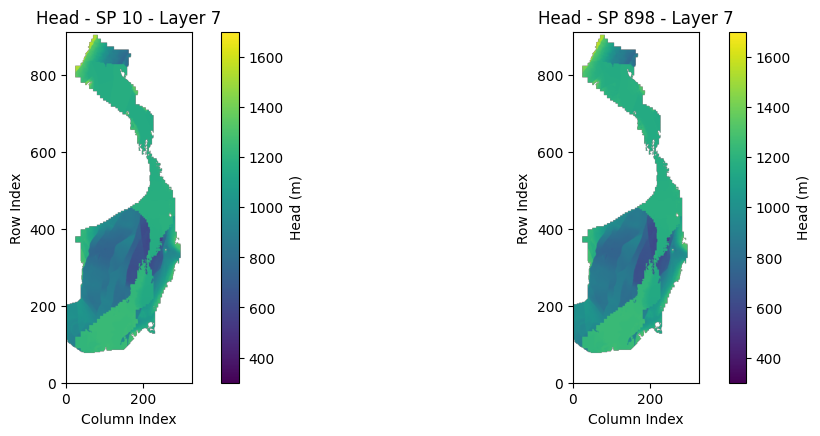

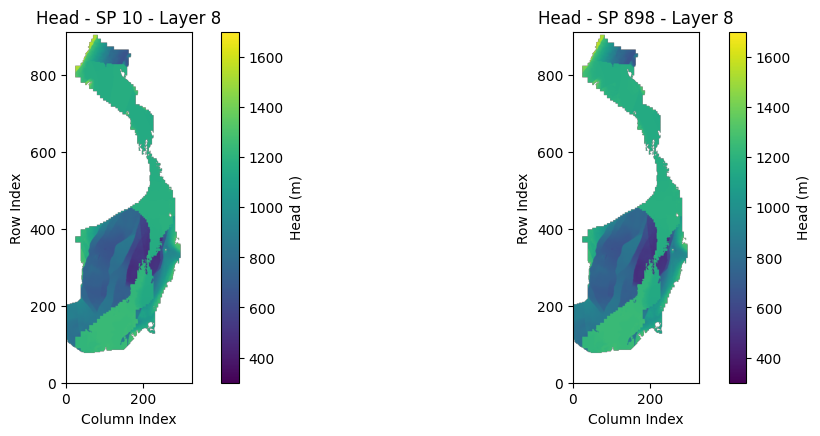

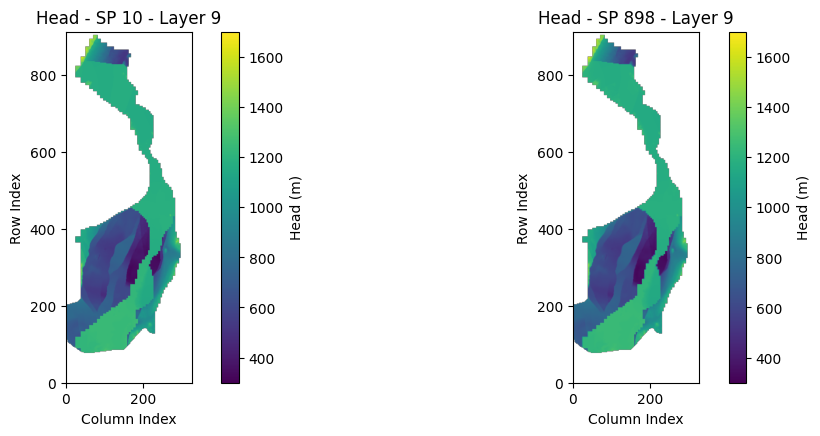

/tmp/ipykernel_18310/320758467.py:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", nlay)


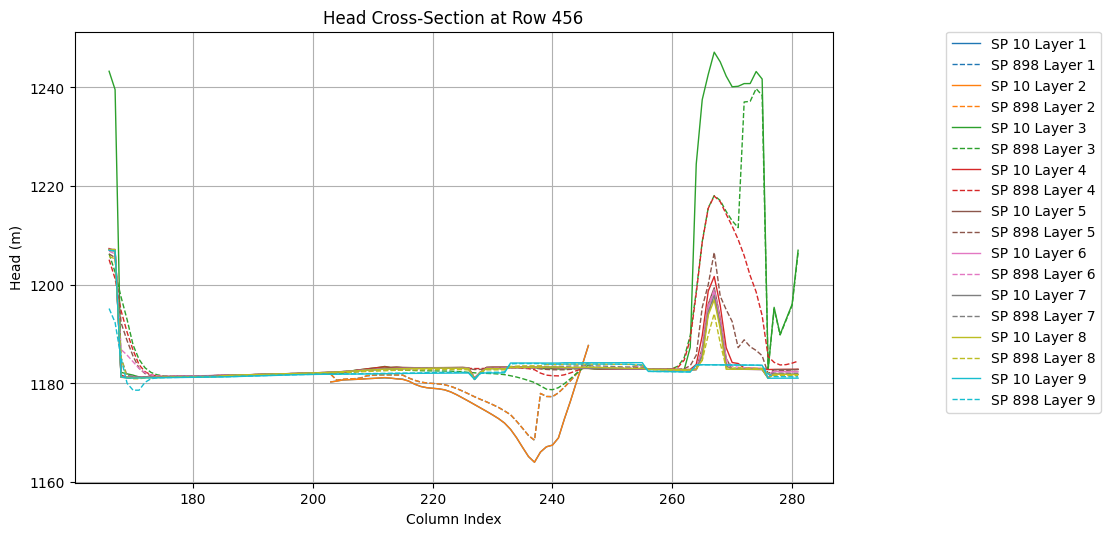

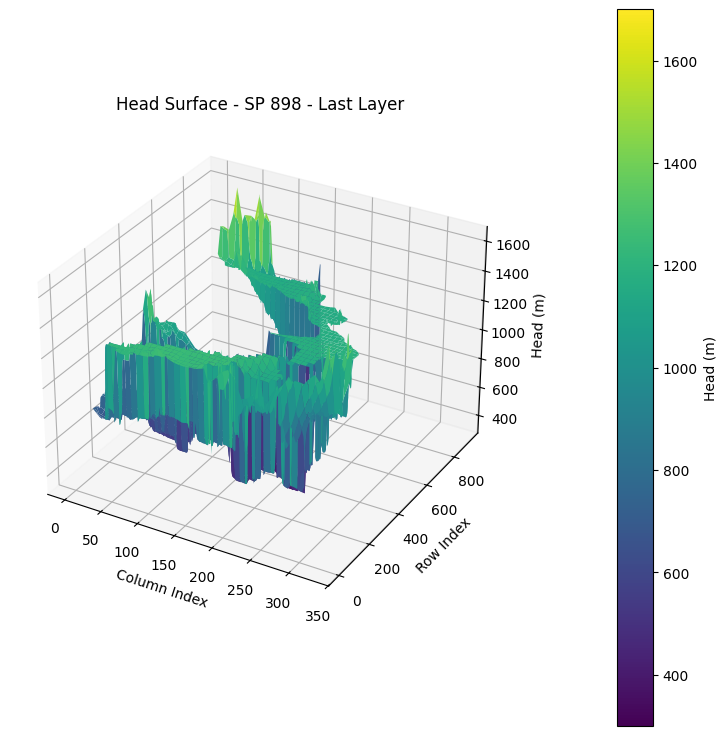

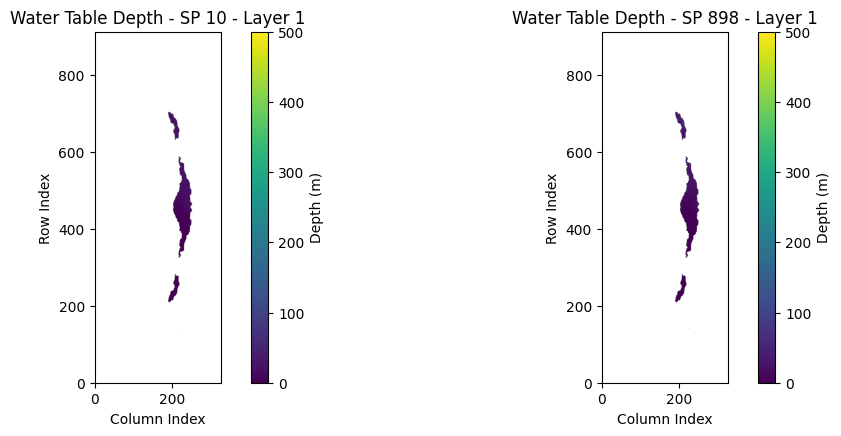

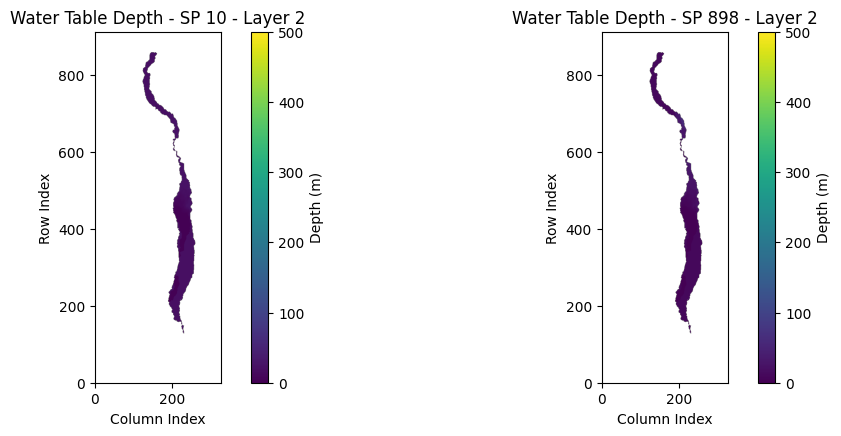

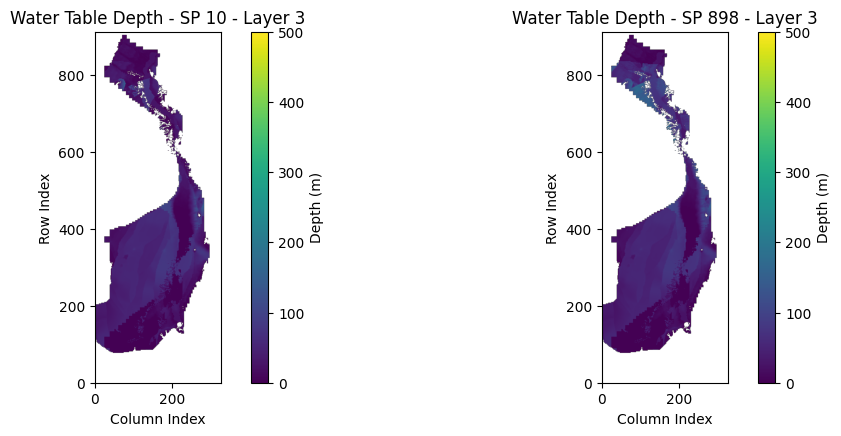

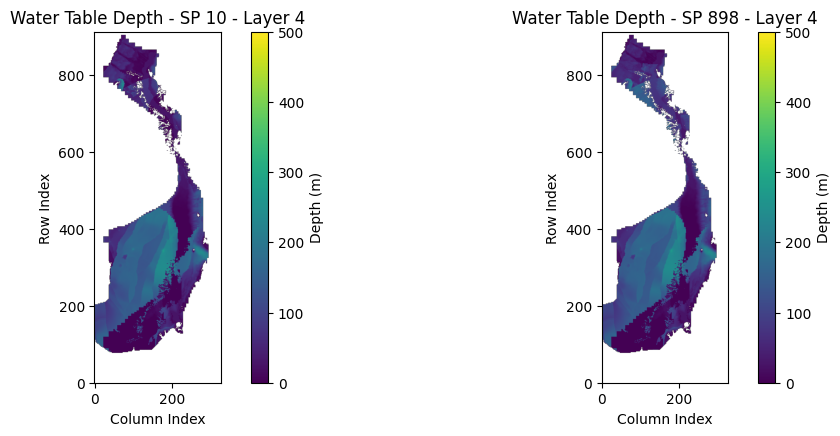

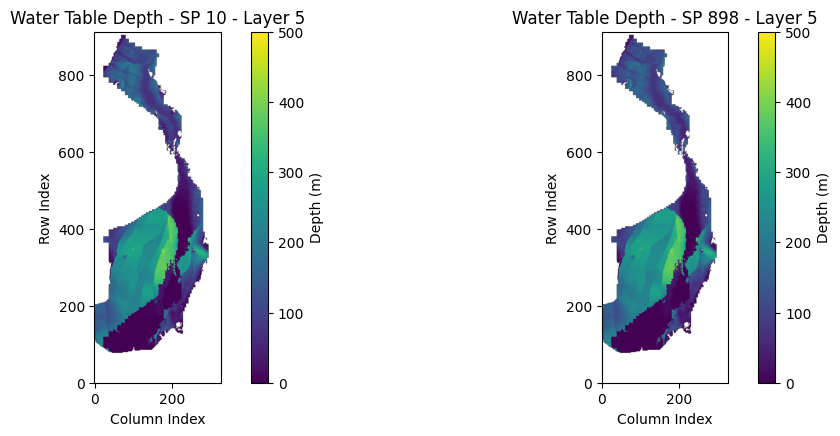

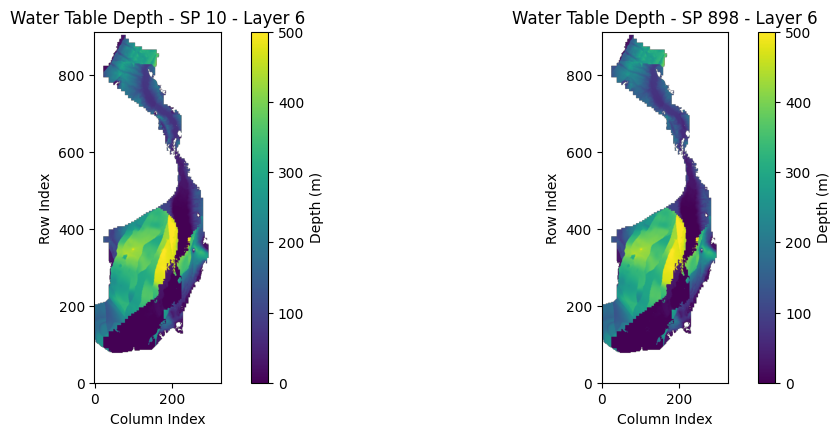

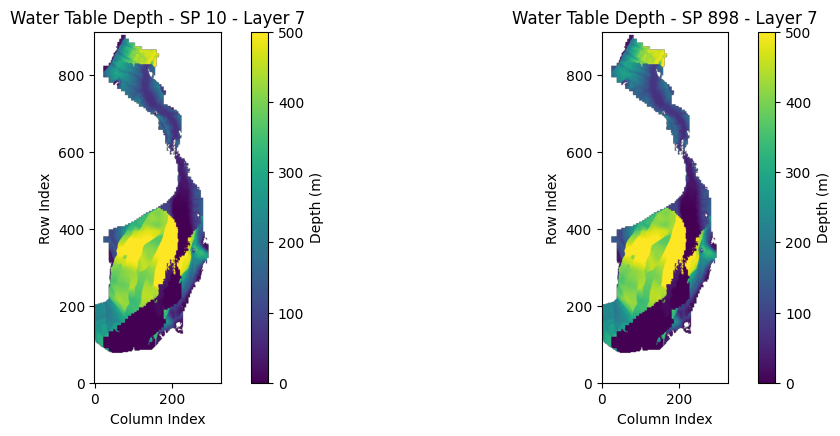

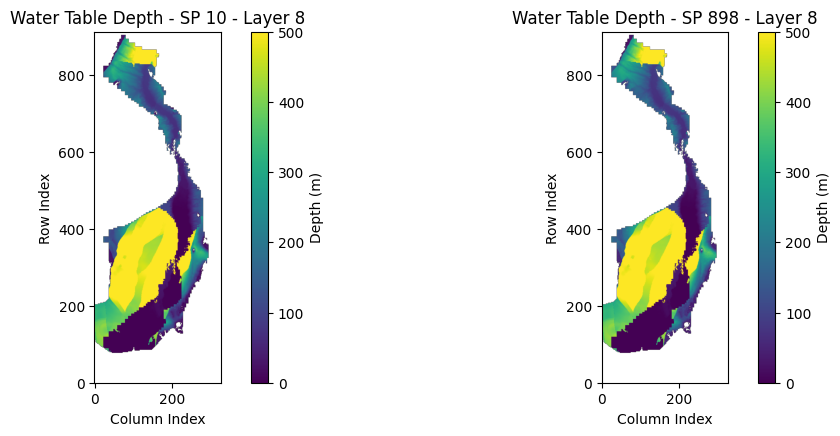

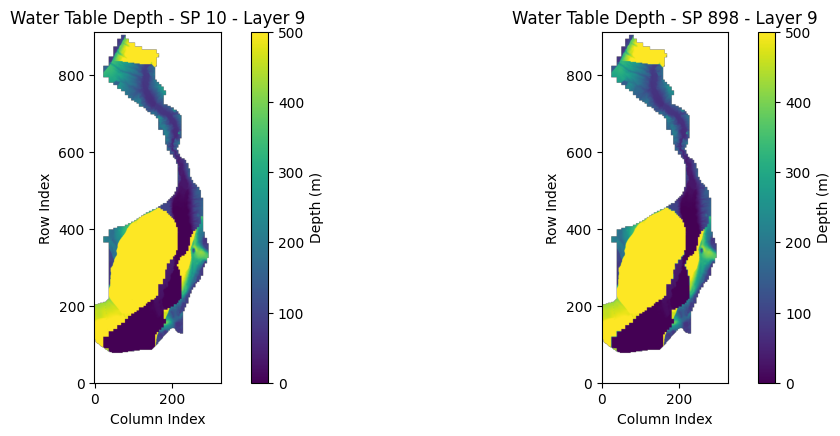

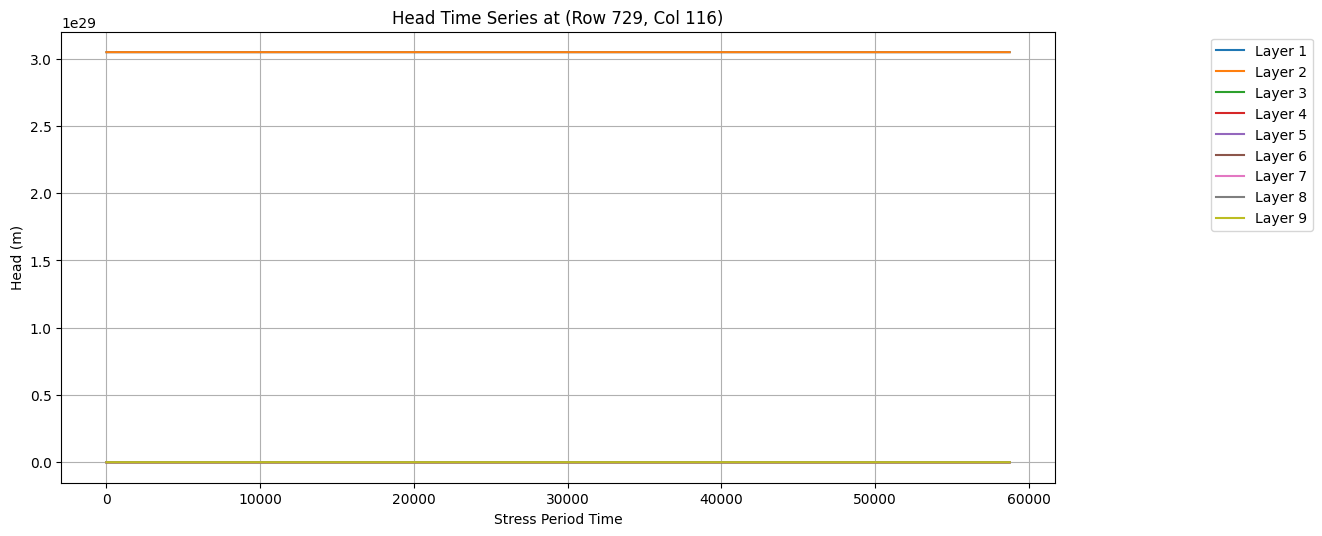

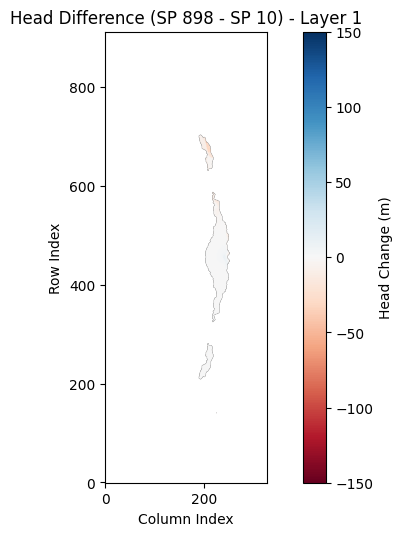

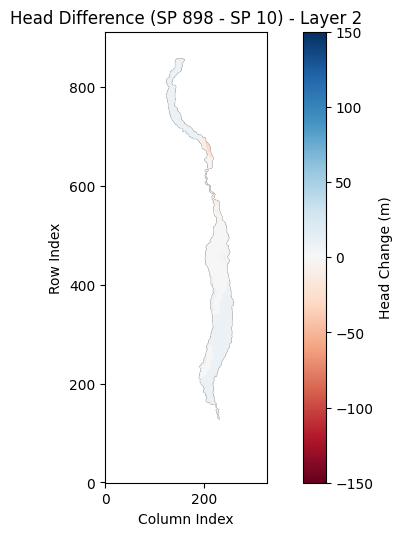

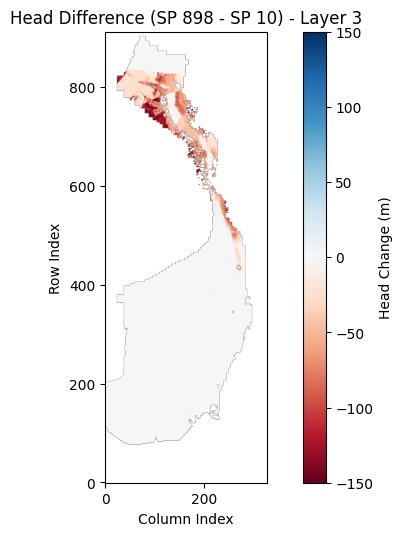

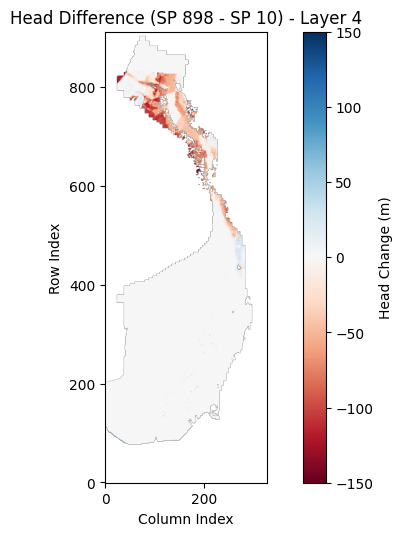

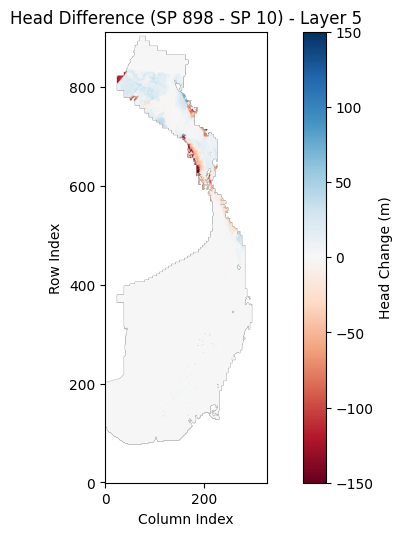

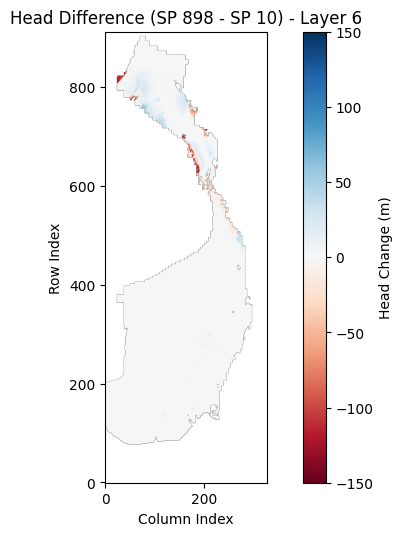

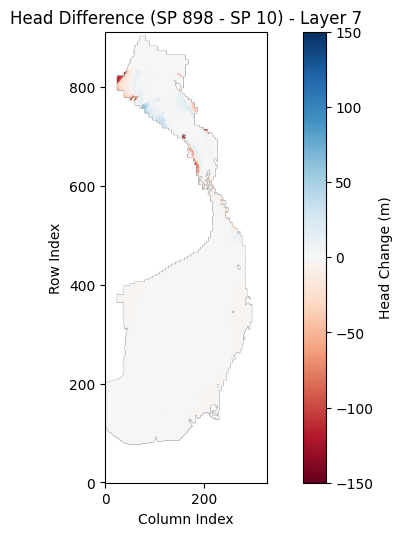

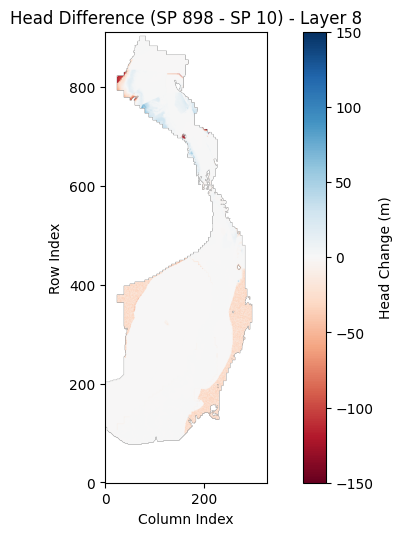

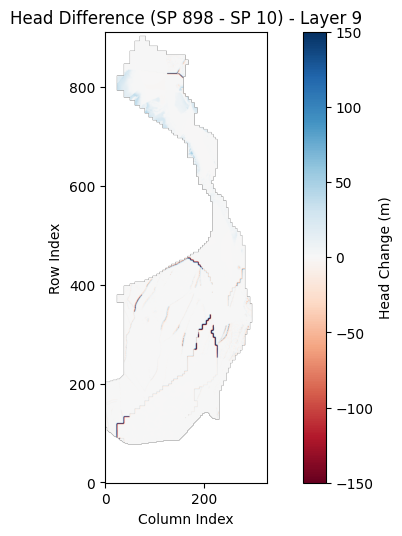

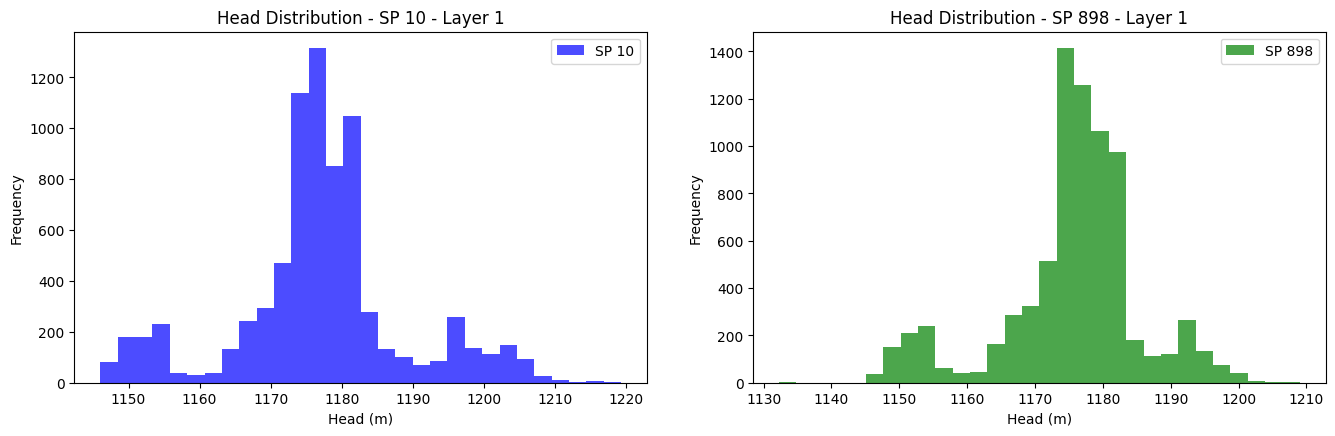

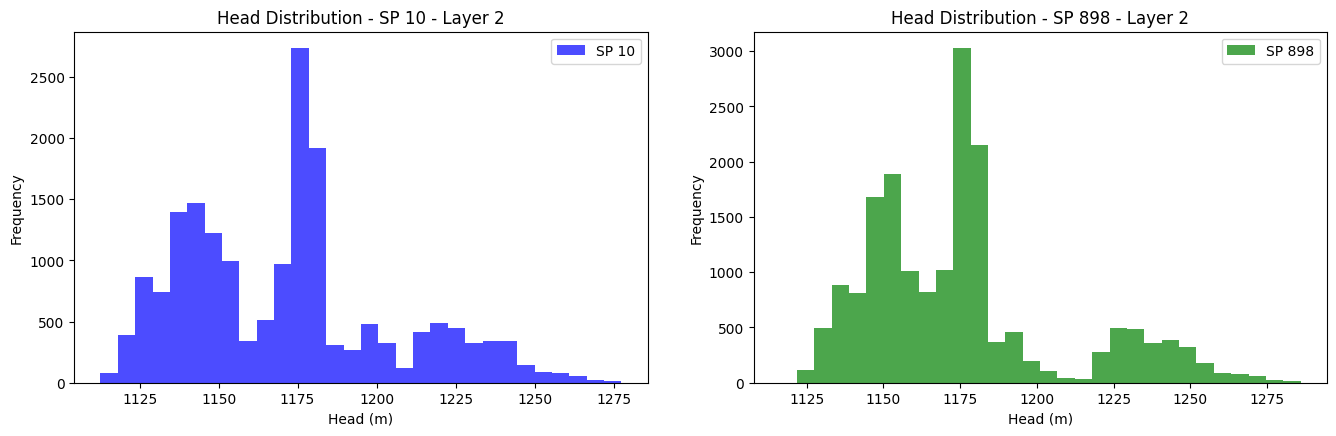

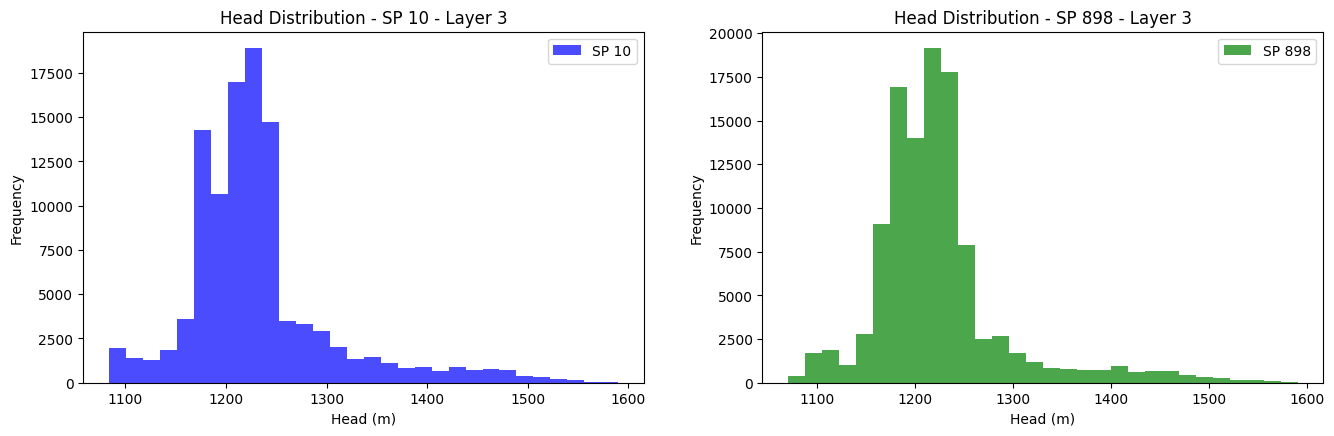

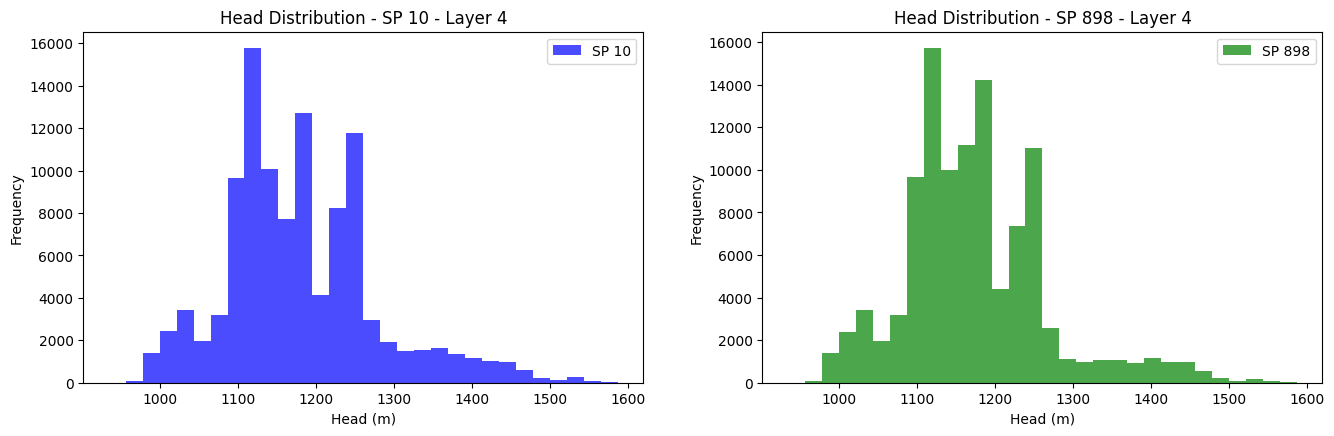

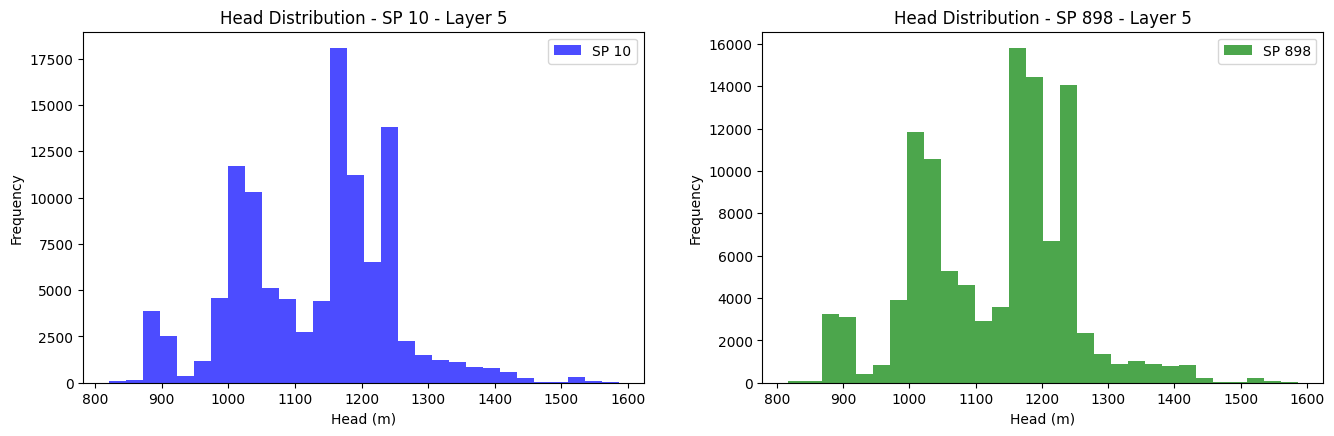

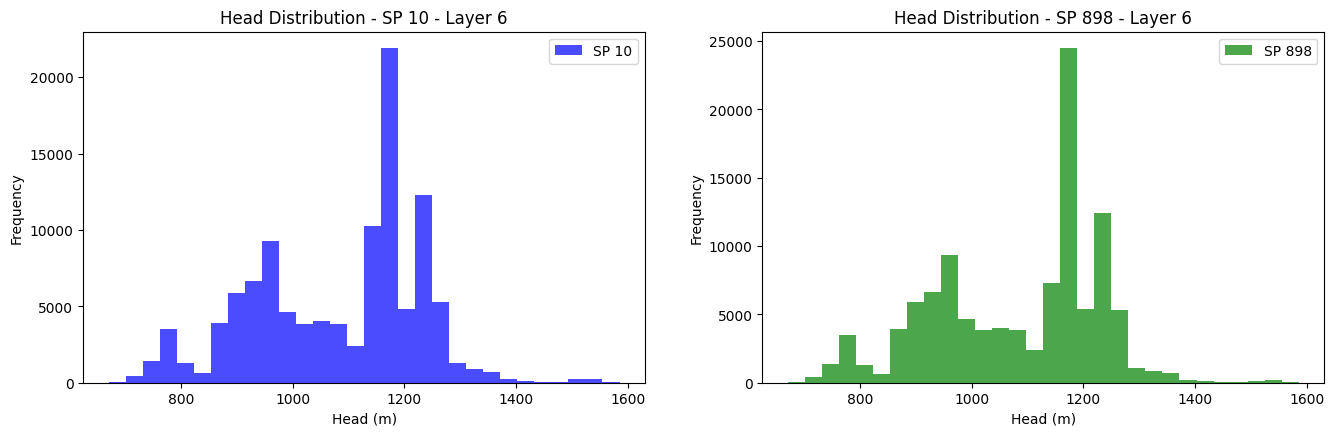

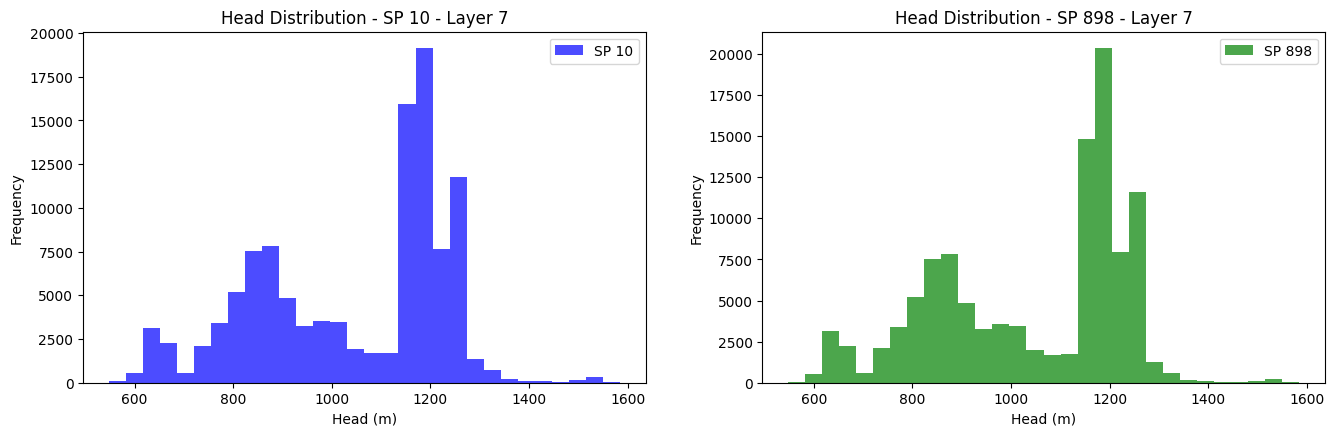

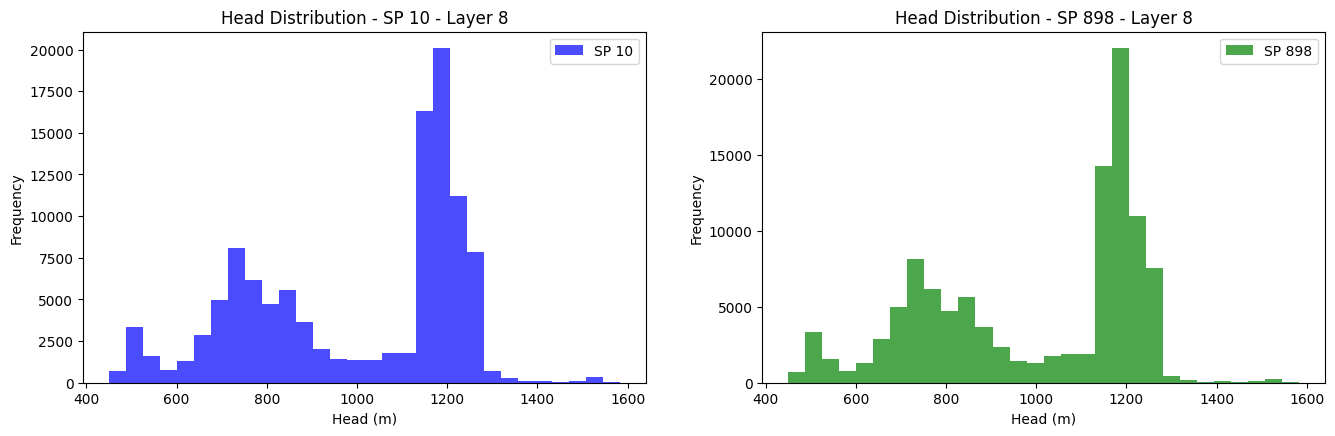

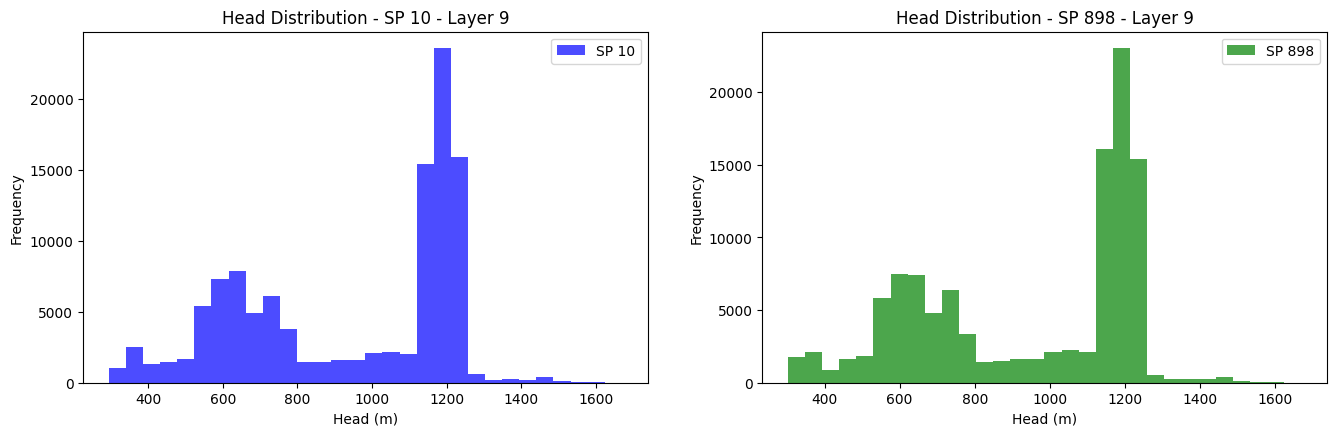

/tmp/ipykernel_18310/320758467.py:347: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(head_sp10_list, positions=np.arange(1, nlay+1)-0.2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.7), labels=[f"Layer {k+1}" for k in range(nlay)])


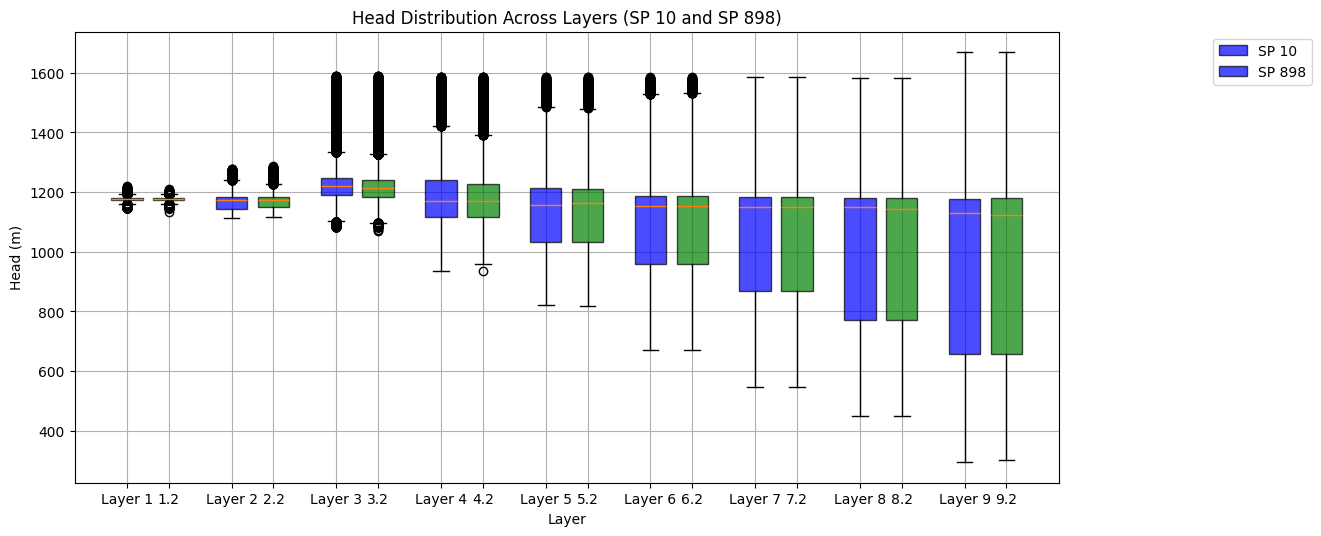

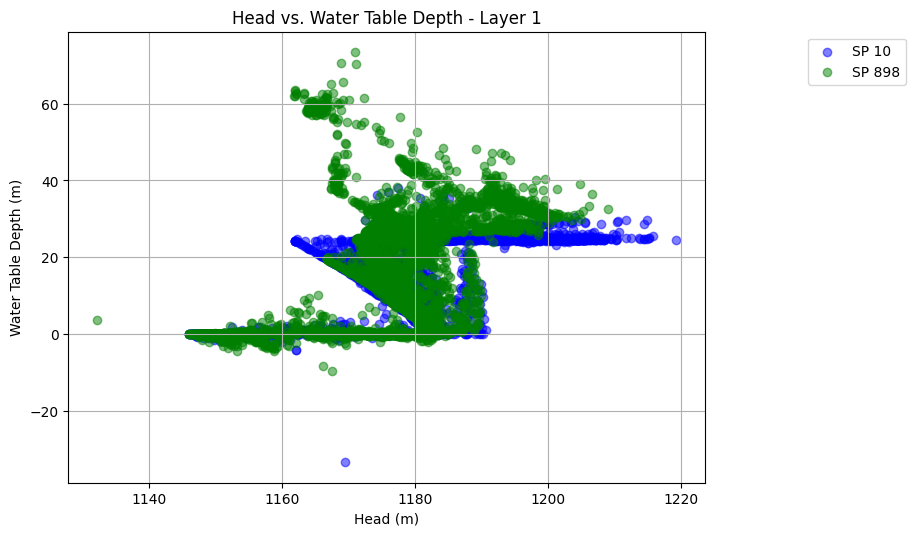

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.cm as cm  # Import colormap module

# Flag to control plot display (set to False in non-interactive environments)
DISPLAY_PLOTS = True

# Check if required objects are defined
try:
    gwf
    headobj
except NameError:
    raise NameError("Required objects 'gwf' and 'headobj' must be defined (e.g., from a MODFLOW model).")

# Create plots subdirectory if it doesn't exist
plots_dir = "plots"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Grid dimensions from the model
nlay = gwf.dis.nlay.get_data()
nrow = gwf.dis.nrow.get_data()
ncol = gwf.dis.ncol.get_data()
delr = gwf.dis.delr.get_data()
delc = gwf.dis.delc.get_data()
idomain = gwf.dis.idomain.get_data()

# Validate grid dimensions
if nlay <= 0 or nrow <= 0 or ncol <= 0:
    raise ValueError(f"Invalid grid dimensions: nlay={nlay}, nrow={nrow}, ncol={ncol}")

# Load top elevation from gwf
top_elev = gwf.dis.top.get_data()  # 2D array in feet
top_elev_m = top_elev * 0.3048  # Convert to meters

# Create coordinate arrays for plotting (using indices, matching head data shape)
x = np.arange(ncol)
y = np.arange(nrow)
X, Y = np.meshgrid(x, y)  # Shape (nrow, ncol) to match head data

# Load head data for Stress Period 10 and 898 (December 2014)
head_times = headobj.get_times()
if len(head_times) < 898:
    raise ValueError(f"headobj has only {len(head_times)} stress periods, need at least 898.")
sp10_time = head_times[9]  # SP 10 is index 9 (0-based)
sp898_time = head_times[897]  # SP 898 is index 897
head_sp10 = headobj.get_data(totim=sp10_time)
head_sp898 = headobj.get_data(totim=sp898_time)

# Ensure head arrays are 3D (nlay, nrow, ncol)
for head in [head_sp10, head_sp898]:
    if head.ndim == 2:
        head = head[np.newaxis, :, :]
    elif head.ndim != 3:
        raise ValueError(f"Unexpected head array shape: {head.shape}")

# Adjust nlay if head has fewer layers
if head_sp10.shape[0] != nlay or head_sp898.shape[0] != nlay:
    print(f"Warning: head has {head_sp10.shape[0]} layers, but model expects {nlay}. Adjusting nlay.")
    nlay = min(head_sp10.shape[0], head_sp898.shape[0])

# Filter extreme head values (threshold in feet)
head_filtered_sp10 = np.copy(head_sp10)
head_filtered_sp898 = np.copy(head_sp898)
threshold_feet = 10000  # Threshold in feet
for k in range(nlay):
    head_filtered_sp10[k][np.abs(head_sp10[k]) > threshold_feet] = np.nan
    head_filtered_sp10[k][idomain[k] == 0] = np.nan
    head_filtered_sp898[k][np.abs(head_sp898[k]) > threshold_feet] = np.nan
    head_filtered_sp898[k][idomain[k] == 0] = np.nan

# Convert filtered head to meters for plotting
head_filtered_sp10_m = head_filtered_sp10 * 0.3048
head_filtered_sp898_m = head_filtered_sp898 * 0.3048

# Calculate water table depth (top - head) for SP 10 and SP 898
# Ensure top_elev_m is broadcastable to 3D
if top_elev_m.shape != head_filtered_sp10_m.shape[1:]:
    raise ValueError(f"top_elev_m shape {top_elev_m.shape} incompatible with head shape {head_filtered_sp10_m.shape[1:]}")
wt_depth_sp10_m = top_elev_m[np.newaxis, :, :] - head_filtered_sp10_m
wt_depth_sp898_m = top_elev_m[np.newaxis, :, :] - head_filtered_sp898_m

# Diagnostic checks and statistics
print("Head data range (SP 10, before filtering, in feet):")
print(f"Min: {np.nanmin(head_sp10):.2f}, Max: {np.nanmax(head_sp10):.2f}")
print("Head data range (SP 898, before filtering, in feet):")
print(f"Min: {np.nanmin(head_sp898):.2f}, Max: {np.nanmax(head_sp898):.2f}")
for k in range(nlay):
    active_cells = np.sum(idomain[k] == 1)
    total_cells = nrow * ncol
    print(f"L{k+1}: Active cells (idomain=1): {active_cells}/{total_cells}")

print("\nHead data range (SP 10, after filtering, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(head_filtered_sp10_m[k])
    layer_max = np.nanmax(head_filtered_sp10_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")
print("Head data range (SP 898, after filtering, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(head_filtered_sp898_m[k])
    layer_max = np.nanmax(head_filtered_sp898_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")

print("\nWater Table Depth range (SP 10, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(wt_depth_sp10_m[k])
    layer_max = np.nanmax(wt_depth_sp10_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")
print("Water Table Depth range (SP 898, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(wt_depth_sp898_m[k])
    layer_max = np.nanmax(wt_depth_sp898_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")

# Additional Statistics
# 1. Basic Statistics per Layer
print("\nBasic Statistics (SP 10 Heads, in meters):")
for k in range(nlay):
    data = head_filtered_sp10_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

print("\nBasic Statistics (SP 898 Heads, in meters):")
for k in range(nlay):
    data = head_filtered_sp898_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

print("\nBasic Statistics (SP 10 Water Table Depth, in meters):")
for k in range(nlay):
    data = wt_depth_sp10_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

print("\nBasic Statistics (SP 898 Water Table Depth, in meters):")
for k in range(nlay):
    data = wt_depth_sp898_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

# 2. Change Statistics (SP 898 - SP 10)
print("\nHead Change Statistics (SP 898 - SP 10, in meters):")
for k in range(nlay):
    head_diff = head_filtered_sp898_m[k] - head_filtered_sp10_m[k]
    data = head_diff.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean Change: {np.mean(data):.2f}, Median Change: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        increased = np.sum(data > 0) / len(data) * 100
        decreased = np.sum(data < 0) / len(data) * 100
        print(f"        % Increased: {increased:.2f}%, % Decreased: {decreased:.2f}%")

# 3. Correlation Analysis
print("\nCorrelation between Head and Water Table Depth:")
for k in range(nlay):
    head_sp10 = head_filtered_sp10_m[k].flatten()
    wt_sp10 = wt_depth_sp10_m[k].flatten()
    head_sp898 = head_filtered_sp898_m[k].flatten()
    wt_sp898 = wt_depth_sp898_m[k].flatten()
    
    mask_sp10 = ~np.isnan(head_sp10) & ~np.isnan(wt_sp10)
    mask_sp898 = ~np.isnan(head_sp898) & ~np.isnan(wt_sp898)
    
    if np.sum(mask_sp10) > 0:
        corr_sp10, _ = pearsonr(head_sp10[mask_sp10], wt_sp10[mask_sp10])
        print(f"L{k+1} (SP 10): Correlation Head vs WT Depth: {corr_sp10:.3f}")
    if np.sum(mask_sp898) > 0:
        corr_sp898, _ = pearsonr(head_sp898[mask_sp898], wt_sp898[mask_sp898])
        print(f"L{k+1} (SP 898): Correlation Head vs WT Depth: {corr_sp898:.3f}")

# Plot 1: Heatmaps for each layer for SP 10 and SP 898
for k in range(nlay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # SP 10 Heatmap
    im1 = ax1.imshow(head_filtered_sp10_m[k], cmap="viridis", vmin=300, vmax=1700, origin='lower')
    ax1.set_title(f"Head - SP 10 - Layer {k+1}")
    ax1.set_xlabel("Column Index")
    ax1.set_ylabel("Row Index")
    plt.colorbar(im1, ax=ax1, label="Head (m)")
    
    # SP 898 Heatmap
    im2 = ax2.imshow(head_filtered_sp898_m[k], cmap="viridis", vmin=300, vmax=1700, origin='lower')
    ax2.set_title(f"Head - SP 898 - Layer {k+1}")
    ax2.set_xlabel("Column Index")
    ax2.set_ylabel("Row Index")
    plt.colorbar(im2, ax=ax2, label="Head (m)")
    
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"head_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 2: Cross-sectional view (along the middle row) for SP 10 and SP 898
row_idx = nrow // 2
if row_idx >= nrow:
    raise ValueError(f"Invalid row_idx {row_idx} for nrow {nrow}")
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
colors = cm.get_cmap("tab10", nlay)

for k in range(nlay):
    color = colors(k)
    ax.plot(x, head_filtered_sp10_m[k, row_idx, :], label=f"SP 10 Layer {k+1}", color=color, linewidth=1.0)
    ax.plot(x, head_filtered_sp898_m[k, row_idx, :], '--', label=f"SP 898 Layer {k+1}", color=color, linewidth=1.0)

ax.set_title(f"Head Cross-Section at Row {row_idx}")
ax.set_xlabel("Column Index")
ax.set_ylabel("Head (m)")
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
ax.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_cross_section.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 3: 3D Surface plot for the last layer of SP 898
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")
surf_sp898 = ax.plot_surface(X, Y, head_filtered_sp898_m[-1], cmap="viridis", vmin=300, vmax=1700)
ax.set_title("Head Surface - SP 898 - Last Layer")
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_zlabel("Head (m)")
fig.colorbar(surf_sp898, ax=ax, label="Head (m)", pad=0.15)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_surface.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 4: Water Table Depth Heatmaps for each layer for SP 10 and SP 898
for k in range(nlay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # SP 10 Water Table Depth Heatmap
    im1 = ax1.imshow(wt_depth_sp10_m[k], cmap="viridis", vmin=0, vmax=500, origin='lower')
    ax1.set_title(f"Water Table Depth - SP 10 - Layer {k+1}")
    ax1.set_xlabel("Column Index")
    ax1.set_ylabel("Row Index")
    plt.colorbar(im1, ax=ax1, label="Depth (m)")
    
    # SP 898 Water Table Depth Heatmap
    im2 = ax2.imshow(wt_depth_sp898_m[k], cmap="viridis", vmin=0, vmax=500, origin='lower')
    ax2.set_title(f"Water Table Depth - SP 898 - Layer {k+1}")
    ax2.set_xlabel("Column Index")
    ax2.set_ylabel("Row Index")
    plt.colorbar(im2, ax=ax2, label="Depth (m)")
    
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"wt_depth_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 5: Time Series Plot for Specific Cells
row, col = 729, 116
if row >= nrow or col >= ncol:
    raise ValueError(f"Invalid cell coordinates (row={row}, col={col}) for grid (nrow={nrow}, ncol={ncol})")
if np.any(idomain[:, row, col] == 0):
    print(f"Warning: Cell (row={row}, col={col}) is inactive in some layers (idomain=0)")
head_times_series = []
for t in head_times:
    head_data = headobj.get_data(totim=t)
    if head_data.ndim == 2:
        head_data = head_data[np.newaxis, :, :]
    head_data_m = head_data * 0.3048
    head_times_series.append(head_data_m[:, row, col])

head_times_series = np.array(head_times_series)  # Shape (n_times, nlay)
fig = plt.figure(figsize=(14, 6))
for k in range(nlay):
    plt.plot(head_times, head_times_series[:, k], label=f"Layer {k+1}")
plt.title(f"Head Time Series at (Row {row}, Col {col})")
plt.xlabel("Stress Period Time")
plt.ylabel("Head (m)")
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_time_series.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 6: Head Difference Heatmaps (SP 898 - SP 10)
for k in range(nlay):
    head_diff = head_filtered_sp898_m[k] - head_filtered_sp10_m[k]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(head_diff, cmap="RdBu", vmin=-150, vmax=150, origin='lower')
    ax.set_title(f"Head Difference (SP 898 - SP 10) - Layer {k+1}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.colorbar(im, ax=ax, label="Head Change (m)")
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"head_diff_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 7: Histogram of Head Values per Layer
for k in range(nlay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # SP 10 Histogram
    data_sp10 = head_filtered_sp10_m[k].flatten()
    data_sp10 = data_sp10[~np.isnan(data_sp10)]
    ax1.hist(data_sp10, bins=30, color='blue', alpha=0.7, label='SP 10')
    ax1.set_title(f"Head Distribution - SP 10 - Layer {k+1}")
    ax1.set_xlabel("Head (m)")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    
    # SP 898 Histogram
    data_sp898 = head_filtered_sp898_m[k].flatten()
    data_sp898 = data_sp898[~np.isnan(data_sp898)]
    ax2.hist(data_sp898, bins=30, color='green', alpha=0.7, label='SP 898')
    ax2.set_title(f"Head Distribution - SP 898 - Layer {k+1}")
    ax2.set_xlabel("Head (m)")
    ax2.set_ylabel("Frequency")
    ax2.legend()
    
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"head_histogram_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 8: Box Plot of Head Across Layers
fig = plt.figure(figsize=(14, 6))
head_sp10_list = [head_filtered_sp10_m[k].flatten()[~np.isnan(head_filtered_sp10_m[k].flatten())] for k in range(nlay)]
head_sp898_list = [head_filtered_sp898_m[k].flatten()[~np.isnan(head_filtered_sp898_m[k].flatten())] for k in range(nlay)]
plt.boxplot(head_sp10_list, positions=np.arange(1, nlay+1)-0.2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.7), labels=[f"Layer {k+1}" for k in range(nlay)])
plt.boxplot(head_sp898_list, positions=np.arange(1, nlay+1)+0.2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='green', alpha=0.7))
plt.title("Head Distribution Across Layers (SP 10 and SP 898)")
plt.xlabel("Layer")
plt.ylabel("Head (m)")
plt.legend(['SP 10', 'SP 898'], bbox_to_anchor=(1.15, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_boxplot.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 9: Scatter Plot of Head vs. Water Table Depth (for Layer 1)
k = 0  # Layer 1
head_sp10_flat = head_filtered_sp10_m[k].flatten()
wt_sp10_flat = wt_depth_sp10_m[k].flatten()
mask = ~np.isnan(head_sp10_flat) & ~np.isnan(wt_sp10_flat)
fig = plt.figure(figsize=(10, 6))
plt.scatter(head_sp10_flat[mask], wt_sp10_flat[mask], color='blue', alpha=0.5, label='SP 10')
head_sp898_flat = head_filtered_sp898_m[k].flatten()
wt_sp898_flat = wt_depth_sp898_m[k].flatten()
mask = ~np.isnan(head_sp898_flat) & ~np.isnan(wt_sp898_flat)
plt.scatter(head_sp898_flat[mask], wt_sp898_flat[mask], color='green', alpha=0.5, label='SP 898')
plt.title(f"Head vs. Water Table Depth - Layer 1")
plt.xlabel("Head (m)")
plt.ylabel("Water Table Depth (m)")
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_vs_wt_depth_layer1.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

/tmp/ipykernel_18310/4032409167.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0, rect=[0, 0, 0.8, 1])  # Adjust rect to accommodate colorbar


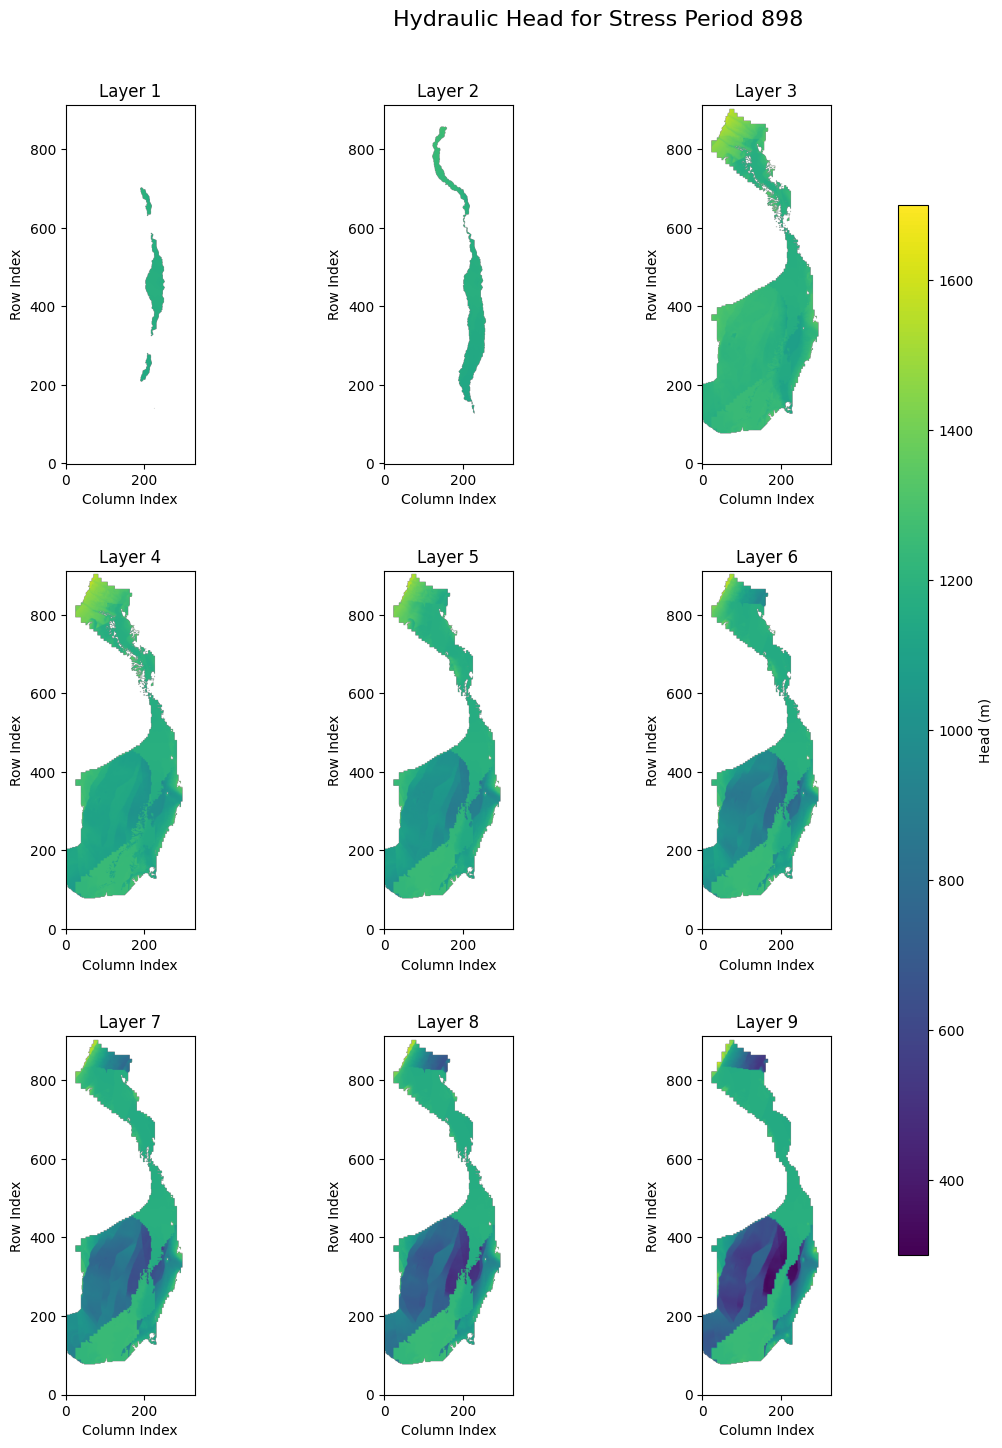

In [7]:
# Create a single figure with all SP 898 head heatmaps for all layers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 heatmaps (9 layers for SP 898)
axes = axes.flatten()  # Flatten for easier indexing

fig.suptitle("Hydraulic Head for Stress Period 898", fontsize=16)

# Plot SP 898 heatmaps for all layers
for k in range(nlay):
    ax = axes[k]
    im = ax.imshow(head_filtered_sp898_m[k], cmap="viridis", vmin=300, vmax=1700, origin='lower')
    ax.set_title(f"Layer {k+1}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.set_aspect('equal')  # Ensure square aspect for each heatmap

# Add a shared colorbar (moved closer)
plt.subplots_adjust(left=0.05, right=0.88, wspace=0.1, hspace=0.1)  # Reduce right margin to bring colorbar closer
cbar_ax = fig.add_axes([0.7, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
plt.colorbar(im, cax=cbar_ax, label="Head (m)")

# Ensure full extent with buffer
plt.tight_layout(pad=3.0, rect=[0, 0, 0.8, 1])  # Adjust rect to accommodate colorbar

# Save and show
plt.savefig(os.path.join(plots_dir, "all_sp898_hydraulic_head_heatmaps.png"))
plt.show()
plt.close()

/tmp/ipykernel_18310/2290118612.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0, rect=[0, 0, 0.88, 1])  # Adjust rect to accommodate colorbar


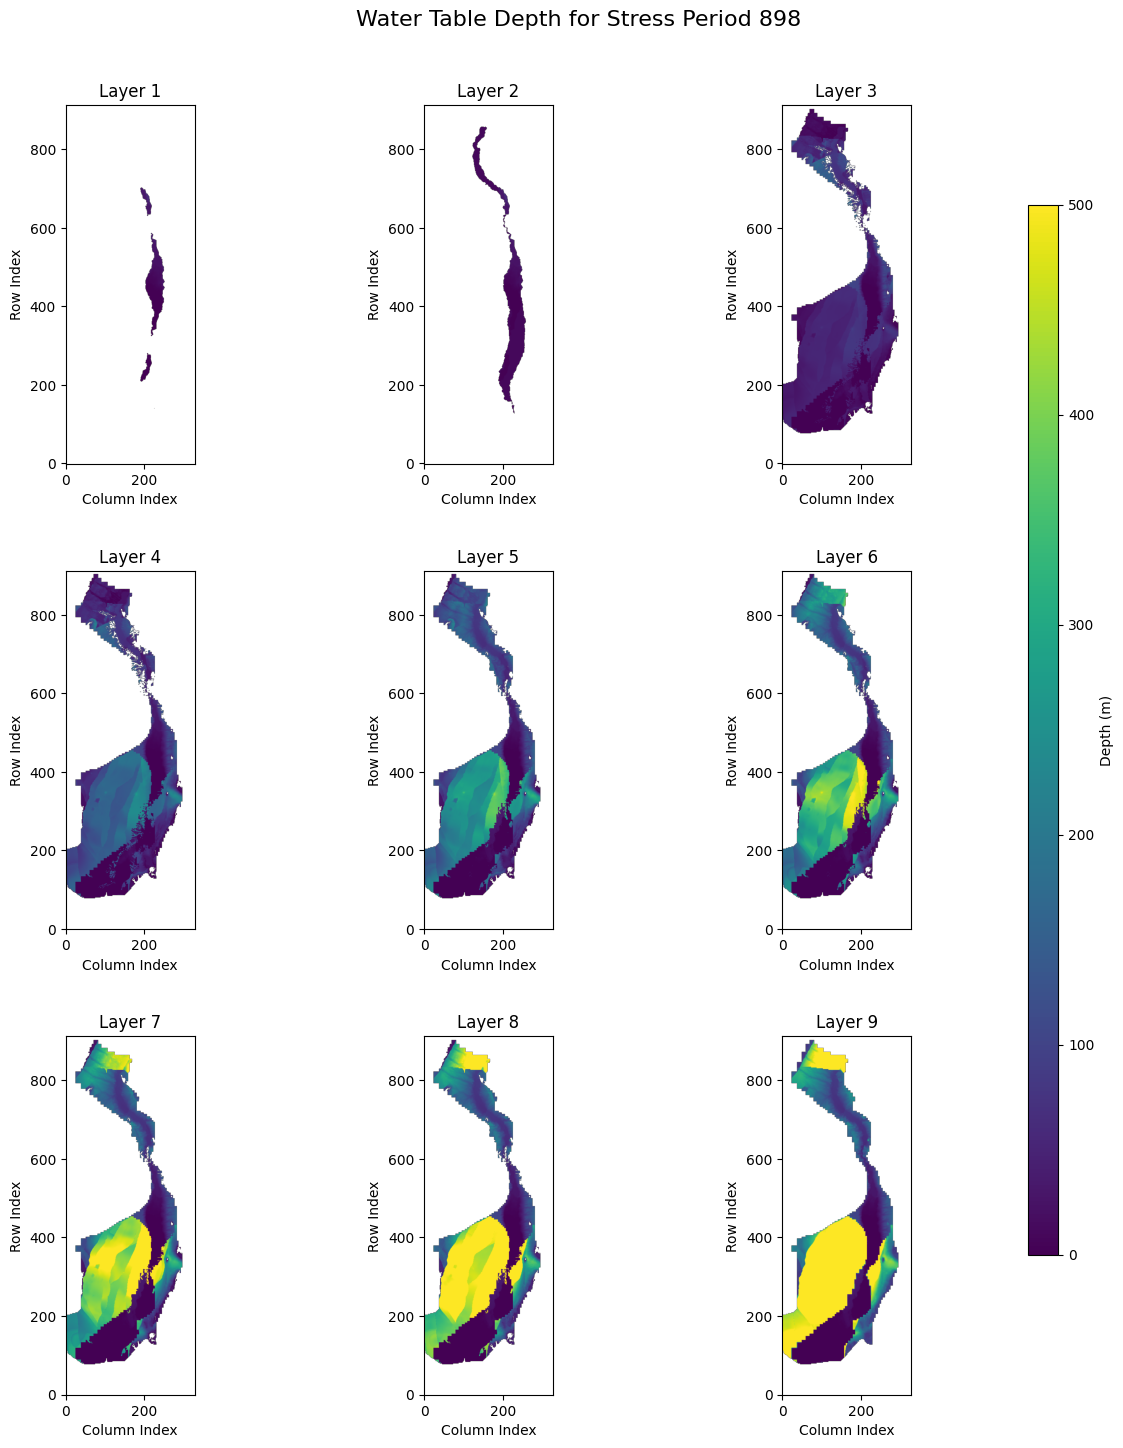

In [8]:
# Create a single figure with all SP 898 water table depth heatmaps for all layers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 heatmaps (9 layers for SP 898)
axes = axes.flatten()  # Flatten for easier indexing

fig.suptitle("Water Table Depth for Stress Period 898", fontsize=16)

# Plot SP 898 water table depth heatmaps for all layers
for k in range(nlay):
    ax = axes[k]
    im = ax.imshow(wt_depth_sp898_m[k], cmap="viridis", vmin=0, vmax=500, origin='lower')
    ax.set_title(f"Layer {k+1}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.set_aspect('equal')  # Ensure square aspect for each heatmap

# Add a shared colorbar (moved closer)
plt.subplots_adjust(left=0.05, right=0.88, wspace=0.1, hspace=0.1)  # Reduce right margin to bring colorbar closer
cbar_ax = fig.add_axes([0.80, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
plt.colorbar(im, cax=cbar_ax, label="Depth (m)")

# Ensure full extent with buffer
plt.tight_layout(pad=3.0, rect=[0, 0, 0.88, 1])  # Adjust rect to accommodate colorbar

# Save and show
plt.savefig(os.path.join(plots_dir, "all_sp898_wt_depth_heatmaps.png"))
plt.show()
plt.close()

/tmp/ipykernel_18310/343837650.py:23: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(pad=3.0, rect=[0, 0, 0.88, 1])  # Adjust rect to accommodate colorbar


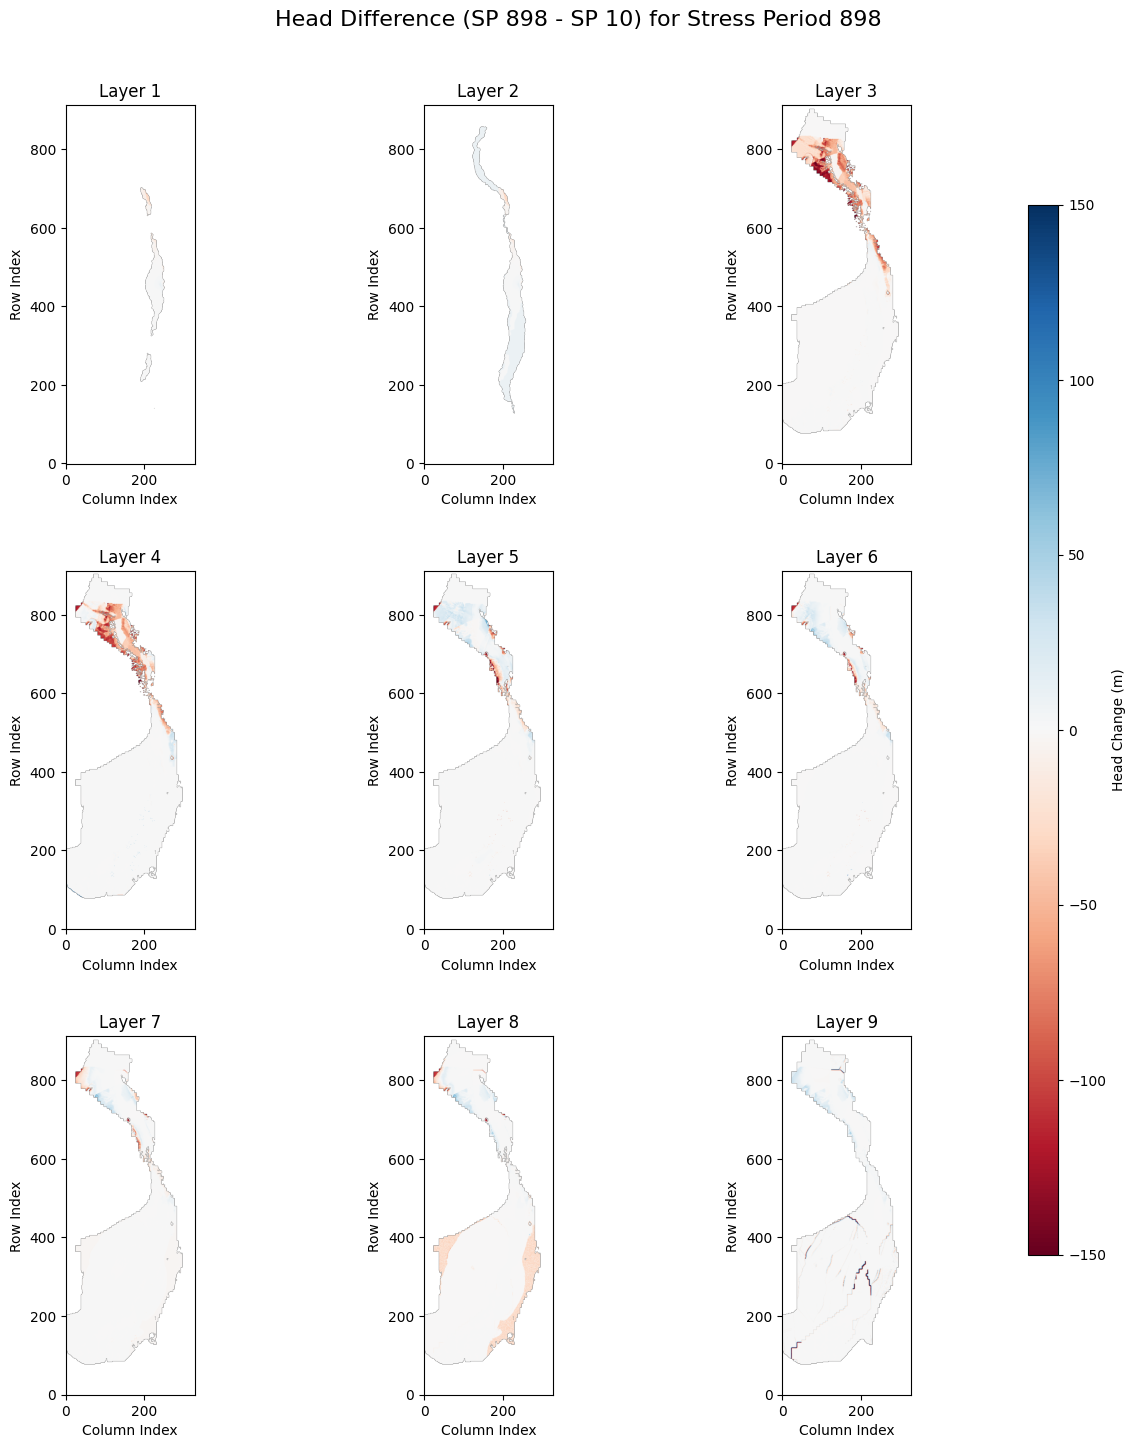

In [9]:
# Create a single figure with all head difference heatmaps for all layers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3x3 grid for 9 heatmaps (9 layers)
axes = axes.flatten()  # Flatten for easier indexing

fig.suptitle("Head Difference (SP 898 - SP 10) for Stress Period 898", fontsize=16)

# Plot head difference heatmaps for all layers
for k in range(nlay):
    head_diff = head_filtered_sp898_m[k] - head_filtered_sp10_m[k]
    ax = axes[k]
    im = ax.imshow(head_diff, cmap="RdBu", vmin=-150, vmax=150, origin='lower')
    ax.set_title(f"Layer {k+1}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    ax.set_aspect('equal')  # Ensure square aspect for each heatmap

# Add a shared colorbar (moved closer)
plt.subplots_adjust(left=0.05, right=0.88, wspace=0.1, hspace=0.1)  # Reduce right margin to bring colorbar closer
cbar_ax = fig.add_axes([0.80, 0.15, 0.02, 0.7])  # [left, bottom, width, height]
plt.colorbar(im, cax=cbar_ax, label="Head Change (m)")

# Ensure full extent with buffer
plt.tight_layout(pad=3.0, rect=[0, 0, 0.88, 1])  # Adjust rect to accommodate colorbar

# Save and show
plt.savefig(os.path.join(plots_dir, "all_head_diff_heatmaps.png"))
plt.show()
plt.close()

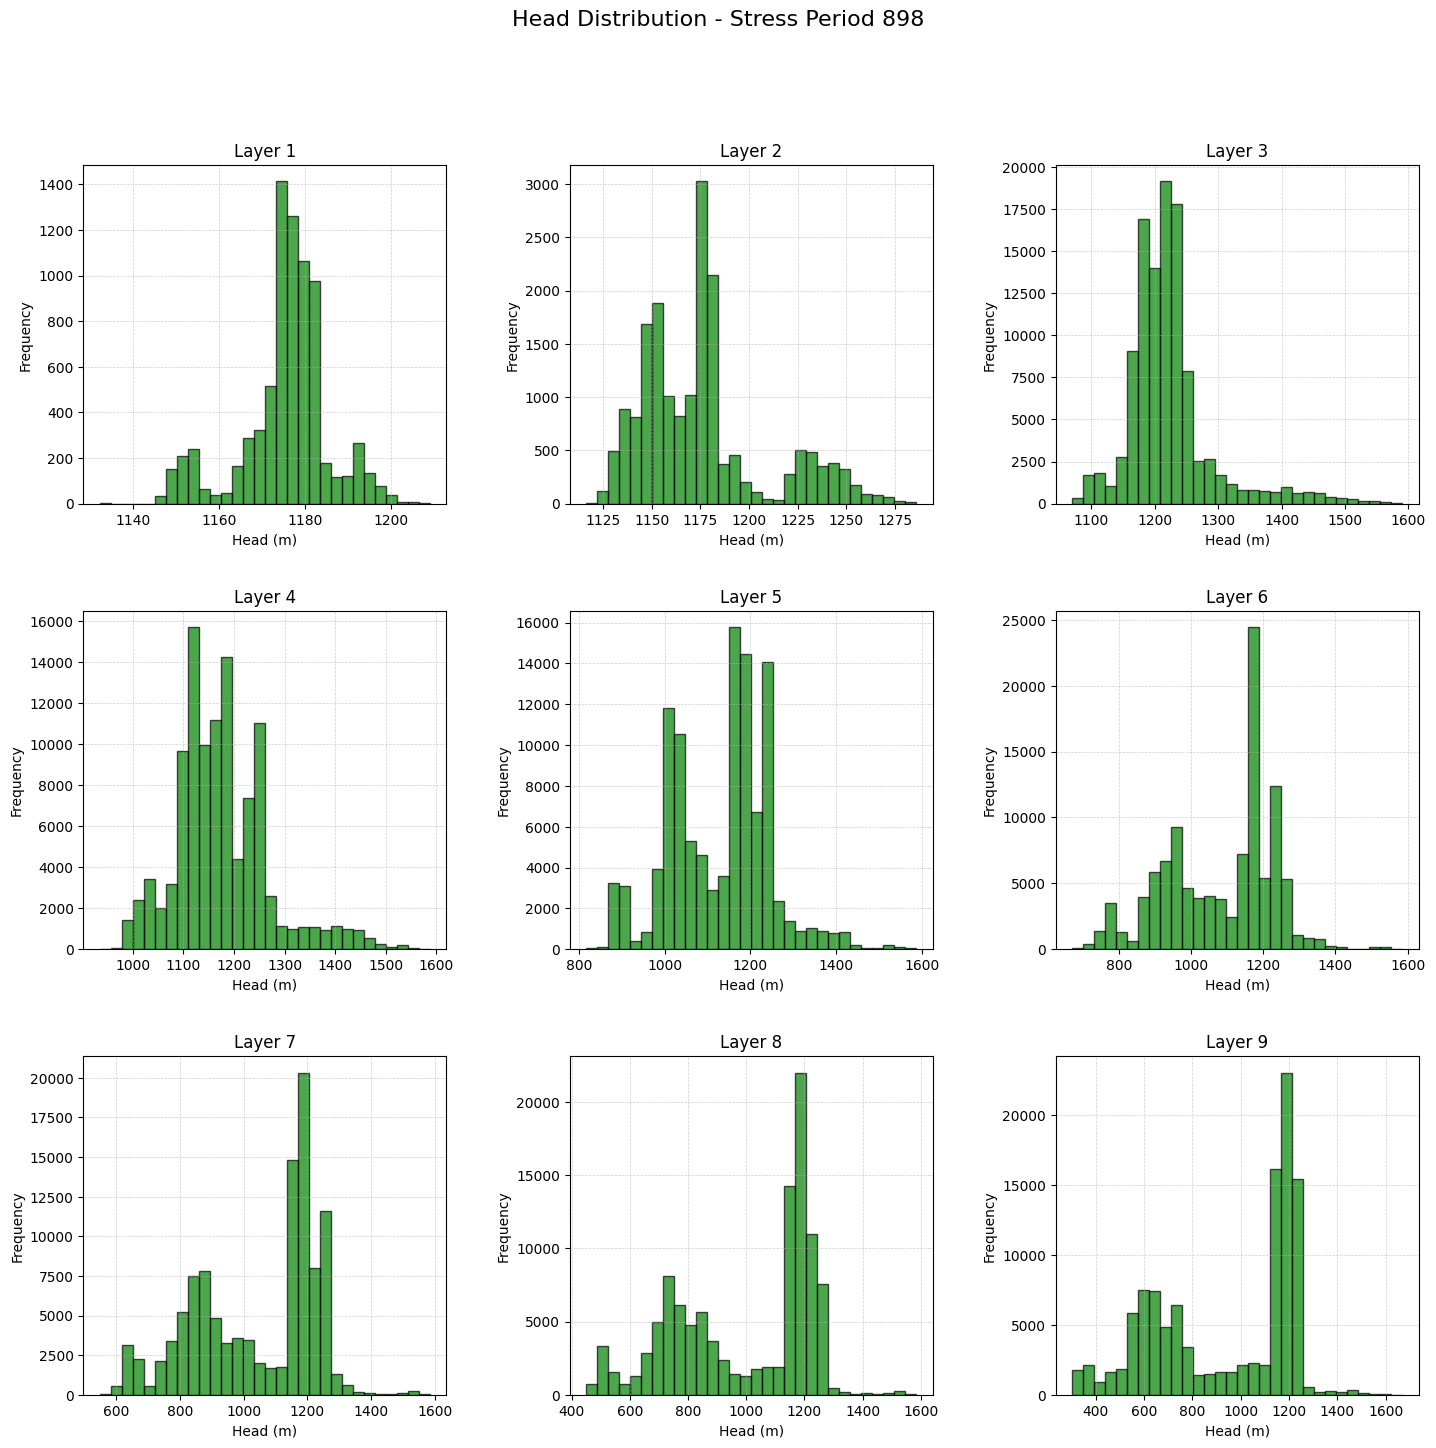

In [10]:
# create 3x3 figure for up to 9 layers
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
axes = axes.flatten()

fig.suptitle("Head Distribution - Stress Period 898", fontsize=16)

for k in range(nlay):
    ax = axes[k]
    data_sp898 = head_filtered_sp898_m[k].flatten()
    data_sp898 = data_sp898[~np.isnan(data_sp898)]

    ax.hist(data_sp898, bins=30, color='green', alpha=0.7, edgecolor='black')
    ax.set_title(f"Layer {k+1}", fontsize=12)
    ax.set_xlabel("Head (m)")
    ax.set_ylabel("Frequency")
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# turn off extra axes if nlay < 9
for i in range(nlay, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout(pad=3.0, rect=[0, 0, 1, 0.96])  # leave space for suptitle
plt.savefig(os.path.join(plots_dir, "head_histograms_sp898.png"))
plt.show()
plt.close()

## SP 10 and 1930

Head data range (SP 10, before filtering, in feet):
Min: 966.22, Max: 1000000000000000019884624838656.00
Head data range (SP 1930, before filtering, in feet):
Min: 993.26, Max: 1000000000000000019884624838656.00
L1: Active cells (idomain=1): 17879/299136
L2: Active cells (idomain=1): 17879/299136
L3: Active cells (idomain=1): 107959/299136
L4: Active cells (idomain=1): 107959/299136
L5: Active cells (idomain=1): 110244/299136
L6: Active cells (idomain=1): 110244/299136
L7: Active cells (idomain=1): 110573/299136
L8: Active cells (idomain=1): 110573/299136
L9: Active cells (idomain=1): 112576/299136

Head data range (SP 10, after filtering, in meters):
L1: Min: 1146.05, Max: 1219.29
L2: Min: 1112.62, Max: 1277.51
L3: Min: 1083.26, Max: 1590.45
L4: Min: 934.97, Max: 1586.94
L5: Min: 820.22, Max: 1586.03
L6: Min: 671.02, Max: 1585.26
L7: Min: 547.57, Max: 1584.50
L8: Min: 449.58, Max: 1583.74
L9: Min: 294.50, Max: 1669.08
Head data range (SP 1930, after filtering, in meters):
L1: Min: 113

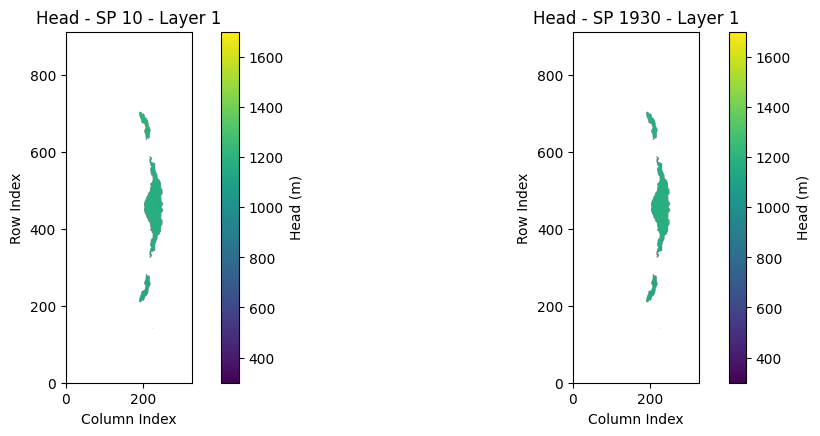

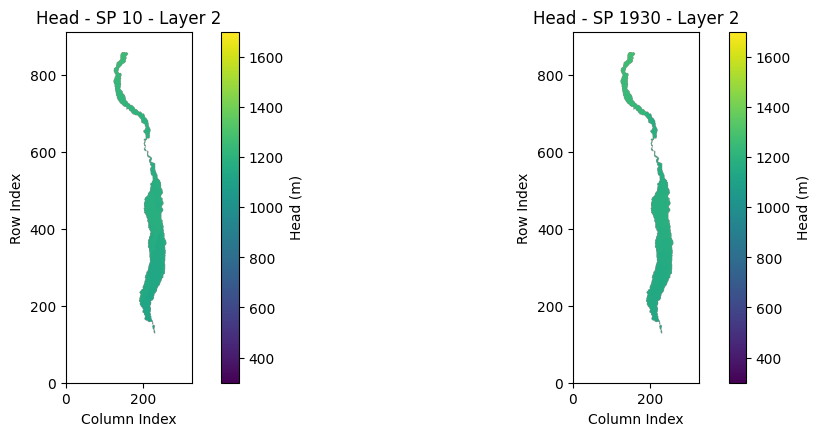

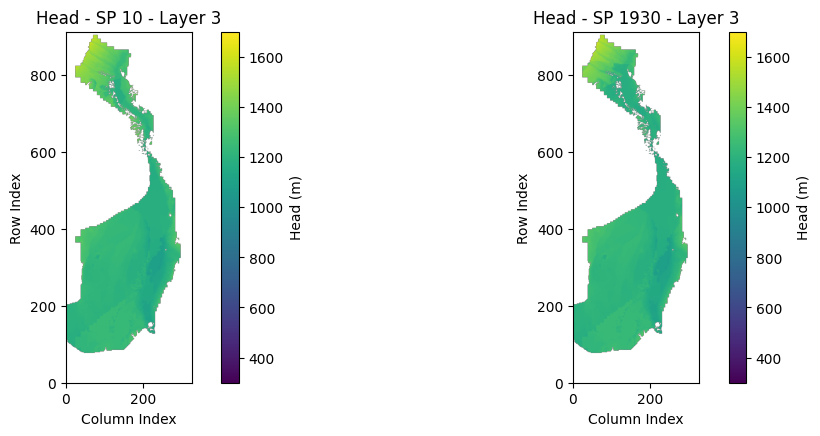

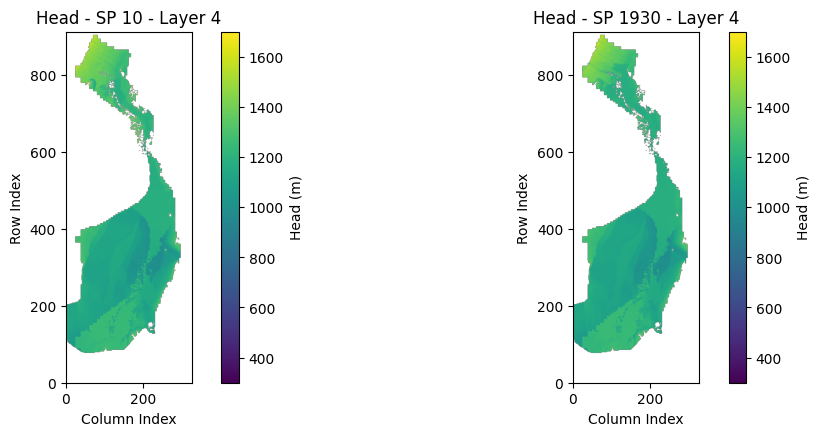

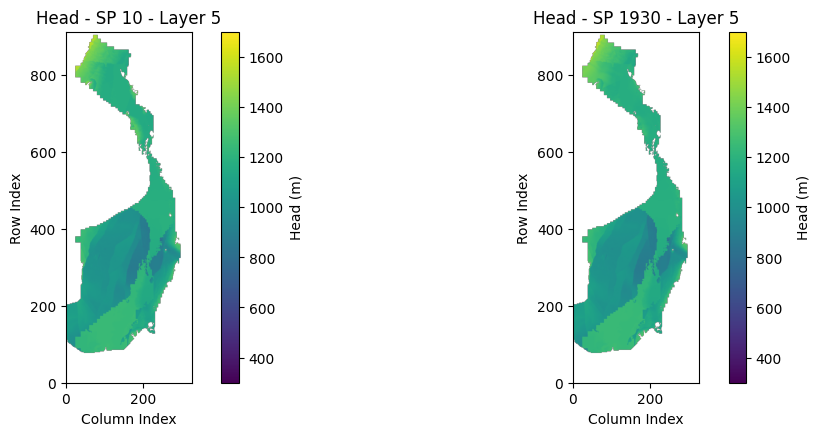

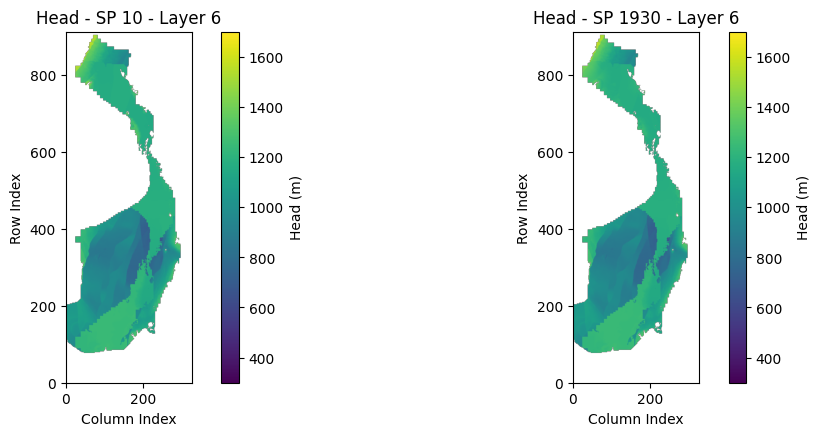

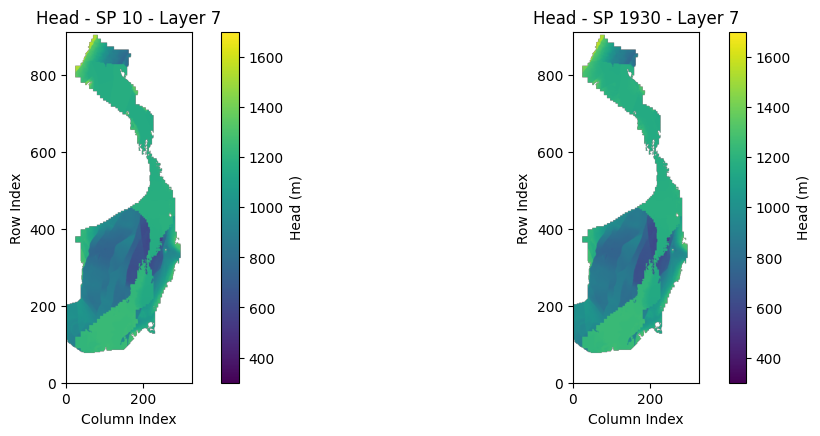

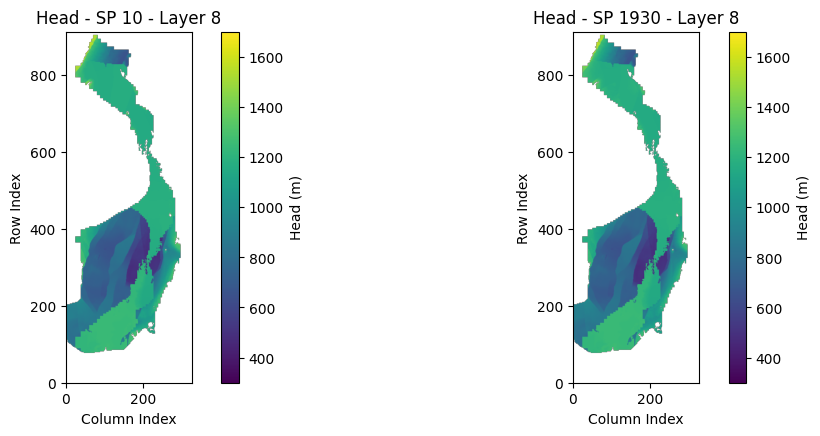

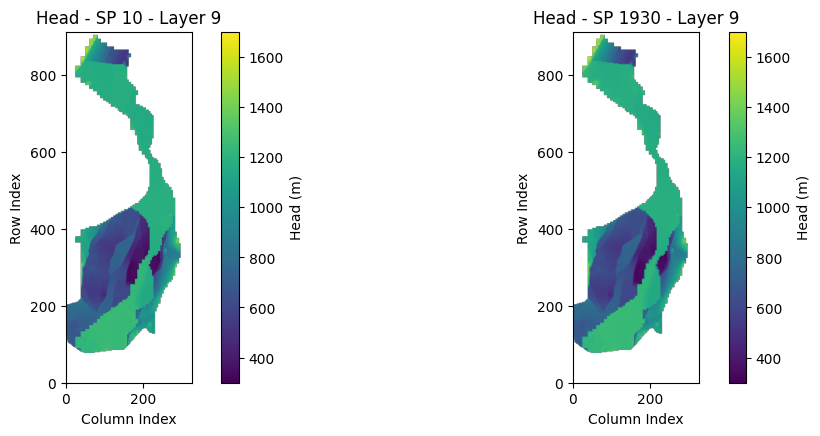

/tmp/ipykernel_18310/748722969.py:213: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap("tab10", nlay)


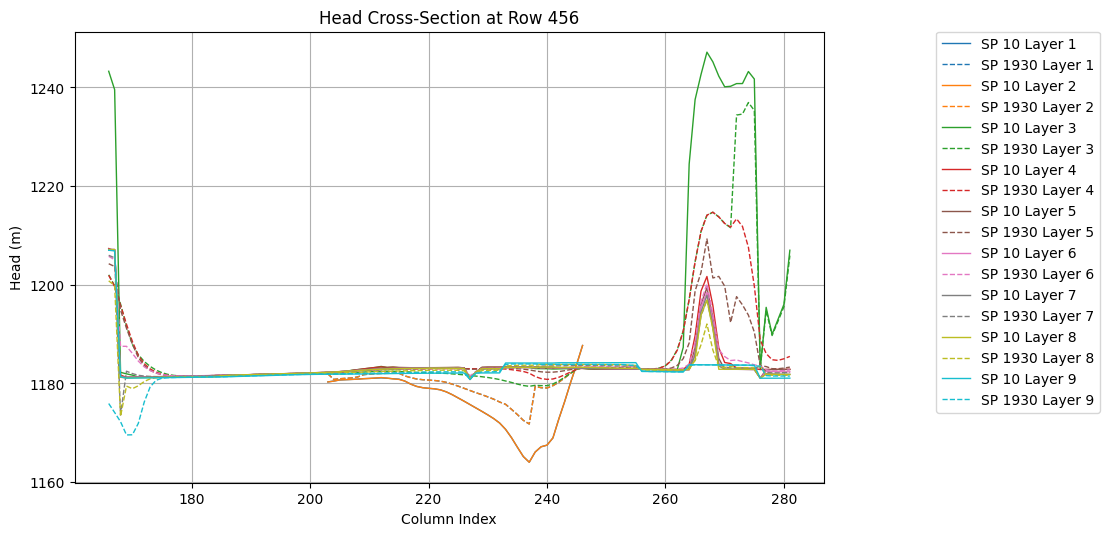

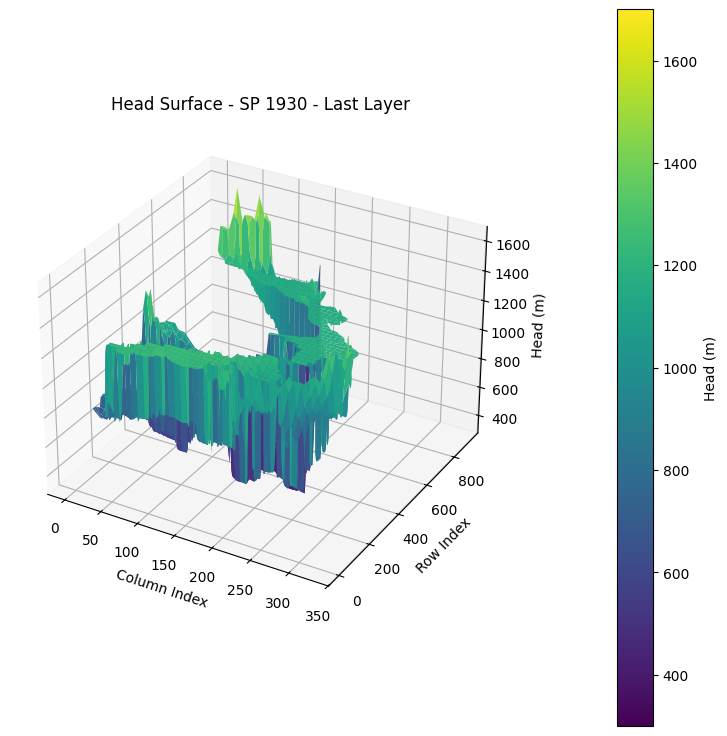

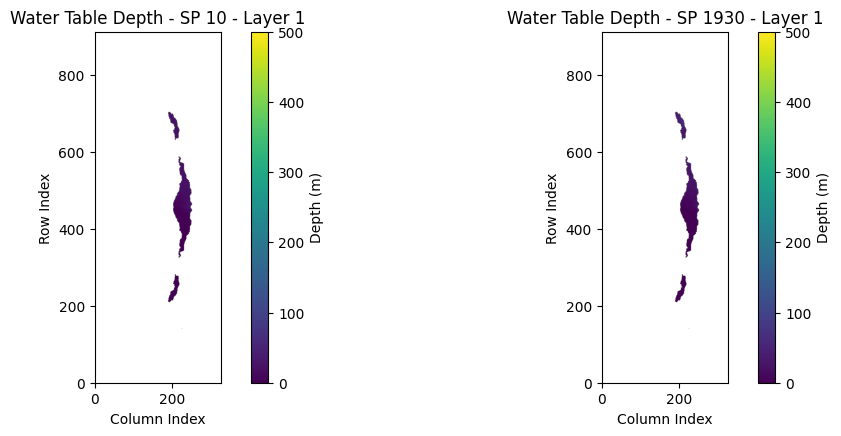

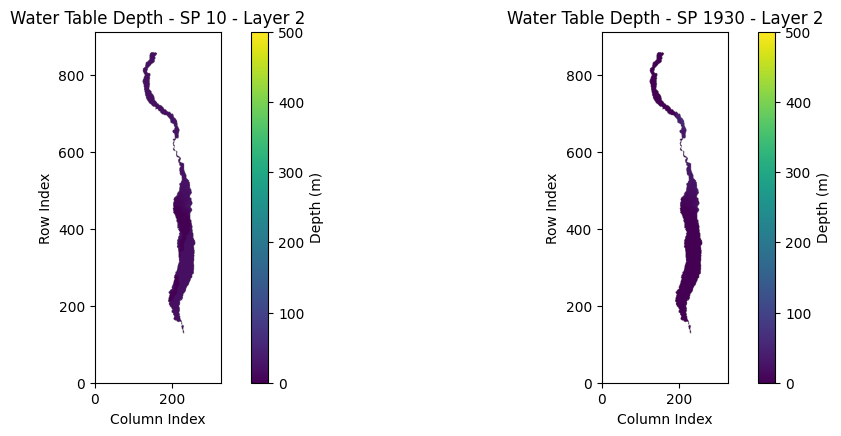

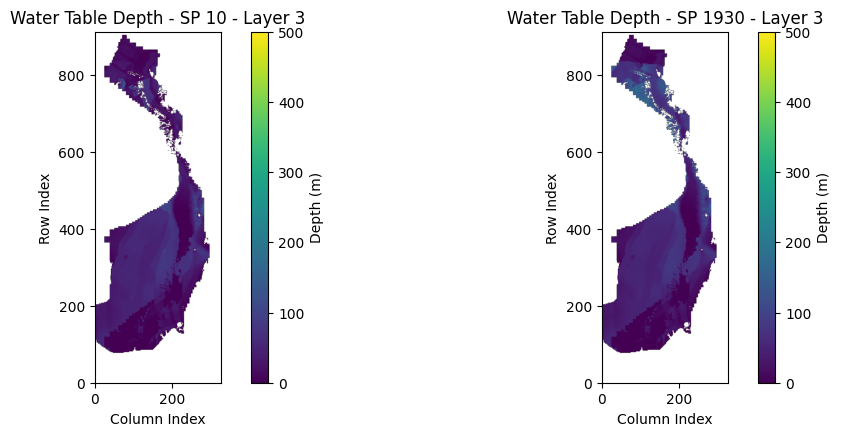

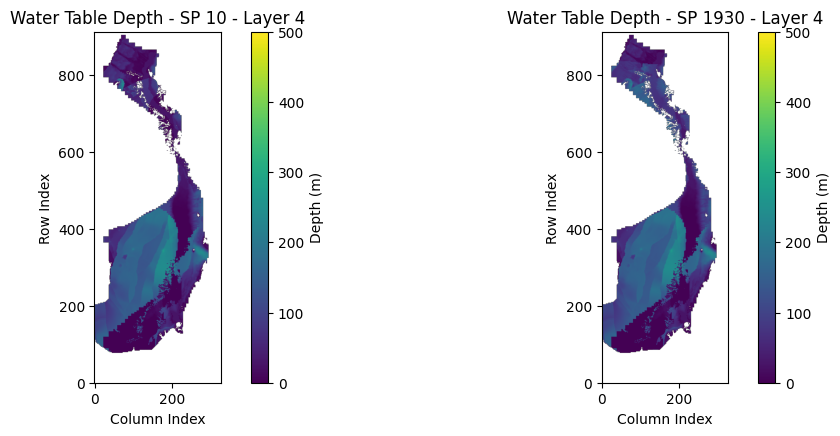

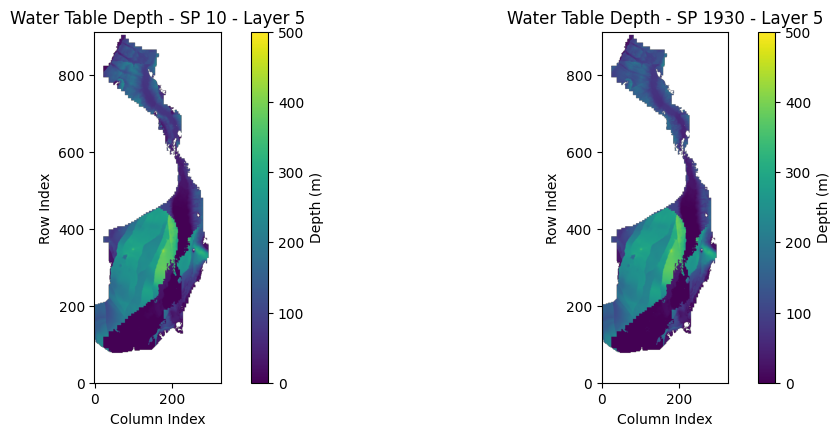

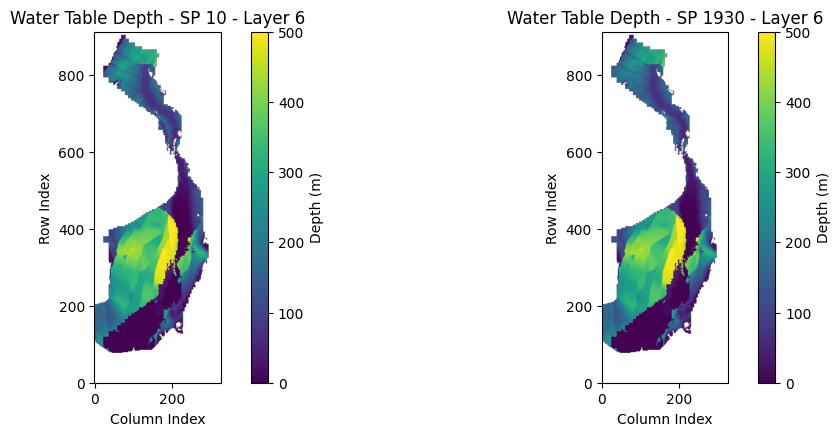

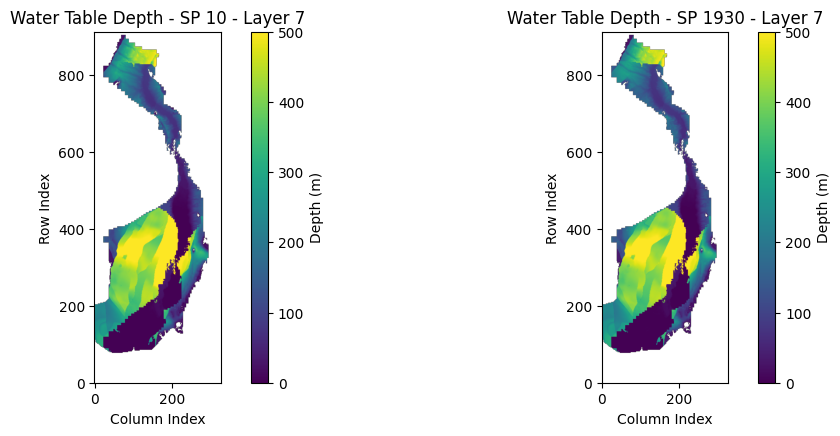

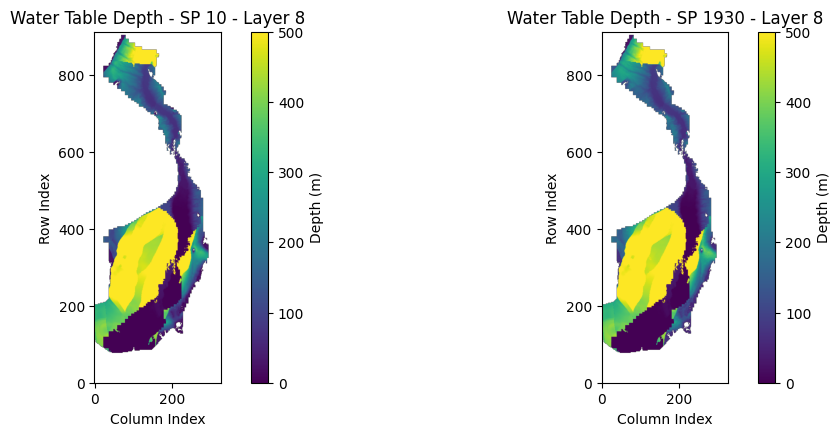

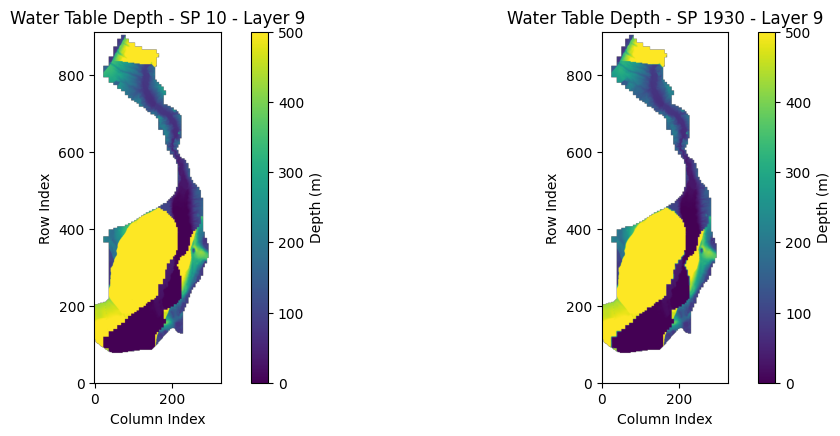

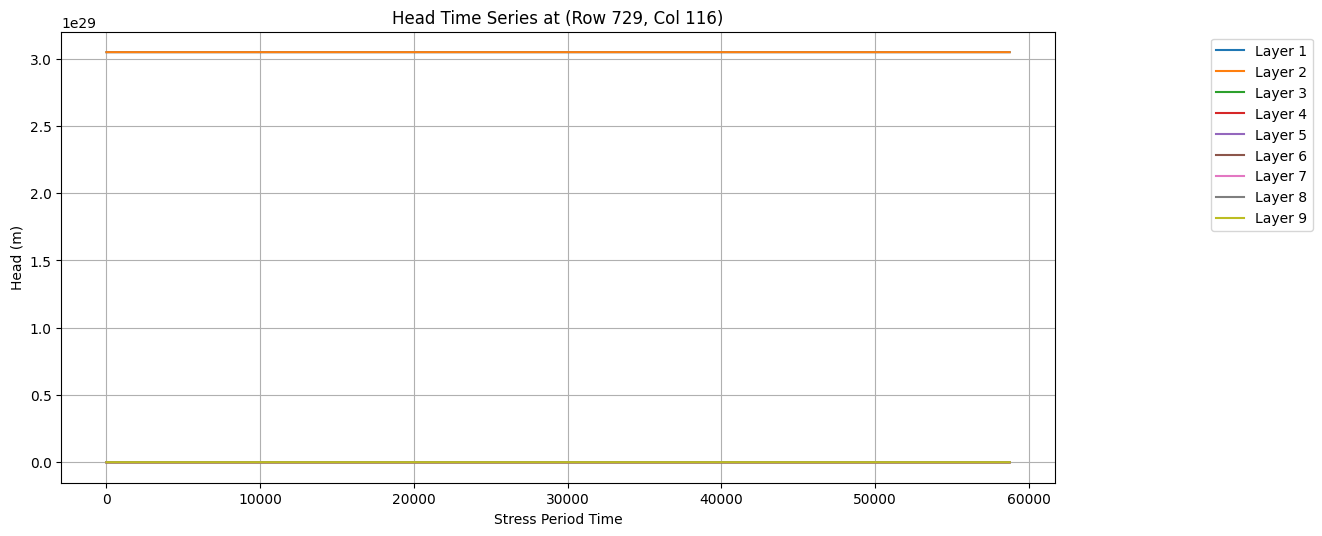

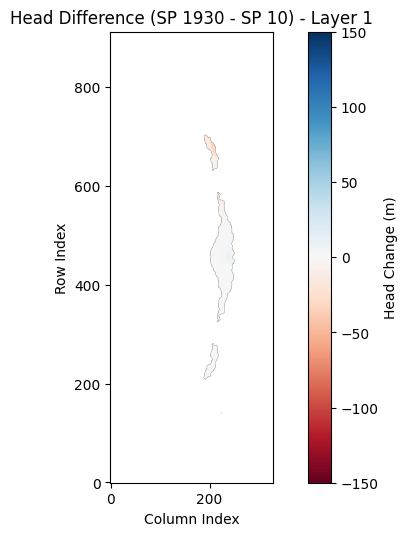

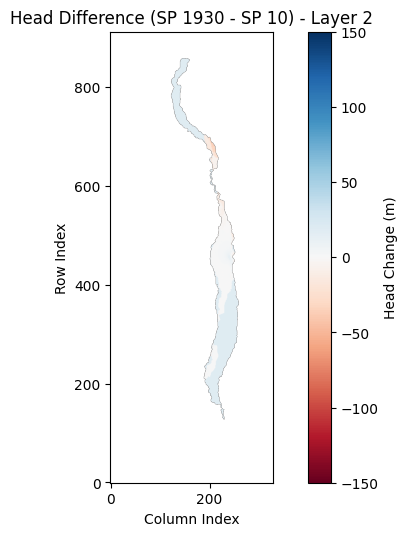

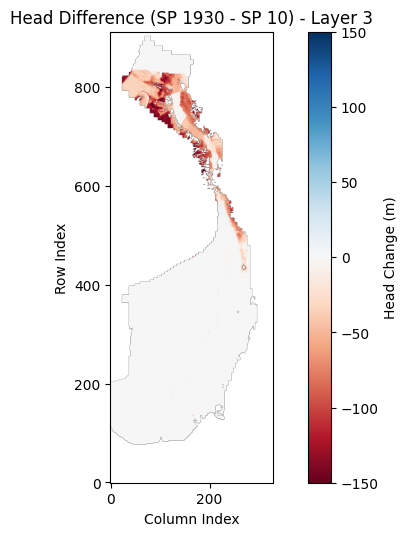

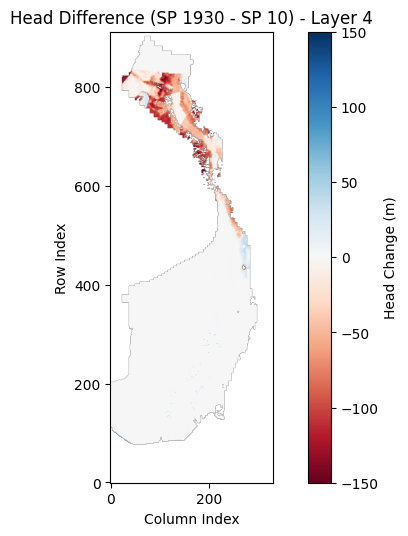

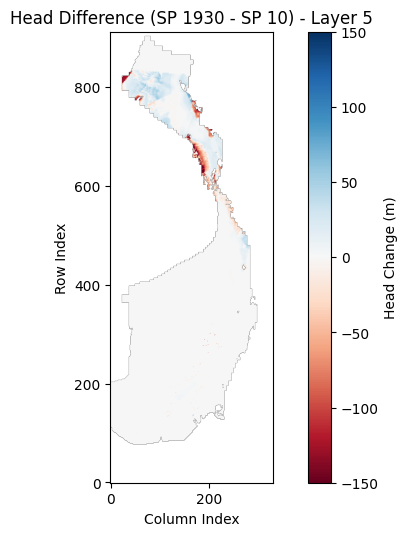

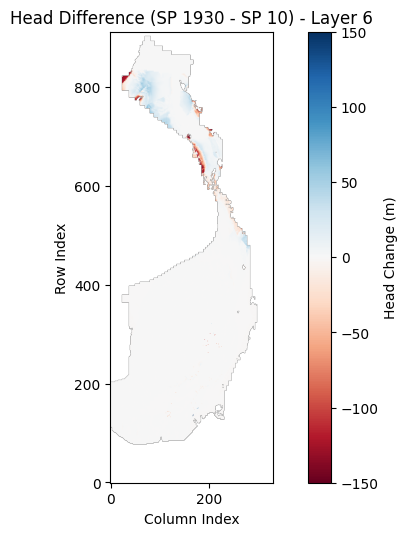

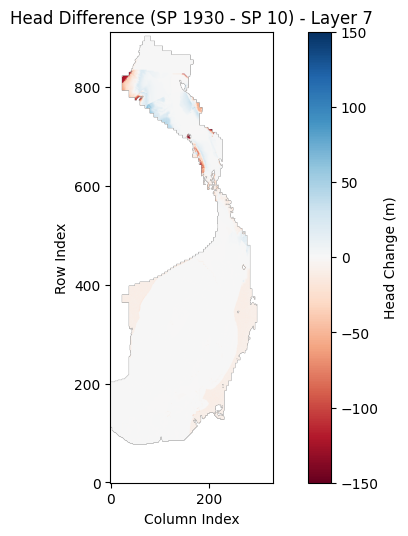

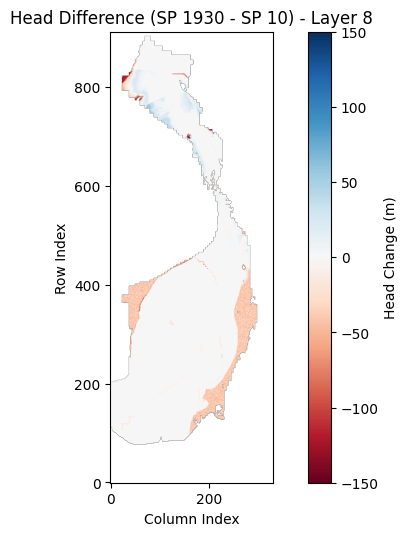

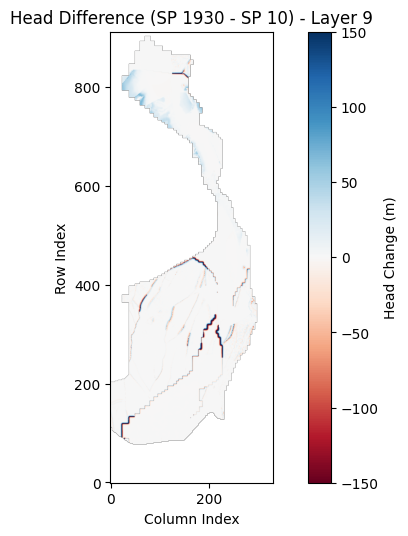

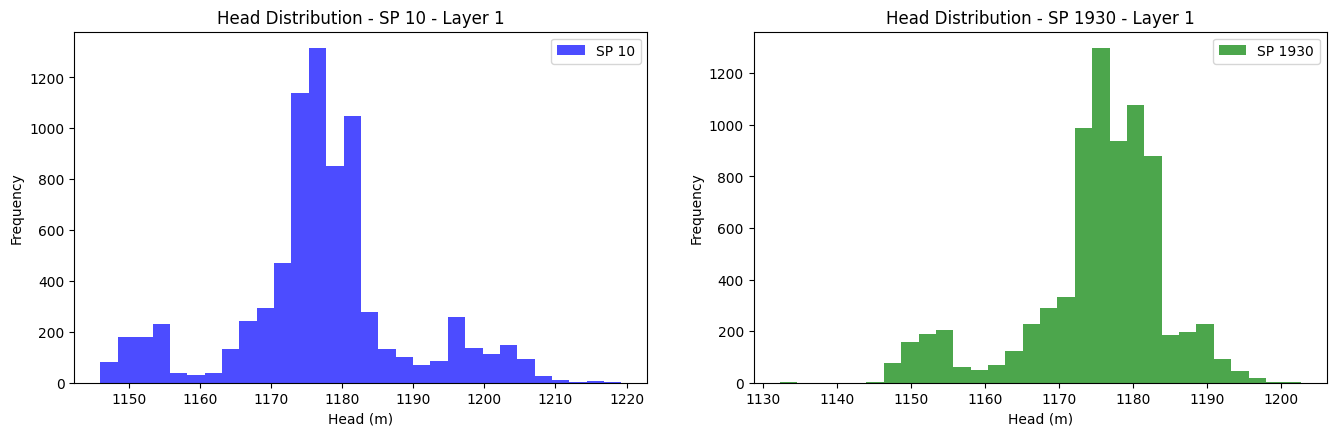

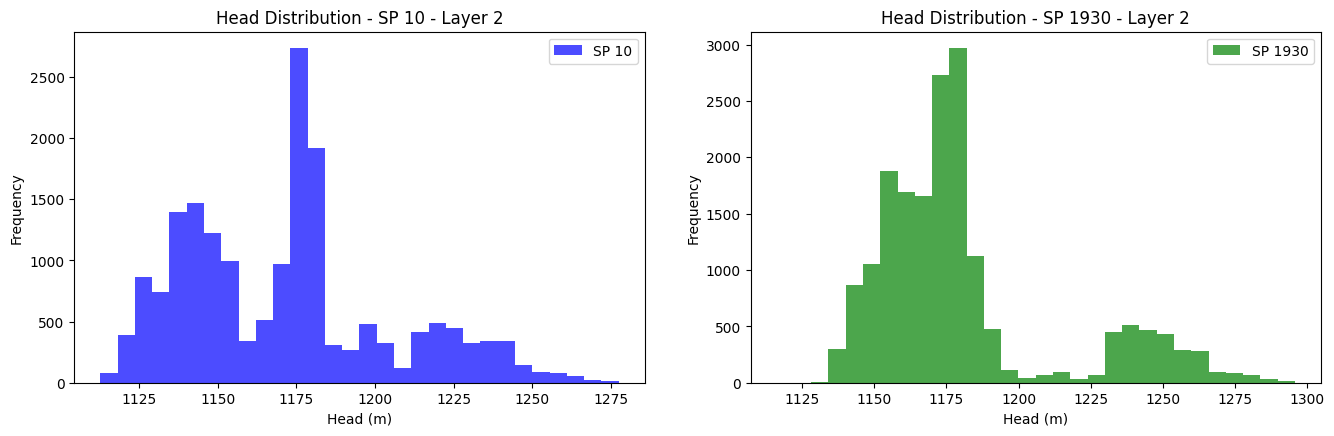

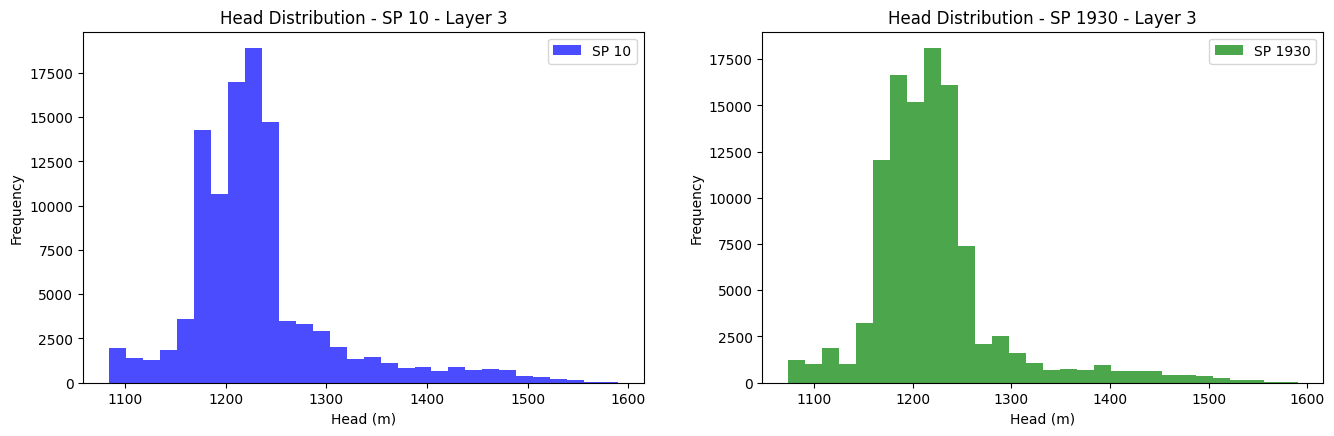

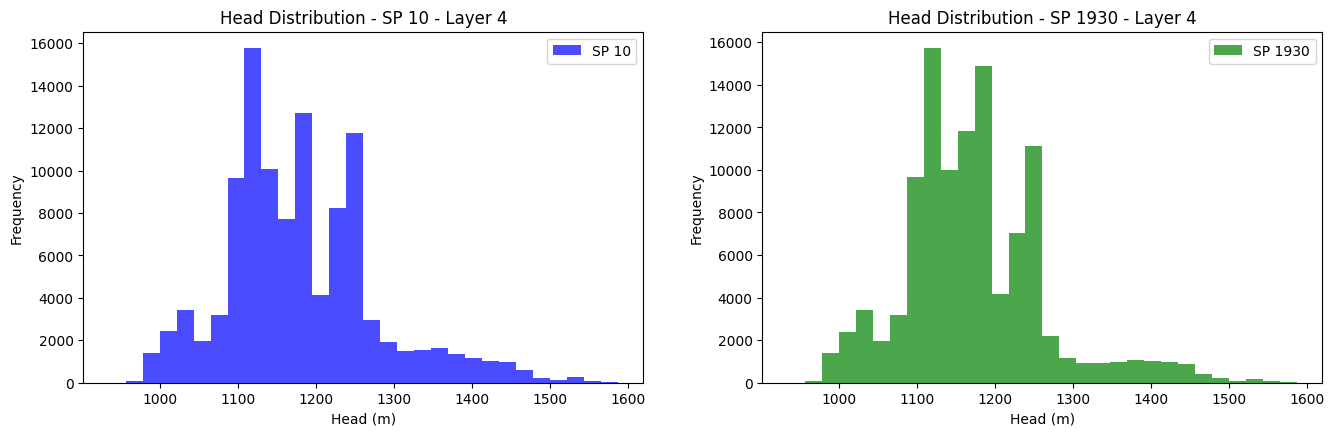

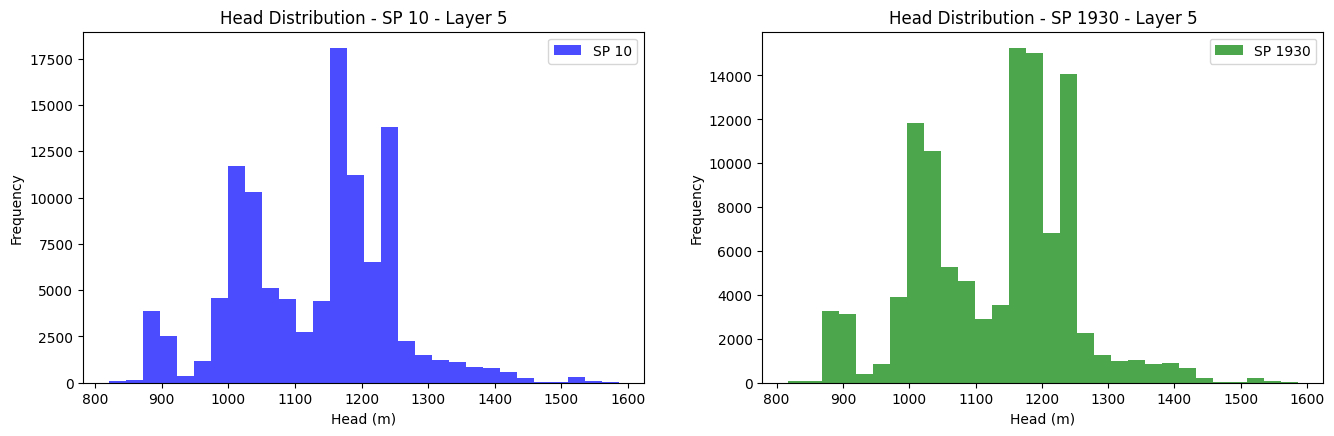

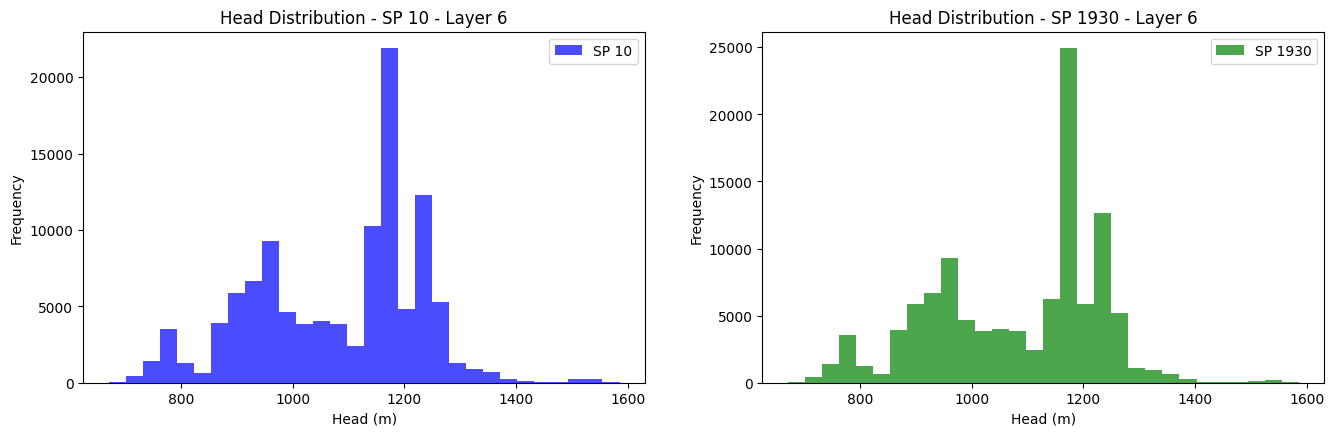

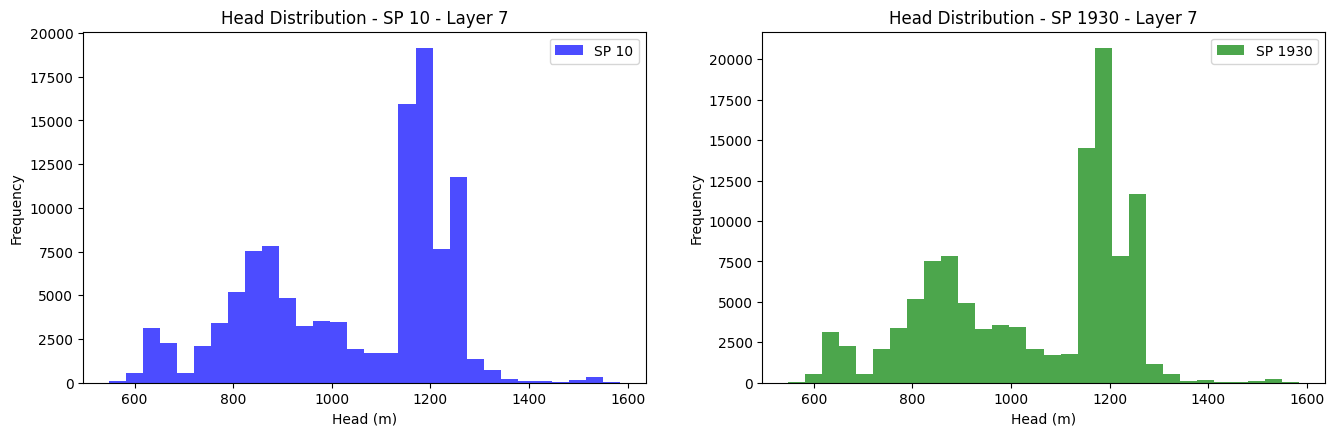

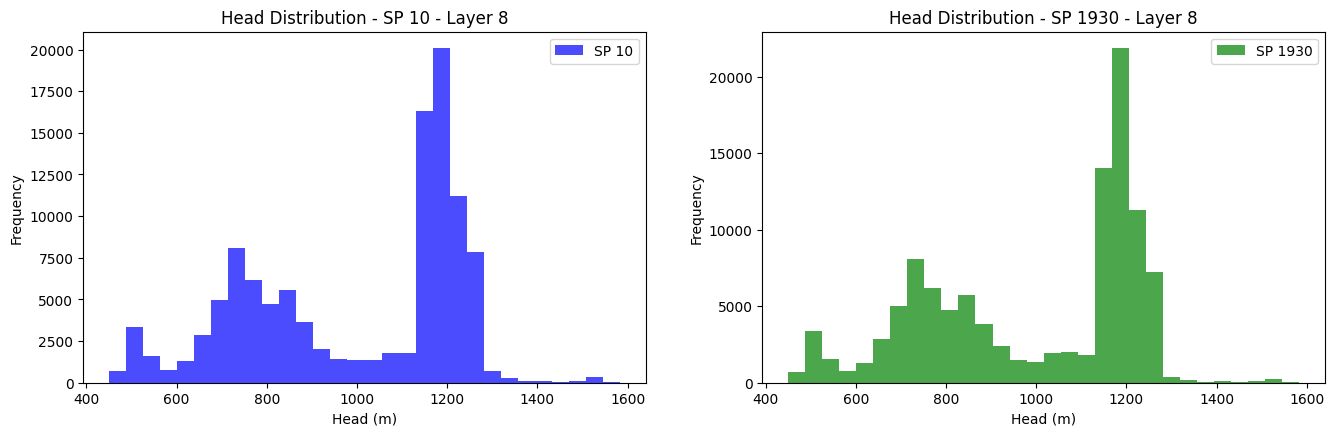

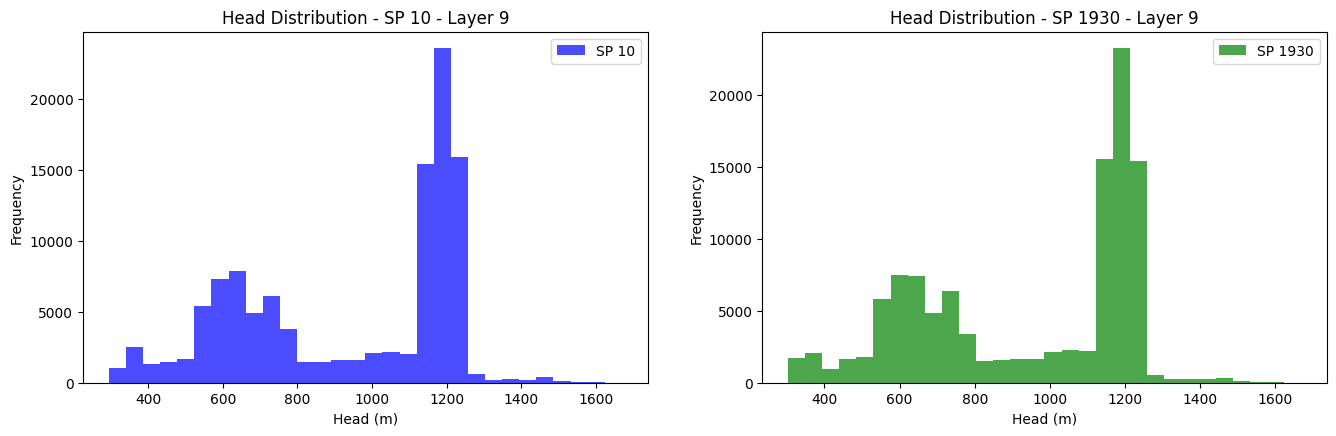

/tmp/ipykernel_18310/748722969.py:347: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(head_sp10_list, positions=np.arange(1, nlay+1)-0.2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.7), labels=[f"Layer {k+1}" for k in range(nlay)])


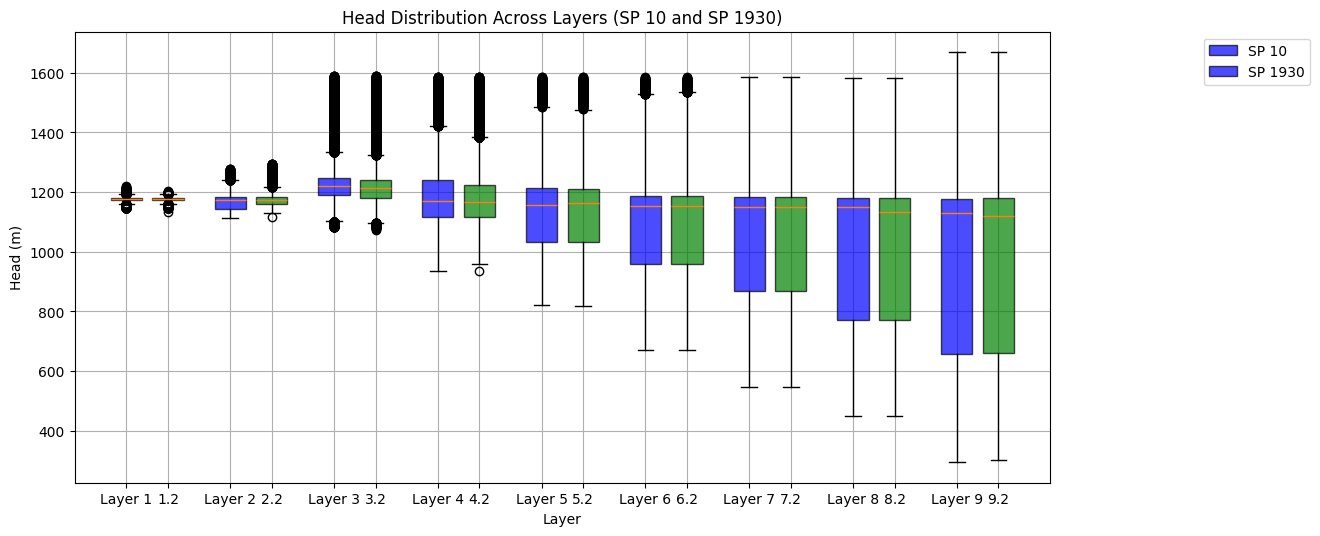

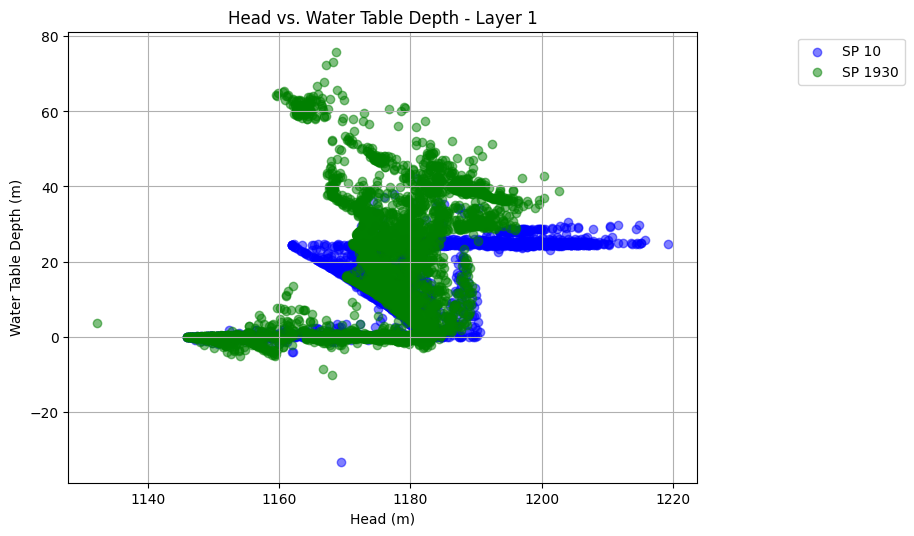

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import os
from scipy.stats import pearsonr
import pandas as pd
import matplotlib.cm as cm  # Import colormap module

# Flag to control plot display (set to False in non-interactive environments)
DISPLAY_PLOTS = True

# Check if required objects are defined
try:
    gwf
    headobj
except NameError:
    raise NameError("Required objects 'gwf' and 'headobj' must be defined (e.g., from a MODFLOW model).")

# Create plots subdirectory if it doesn't exist
plots_dir = "plots"
if not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# Grid dimensions from the model
nlay = gwf.dis.nlay.get_data()
nrow = gwf.dis.nrow.get_data()
ncol = gwf.dis.ncol.get_data()
delr = gwf.dis.delr.get_data()
delc = gwf.dis.delc.get_data()
idomain = gwf.dis.idomain.get_data()

# Validate grid dimensions
if nlay <= 0 or nrow <= 0 or ncol <= 0:
    raise ValueError(f"Invalid grid dimensions: nlay={nlay}, nrow={nrow}, ncol={ncol}")

# Load top elevation from gwf
top_elev = gwf.dis.top.get_data()  # 2D array in feet
top_elev_m = top_elev * 0.3048  # Convert to meters

# Create coordinate arrays for plotting (using indices, matching head data shape)
x = np.arange(ncol)
y = np.arange(nrow)
X, Y = np.meshgrid(x, y)  # Shape (nrow, ncol) to match head data

# Load head data for Stress Period 10 and 1930
head_times = headobj.get_times()
if len(head_times) < 1930:
    raise ValueError(f"headobj has only {len(head_times)} stress periods, need at least 1930.")
sp10_time = head_times[9]  # SP 10 is index 9 (0-based)
sp1930_time = head_times[1929]  # SP 1930 is index 1929
head_sp10 = headobj.get_data(totim=sp10_time)
head_sp1930 = headobj.get_data(totim=sp1930_time)

# Ensure head arrays are 3D (nlay, nrow, ncol)
for head in [head_sp10, head_sp1930]:
    if head.ndim == 2:
        head = head[np.newaxis, :, :]
    elif head.ndim != 3:
        raise ValueError(f"Unexpected head array shape: {head.shape}")

# Adjust nlay if head has fewer layers
if head_sp10.shape[0] != nlay or head_sp1930.shape[0] != nlay:
    print(f"Warning: head has {head_sp10.shape[0]} layers, but model expects {nlay}. Adjusting nlay.")
    nlay = min(head_sp10.shape[0], head_sp1930.shape[0])

# Filter extreme head values (threshold in feet)
head_filtered_sp10 = np.copy(head_sp10)
head_filtered_sp1930 = np.copy(head_sp1930)
threshold_feet = 10000  # Threshold in feet
for k in range(nlay):
    head_filtered_sp10[k][np.abs(head_sp10[k]) > threshold_feet] = np.nan
    head_filtered_sp10[k][idomain[k] == 0] = np.nan
    head_filtered_sp1930[k][np.abs(head_sp1930[k]) > threshold_feet] = np.nan
    head_filtered_sp1930[k][idomain[k] == 0] = np.nan

# Convert filtered head to meters for plotting
head_filtered_sp10_m = head_filtered_sp10 * 0.3048
head_filtered_sp1930_m = head_filtered_sp1930 * 0.3048

# Calculate water table depth (top - head) for SP 10 and SP 1930
# Ensure top_elev_m is broadcastable to 3D
if top_elev_m.shape != head_filtered_sp10_m.shape[1:]:
    raise ValueError(f"top_elev_m shape {top_elev_m.shape} incompatible with head shape {head_filtered_sp10_m.shape[1:]}")
wt_depth_sp10_m = top_elev_m[np.newaxis, :, :] - head_filtered_sp10_m
wt_depth_sp1930_m = top_elev_m[np.newaxis, :, :] - head_filtered_sp1930_m

# Diagnostic checks and statistics
print("Head data range (SP 10, before filtering, in feet):")
print(f"Min: {np.nanmin(head_sp10):.2f}, Max: {np.nanmax(head_sp10):.2f}")
print("Head data range (SP 1930, before filtering, in feet):")
print(f"Min: {np.nanmin(head_sp1930):.2f}, Max: {np.nanmax(head_sp1930):.2f}")
for k in range(nlay):
    active_cells = np.sum(idomain[k] == 1)
    total_cells = nrow * ncol
    print(f"L{k+1}: Active cells (idomain=1): {active_cells}/{total_cells}")

print("\nHead data range (SP 10, after filtering, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(head_filtered_sp10_m[k])
    layer_max = np.nanmax(head_filtered_sp10_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")
print("Head data range (SP 1930, after filtering, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(head_filtered_sp1930_m[k])
    layer_max = np.nanmax(head_filtered_sp1930_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")

print("\nWater Table Depth range (SP 10, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(wt_depth_sp10_m[k])
    layer_max = np.nanmax(wt_depth_sp10_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")
print("Water Table Depth range (SP 1930, in meters):")
for k in range(nlay):
    layer_min = np.nanmin(wt_depth_sp1930_m[k])
    layer_max = np.nanmax(wt_depth_sp1930_m[k])
    print(f"L{k+1}: Min: {layer_min:.2f}, Max: {layer_max:.2f}")

# Additional Statistics
# 1. Basic Statistics per Layer
print("\nBasic Statistics (SP 10 Heads, in meters):")
for k in range(nlay):
    data = head_filtered_sp10_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

print("\nBasic Statistics (SP 1930 Heads, in meters):")
for k in range(nlay):
    data = head_filtered_sp1930_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

print("\nBasic Statistics (SP 10 Water Table Depth, in meters):")
for k in range(nlay):
    data = wt_depth_sp10_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

print("\nBasic Statistics (SP 1930 Water Table Depth, in meters):")
for k in range(nlay):
    data = wt_depth_sp1930_m[k].flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean: {np.mean(data):.2f}, Median: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        print(f"        Percentiles (25th, 75th): {np.percentile(data, 25):.2f}, {np.percentile(data, 75):.2f}")

# 2. Change Statistics (SP 1930 - SP 10)
print("\nHead Change Statistics (SP 1930 - SP 10, in meters):")
for k in range(nlay):
    head_diff = head_filtered_sp1930_m[k] - head_filtered_sp10_m[k]
    data = head_diff.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean Change: {np.mean(data):.2f}, Median Change: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        increased = np.sum(data > 0) / len(data) * 100
        decreased = np.sum(data < 0) / len(data) * 100
        print(f"        % Increased: {increased:.2f}%, % Decreased: {decreased:.2f}%")

# 3. Correlation Analysis
print("\nCorrelation between Head and Water Table Depth:")
for k in range(nlay):
    head_sp10 = head_filtered_sp10_m[k].flatten()
    wt_sp10 = wt_depth_sp10_m[k].flatten()
    head_sp1930 = head_filtered_sp1930_m[k].flatten()
    wt_sp1930 = wt_depth_sp1930_m[k].flatten()
    
    mask_sp10 = ~np.isnan(head_sp10) & ~np.isnan(wt_sp10)
    mask_sp1930 = ~np.isnan(head_sp1930) & ~np.isnan(wt_sp1930)
    
    if np.sum(mask_sp10) > 0:
        corr_sp10, _ = pearsonr(head_sp10[mask_sp10], wt_sp10[mask_sp10])
        print(f"L{k+1} (SP 10): Correlation Head vs WT Depth: {corr_sp10:.3f}")
    if np.sum(mask_sp1930) > 0:
        corr_sp1930, _ = pearsonr(head_sp1930[mask_sp1930], wt_sp1930[mask_sp1930])
        print(f"L{k+1} (SP 1930): Correlation Head vs WT Depth: {corr_sp1930:.3f}")

# Plot 1: Heatmaps for each layer for SP 10 and SP 1930
for k in range(nlay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # SP 10 Heatmap
    im1 = ax1.imshow(head_filtered_sp10_m[k], cmap="viridis", vmin=300, vmax=1700, origin='lower')
    ax1.set_title(f"Head - SP 10 - Layer {k+1}")
    ax1.set_xlabel("Column Index")
    ax1.set_ylabel("Row Index")
    plt.colorbar(im1, ax=ax1, label="Head (m)")
    
    # SP 1930 Heatmap
    im2 = ax2.imshow(head_filtered_sp1930_m[k], cmap="viridis", vmin=300, vmax=1700, origin='lower')
    ax2.set_title(f"Head - SP 1930 - Layer {k+1}")
    ax2.set_xlabel("Column Index")
    ax2.set_ylabel("Row Index")
    plt.colorbar(im2, ax=ax2, label="Head (m)")
    
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"head_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 2: Cross-sectional view (along the middle row) for SP 10 and SP 1930
row_idx = nrow // 2
if row_idx >= nrow:
    raise ValueError(f"Invalid row_idx {row_idx} for nrow {nrow}")
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(1, 1, 1)
colors = cm.get_cmap("tab10", nlay)

for k in range(nlay):
    color = colors(k)
    ax.plot(x, head_filtered_sp10_m[k, row_idx, :], label=f"SP 10 Layer {k+1}", color=color, linewidth=1.0)
    ax.plot(x, head_filtered_sp1930_m[k, row_idx, :], '--', label=f"SP 1930 Layer {k+1}", color=color, linewidth=1.0)

ax.set_title(f"Head Cross-Section at Row {row_idx}")
ax.set_xlabel("Column Index")
ax.set_ylabel("Head (m)")
ax.legend(bbox_to_anchor=(1.15, 1), loc='upper left', borderaxespad=0.)
ax.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_cross_section.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 3: 3D Surface plot for the last layer of SP 1930
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(1, 1, 1, projection="3d")
surf_sp1930 = ax.plot_surface(X, Y, head_filtered_sp1930_m[-1], cmap="viridis", vmin=300, vmax=1700)
ax.set_title("Head Surface - SP 1930 - Last Layer")
ax.set_xlabel("Column Index")
ax.set_ylabel("Row Index")
ax.set_zlabel("Head (m)")
fig.colorbar(surf_sp1930, ax=ax, label="Head (m)", pad=0.15)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_surface.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 4: Water Table Depth Heatmaps for each layer for SP 10 and SP 1930
for k in range(nlay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    # SP 10 Water Table Depth Heatmap
    im1 = ax1.imshow(wt_depth_sp10_m[k], cmap="viridis", vmin=0, vmax=500, origin='lower')
    ax1.set_title(f"Water Table Depth - SP 10 - Layer {k+1}")
    ax1.set_xlabel("Column Index")
    ax1.set_ylabel("Row Index")
    plt.colorbar(im1, ax=ax1, label="Depth (m)")
    
    # SP 1930 Water Table Depth Heatmap
    im2 = ax2.imshow(wt_depth_sp1930_m[k], cmap="viridis", vmin=0, vmax=500, origin='lower')
    ax2.set_title(f"Water Table Depth - SP 1930 - Layer {k+1}")
    ax2.set_xlabel("Column Index")
    ax2.set_ylabel("Row Index")
    plt.colorbar(im2, ax=ax2, label="Depth (m)")
    
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"wt_depth_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 5: Time Series Plot for Specific Cells
row, col = 729, 116
if row >= nrow or col >= ncol:
    raise ValueError(f"Invalid cell coordinates (row={row}, col={col}) for grid (nrow={nrow}, ncol={ncol})")
if np.any(idomain[:, row, col] == 0):
    print(f"Warning: Cell (row={row}, col={col}) is inactive in some layers (idomain=0)")
head_times_series = []
for t in head_times:
    head_data = headobj.get_data(totim=t)
    if head_data.ndim == 2:
        head_data = head_data[np.newaxis, :, :]
    head_data_m = head_data * 0.3048
    head_times_series.append(head_data_m[:, row, col])

head_times_series = np.array(head_times_series)  # Shape (n_times, nlay)
fig = plt.figure(figsize=(14, 6))
for k in range(nlay):
    plt.plot(head_times, head_times_series[:, k], label=f"Layer {k+1}")
plt.title(f"Head Time Series at (Row {row}, Col {col})")
plt.xlabel("Stress Period Time")
plt.ylabel("Head (m)")
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_time_series.png"))
if DISPLAY_PLOTS:
        plt.show()
plt.close()

# Plot 6: Head Difference Heatmaps (SP 1930 - SP 10)
for k in range(nlay):
    head_diff = head_filtered_sp1930_m[k] - head_filtered_sp10_m[k]
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(head_diff, cmap="RdBu", vmin=-150, vmax=150, origin='lower')
    ax.set_title(f"Head Difference (SP 1930 - SP 10) - Layer {k+1}")
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.colorbar(im, ax=ax, label="Head Change (m)")
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"head_diff_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 7: Histogram of Head Values per Layer
for k in range(nlay):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # SP 10 Histogram
    data_sp10 = head_filtered_sp10_m[k].flatten()
    data_sp10 = data_sp10[~np.isnan(data_sp10)]
    ax1.hist(data_sp10, bins=30, color='blue', alpha=0.7, label='SP 10')
    ax1.set_title(f"Head Distribution - SP 10 - Layer {k+1}")
    ax1.set_xlabel("Head (m)")
    ax1.set_ylabel("Frequency")
    ax1.legend()
    
    # SP 1930 Histogram
    data_sp1930 = head_filtered_sp1930_m[k].flatten()
    data_sp1930 = data_sp1930[~np.isnan(data_sp1930)]
    ax2.hist(data_sp1930, bins=30, color='green', alpha=0.7, label='SP 1930')
    ax2.set_title(f"Head Distribution - SP 1930 - Layer {k+1}")
    ax2.set_xlabel("Head (m)")
    ax2.set_ylabel("Frequency")
    ax2.legend()
    
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"head_histogram_layer{k+1}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()

# Plot 8: Box Plot of Head Across Layers
fig = plt.figure(figsize=(14, 6))
head_sp10_list = [head_filtered_sp10_m[k].flatten()[~np.isnan(head_filtered_sp10_m[k].flatten())] for k in range(nlay)]
head_sp1930_list = [head_filtered_sp1930_m[k].flatten()[~np.isnan(head_filtered_sp1930_m[k].flatten())] for k in range(nlay)]
plt.boxplot(head_sp10_list, positions=np.arange(1, nlay+1)-0.2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.7), labels=[f"Layer {k+1}" for k in range(nlay)])
plt.boxplot(head_sp1930_list, positions=np.arange(1, nlay+1)+0.2, widths=0.3, patch_artist=True, boxprops=dict(facecolor='green', alpha=0.7))
plt.title("Head Distribution Across Layers (SP 10 and SP 1930)")
plt.xlabel("Layer")
plt.ylabel("Head (m)")
plt.legend(['SP 10', 'SP 1930'], bbox_to_anchor=(1.15, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_boxplot.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

# Plot 9: Scatter Plot of Head vs. Water Table Depth (for Layer 1)
k = 0  # Layer 1
head_sp10_flat = head_filtered_sp10_m[k].flatten()
wt_sp10_flat = wt_depth_sp10_m[k].flatten()
mask = ~np.isnan(head_sp10_flat) & ~np.isnan(wt_sp10_flat)
fig = plt.figure(figsize=(10, 6))
plt.scatter(head_sp10_flat[mask], wt_sp10_flat[mask], color='blue', alpha=0.5, label='SP 10')
head_sp1930_flat = head_filtered_sp1930_m[k].flatten()
wt_sp1930_flat = wt_depth_sp1930_m[k].flatten()
mask = ~np.isnan(head_sp1930_flat) & ~np.isnan(wt_sp1930_flat)
plt.scatter(head_sp1930_flat[mask], wt_sp1930_flat[mask], color='green', alpha=0.5, label='SP 1930')
plt.title(f"Head vs. Water Table Depth - Layer 1")
plt.xlabel("Head (m)")
plt.ylabel("Water Table Depth (m)")
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper left')
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, "head_vs_wt_depth_layer1.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()

## Compare SP 10, 898, and 1930

Head Change Statistics (SP 898 - SP 10, in meters):
L1: Mean Change: -1.45, Median Change: 0.02, Std: 5.38
        % Increased: 55.66%, % Decreased: 44.34%
L2: Mean Change: 4.18, Median Change: 8.36, Std: 6.06
        % Increased: 80.77%, % Decreased: 19.23%
L3: Mean Change: -8.30, Median Change: -0.00, Std: 23.63
        % Increased: 16.32%, % Decreased: 83.33%
L4: Mean Change: -5.96, Median Change: -0.00, Std: 20.87
        % Increased: 45.73%, % Decreased: 53.96%
L5: Mean Change: -0.05, Median Change: 0.00, Std: 12.47
        % Increased: 52.27%, % Decreased: 47.62%
L6: Mean Change: 0.00, Median Change: -0.00, Std: 9.61
        % Increased: 49.67%, % Decreased: 50.17%
L7: Mean Change: -0.53, Median Change: -0.00, Std: 7.98
        % Increased: 46.32%, % Decreased: 53.43%
L8: Mean Change: -2.47, Median Change: -0.00, Std: 10.76
        % Increased: 26.15%, % Decreased: 73.60%
L9: Mean Change: 0.81, Median Change: 0.00, Std: 14.81
        % Increased: 54.12%, % Decreased: 45.58%

Head

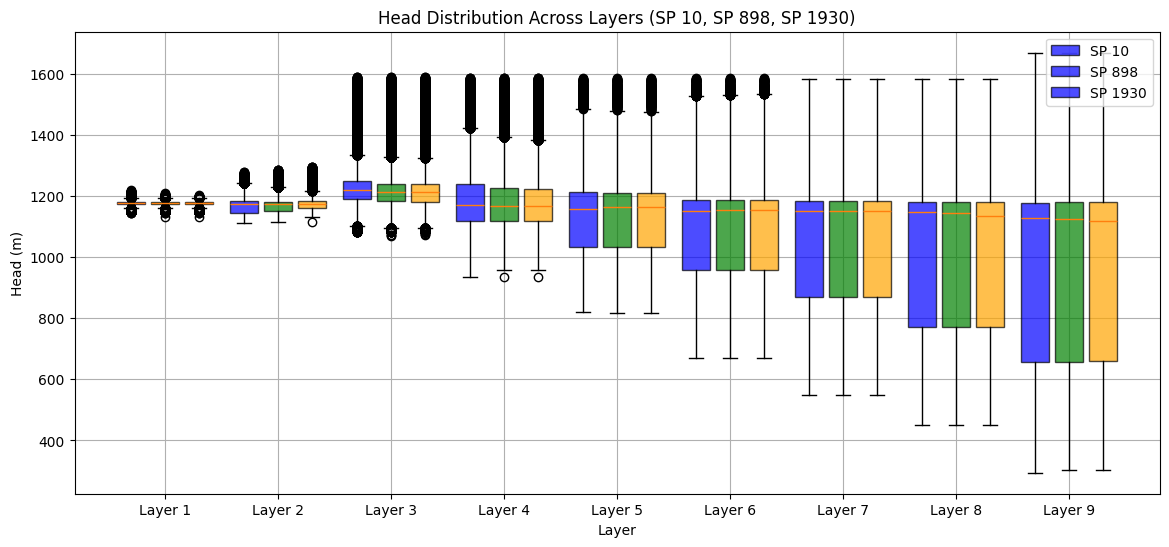

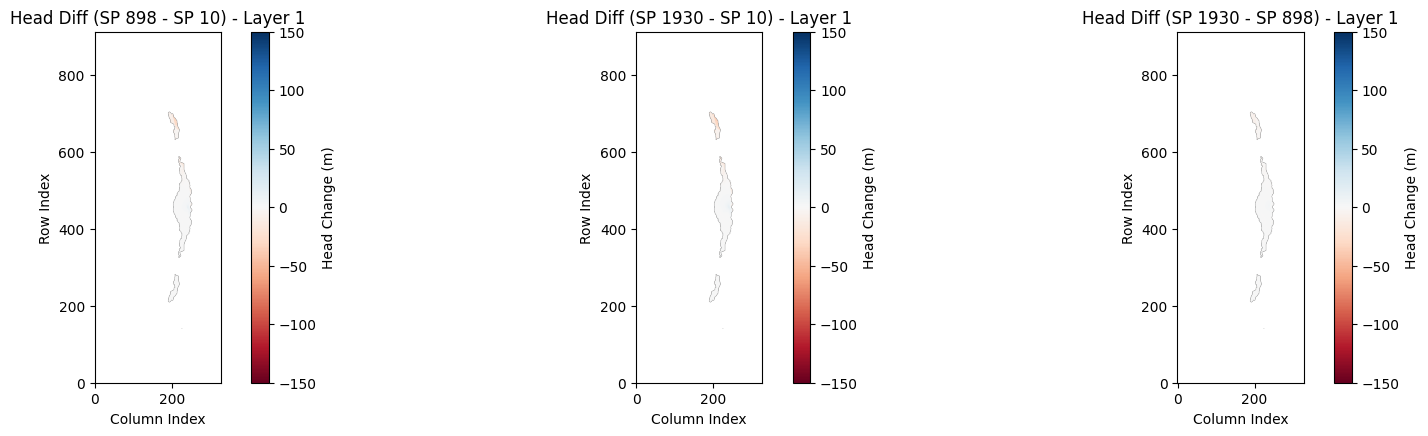

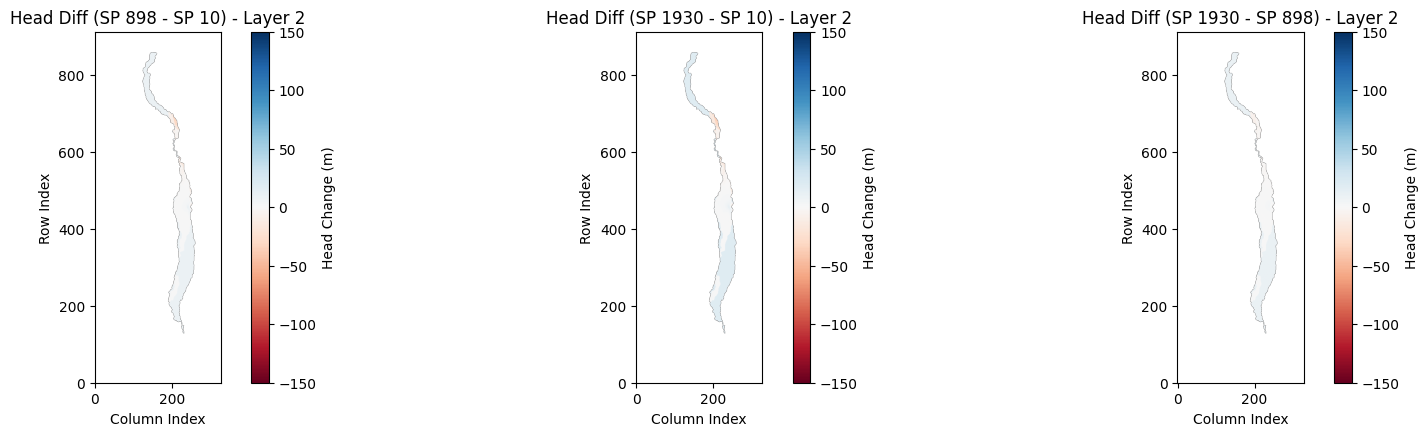

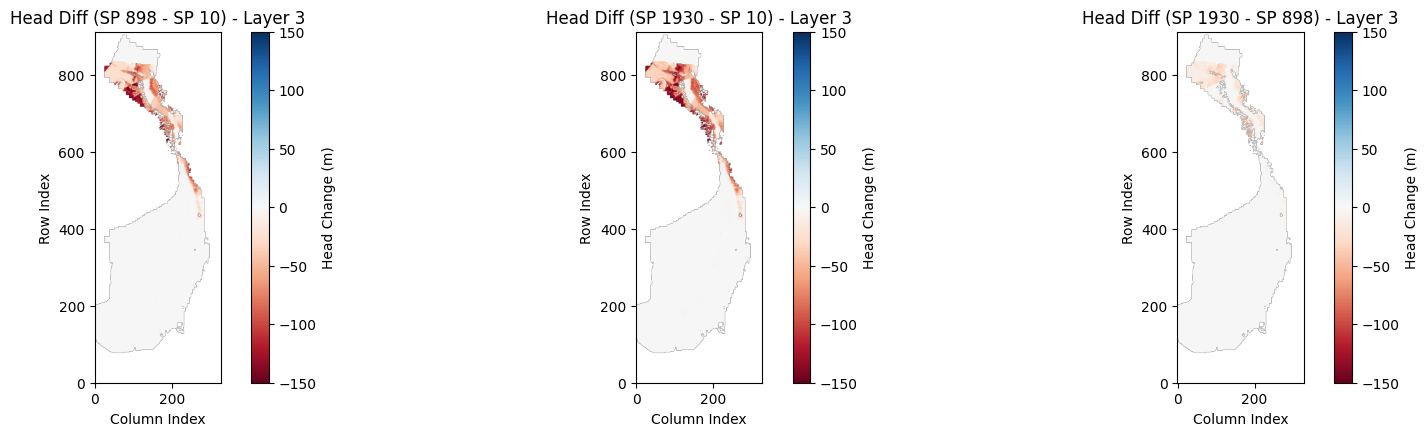

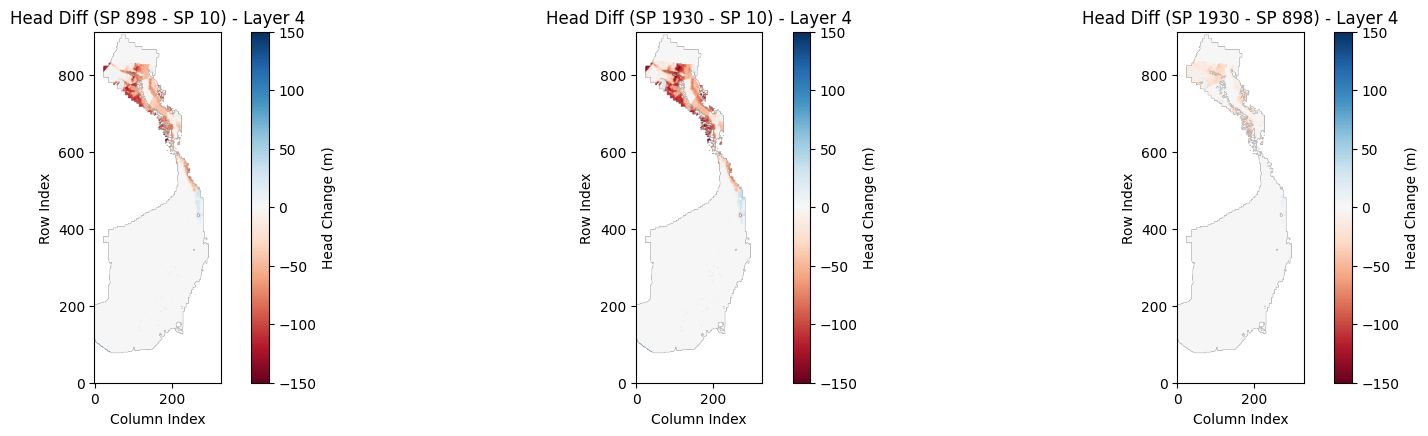

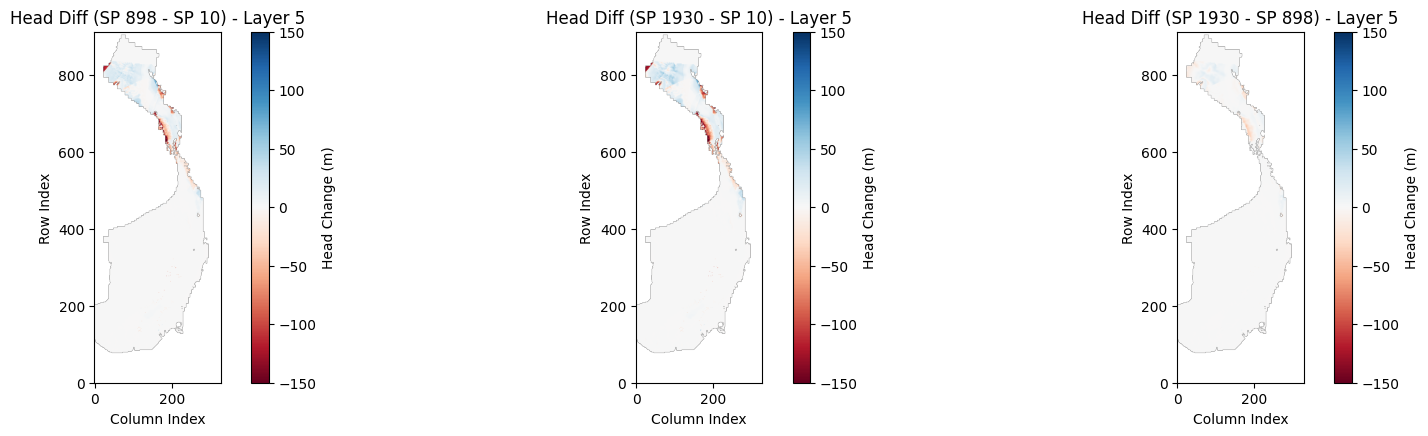

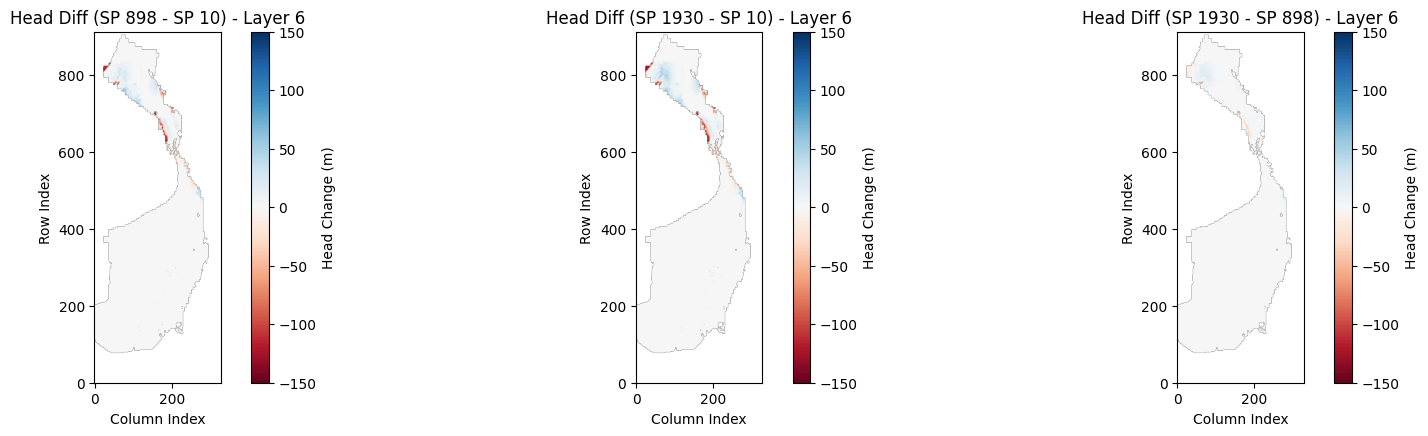

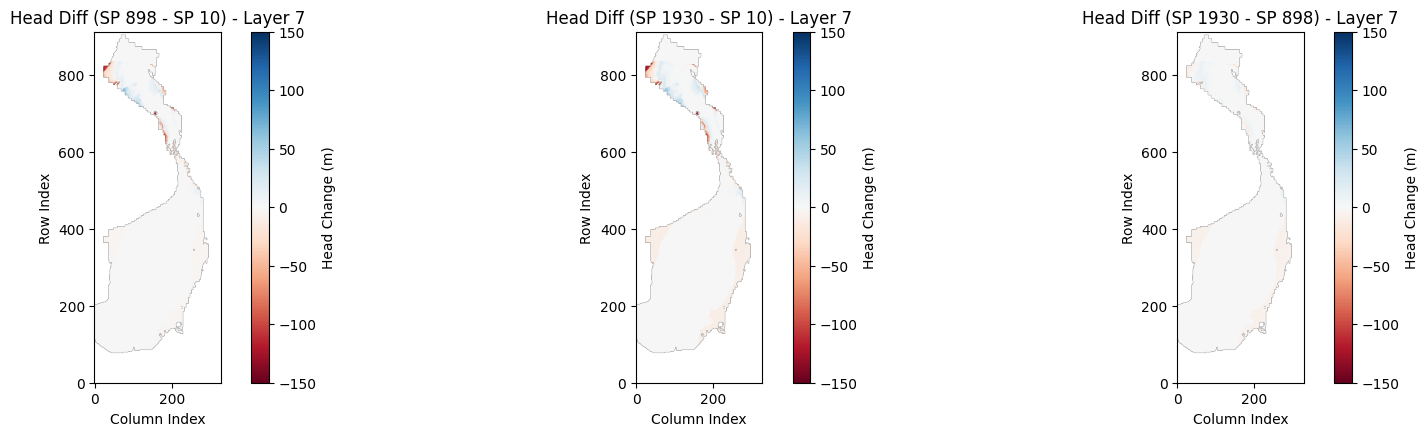

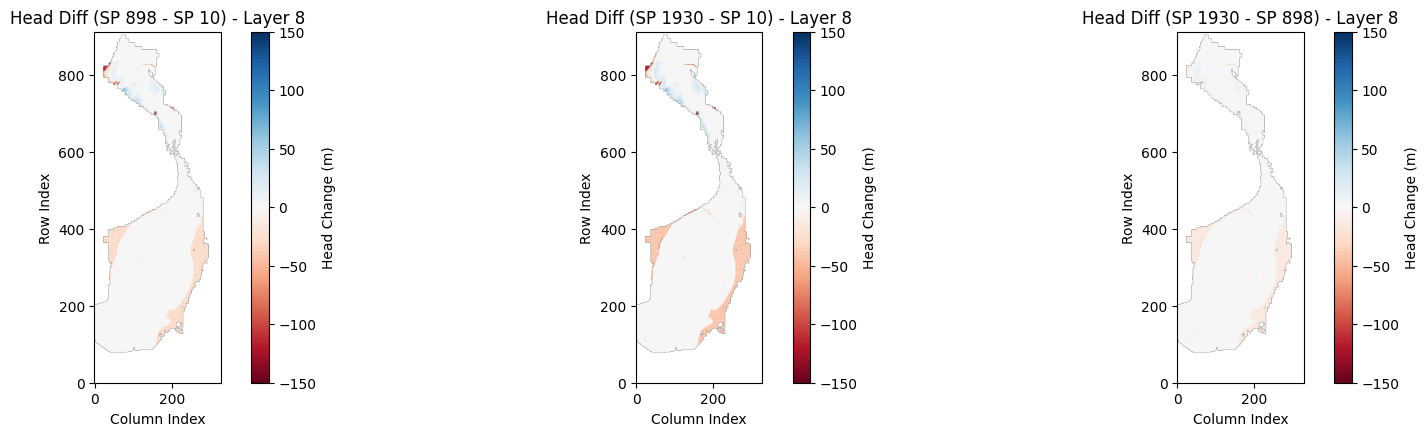

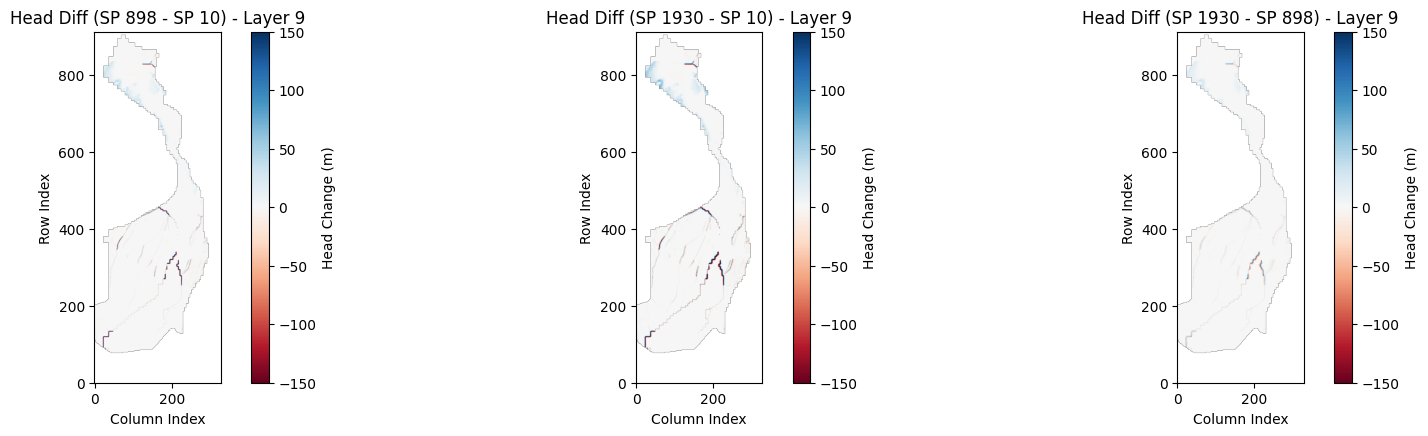

Layer  SP 10 Mean Head  SP 898 Mean Head  SP 1930 Mean Head  SP 898 - SP 10  \
0    L1          1177.05           1175.59            1175.12           -1.45   
1    L2          1171.25           1175.43            1180.78            4.18   
2    L3          1231.51           1223.22            1221.40           -8.30   
3    L4          1180.19           1174.23            1172.74           -5.96   
4    L5          1129.40           1129.36            1129.33           -0.05   
5    L6          1084.18           1084.18            1084.37            0.00   
6    L7          1041.75           1041.22            1040.69           -0.53   
7    L8           997.27            994.80             993.39           -2.47   
8    L9           943.65            944.45             944.94            0.81   

   SP 1930 - SP 10  SP 1930 - SP 898  
0            -1.92             -0.47  
1             9.53              5.35  
2           -10.11             -1.82  
3            -7.45             -1.49  
4            -0.07             -0.02  
5             0.20              0.19  
6            -1.07             -0.53  
7            -3.88             -1.41  
8             1.30              0.49


Table saved to plots/mean_head_table.csv


In [16]:
# %% [markdown]
# # MODFLOW Hydraulic Head Analysis
# 
# This notebook analyzes hydraulic head data from a MODFLOW model for Stress Periods (SP) 10, 898, and 1930. We assess differences between these stress periods and compute mean heads for layers 1-9, presenting the results in a table. Visualizations highlight spatial and statistical differences.
# 
# **Requirements**:
# - MODFLOW objects `gwf` and `headobj` must be defined.
# - Filtered head arrays (`head_filtered_sp10_m`, `head_filtered_sp898_m`, `head_filtered_sp1930_m`) must be available (in meters).
# - Python packages: `numpy`, `matplotlib`, `pandas`, `scipy`.

# %%
# Import libraries and set up plotting
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import pearsonr
import os
%matplotlib inline

# Flag to control file output
SAVE_FILES = True

# Create plots directory if needed
plots_dir = "plots"
if SAVE_FILES and not os.path.exists(plots_dir):
    os.makedirs(plots_dir)

# %% [markdown]
# ## Data Validation
# 
# Verify that required data is available and the model has at least 9 layers.

# %%
# Check for required data
try:
    gwf
    headobj
    head_filtered_sp10_m
    head_filtered_sp898_m
    head_filtered_sp1930_m
except NameError:
    raise NameError("Required objects (gwf, headobj) and head arrays must be defined.")

# Get grid dimensions
nlay = gwf.dis.nlay.get_data()
nrow = gwf.dis.nrow.get_data()
ncol = gwf.dis.ncol.get_data()
if nlay < 9:
    raise ValueError(f"Model has only {nlay} layers, need at least 9.")
if nrow <= 0 or ncol <= 0:
    raise ValueError(f"Invalid grid dimensions: nrow={nrow}, ncol={ncol}")

# Create coordinate arrays for plotting
x = np.arange(ncol)
y = np.arange(nrow)
X, Y = np.meshgrid(x, y)

# %% [markdown]
# ## Differences Between Stress Periods
# 
# We compute head change statistics for all pairwise comparisons (SP 898 - SP 10, SP 1930 - SP 10, SP 1930 - SP 898) to quantify differences in hydraulic heads.

# %%
# Head Change Statistics
print("Head Change Statistics (SP 898 - SP 10, in meters):")
for k in range(9):
    head_diff = head_filtered_sp898_m[k] - head_filtered_sp10_m[k]
    data = head_diff.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean Change: {np.mean(data):.2f}, Median Change: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        increased = np.sum(data > 0) / len(data) * 100
        decreased = np.sum(data < 0) / len(data) * 100
        print(f"        % Increased: {increased:.2f}%, % Decreased: {decreased:.2f}%")

print("\nHead Change Statistics (SP 1930 - SP 10, in meters):")
for k in range(9):
    head_diff = head_filtered_sp1930_m[k] - head_filtered_sp10_m[k]
    data = head_diff.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean Change: {np.mean(data):.2f}, Median Change: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        increased = np.sum(data > 0) / len(data) * 100
        decreased = np.sum(data < 0) / len(data) * 100
        print(f"        % Increased: {increased:.2f}%, % Decreased: {decreased:.2f}%")

print("\nHead Change Statistics (SP 1930 - SP 898, in meters):")
for k in range(9):
    head_diff = head_filtered_sp1930_m[k] - head_filtered_sp898_m[k]
    data = head_diff.flatten()
    data = data[~np.isnan(data)]
    if len(data) > 0:
        print(f"L{k+1}: Mean Change: {np.mean(data):.2f}, Median Change: {np.median(data):.2f}, Std: {np.std(data):.2f}")
        increased = np.sum(data > 0) / len(data) * 100
        decreased = np.sum(data < 0) / len(data) * 100
        print(f"        % Increased: {increased:.2f}%, % Decreased: {decreased:.2f}%")

# %% [markdown]
# ## Visualizing Differences
# 
# ### Box Plot of Head Distributions
# 
# Compare head distributions across layers for SP 10, SP 898, and SP 1930.

# %%
# Box Plot
fig = plt.figure(figsize=(14, 6))
head_sp10_list = [head_filtered_sp10_m[k].flatten()[~np.isnan(head_filtered_sp10_m[k].flatten())] for k in range(9)]
head_sp898_list = [head_filtered_sp898_m[k].flatten()[~np.isnan(head_filtered_sp898_m[k].flatten())] for k in range(9)]
head_sp1930_list = [head_filtered_sp1930_m[k].flatten()[~np.isnan(head_filtered_sp1930_m[k].flatten())] for k in range(9)]

plt.boxplot(head_sp10_list, positions=np.arange(1, 10)-0.3, widths=0.25, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.7))
plt.boxplot(head_sp898_list, positions=np.arange(1, 10), widths=0.25, patch_artist=True, boxprops=dict(facecolor='green', alpha=0.7))
plt.boxplot(head_sp1930_list, positions=np.arange(1, 10)+0.3, widths=0.25, patch_artist=True, boxprops=dict(facecolor='orange', alpha=0.7))

plt.title("Head Distribution Across Layers (SP 10, SP 898, SP 1930)")
plt.xlabel("Layer")
plt.ylabel("Head (m)")
plt.xticks(np.arange(1, 10), [f"Layer {k+1}" for k in range(9)])
plt.legend(['SP 10', 'SP 898', 'SP 1930'], loc='upper right')
plt.grid(True)
if SAVE_FILES:
    plt.savefig(os.path.join(plots_dir, "head_boxplot_all.png"))
plt.show()

# %% [markdown]
# ### Head Difference Heatmaps
# 
# Visualize spatial head differences for each layer.

# %%
# Head Difference Heatmaps
for k in range(9):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))
    
    # SP 898 - SP 10
    head_diff_898_10 = head_filtered_sp898_m[k] - head_filtered_sp10_m[k]
    im1 = ax1.imshow(head_diff_898_10, cmap="RdBu", vmin=-150, vmax=150, origin='lower')
    ax1.set_title(f"Head Diff (SP 898 - SP 10) - Layer {k+1}")
    ax1.set_xlabel("Column Index")
    ax1.set_ylabel("Row Index")
    plt.colorbar(im1, ax=ax1, label="Head Change (m)")
    
    # SP 1930 - SP 10
    head_diff_1930_10 = head_filtered_sp1930_m[k] - head_filtered_sp10_m[k]
    im2 = ax2.imshow(head_diff_1930_10, cmap="RdBu", vmin=-150, vmax=150, origin='lower')
    ax2.set_title(f"Head Diff (SP 1930 - SP 10) - Layer {k+1}")
    ax2.set_xlabel("Column Index")
    ax2.set_ylabel("Row Index")
    plt.colorbar(im2, ax=ax2, label="Head Change (m)")
    
    # SP 1930 - SP 898
    head_diff_1930_898 = head_filtered_sp1930_m[k] - head_filtered_sp898_m[k]
    im3 = ax3.imshow(head_diff_1930_898, cmap="RdBu", vmin=-150, vmax=150, origin='lower')
    ax3.set_title(f"Head Diff (SP 1930 - SP 898) - Layer {k+1}")
    ax3.set_xlabel("Column Index")
    ax3.set_ylabel("Row Index")
    plt.colorbar(im3, ax=ax3, label="Head Change (m)")
    
    plt.tight_layout(pad=3.0)
    if SAVE_FILES:
        plt.savefig(os.path.join(plots_dir, f"head_diff_layer{k+1}_all.png"))
    plt.show()

# %% [markdown]
# ## Mean Head Table
# 
# Compute mean heads for layers 1-9 for SP 10, SP 898, and SP 1930, and their differences.

# %%
# Calculate mean heads
mean_heads = {
    'Layer': [f"L{k+1}" for k in range(9)],
    'SP 10 Mean Head': [],
    'SP 898 Mean Head': [],
    'SP 1930 Mean Head': [],
    'SP 898 - SP 10': [],
    'SP 1930 - SP 10': [],
    'SP 1930 - SP 898': [],
}

for k in range(9):
    # SP 10
    data_sp10 = head_filtered_sp10_m[k].flatten()
    data_sp10 = data_sp10[~np.isnan(data_sp10)]
    mean_sp10 = np.mean(data_sp10) if len(data_sp10) > 0 else np.nan
    mean_heads['SP 10 Mean Head'].append(mean_sp10)
    
    # SP 898
    data_sp898 = head_filtered_sp898_m[k].flatten()
    data_sp898 = data_sp898[~np.isnan(data_sp898)]
    mean_sp898 = np.mean(data_sp898) if len(data_sp898) > 0 else np.nan
    mean_heads['SP 898 Mean Head'].append(mean_sp898)
    
    # SP 1930
    data_sp1930 = head_filtered_sp1930_m[k].flatten()
    data_sp1930 = data_sp1930[~np.isnan(data_sp1930)]
    mean_sp1930 = np.mean(data_sp1930) if len(data_sp1930) > 0 else np.nan
    mean_heads['SP 1930 Mean Head'].append(mean_sp1930)

# Calculate differences
mean_heads['SP 898 - SP 10'] = [mean_heads['SP 898 Mean Head'][k] - mean_heads['SP 10 Mean Head'][k] for k in range(9)]
mean_heads['SP 1930 - SP 10'] = [mean_heads['SP 1930 Mean Head'][k] - mean_heads['SP 10 Mean Head'][k] for k in range(9)]
mean_heads['SP 1930 - SP 898'] = [mean_heads['SP 1930 Mean Head'][k] - mean_heads['SP 898 Mean Head'][k] for k in range(9)]

# Create DataFrame
df_mean_heads = pd.DataFrame(mean_heads)
df_mean_heads = df_mean_heads.round(2)  # Round to 2 decimal places

# Display table
from IPython.display import display
display(df_mean_heads)

# Save to CSV
if SAVE_FILES:
    csv_file = os.path.join(plots_dir, "mean_head_table.csv")
    df_mean_heads.to_csv(csv_file, index=False)
    print(f"\nTable saved to {csv_file}")

# %% [markdown]
# ## Interpretation
# 
# - **Head Change Statistics**: Large mean changes or high percentages of increased/decreased heads indicate significant differences between stress periods.
# - **Box Plots**: Compare medians and spreads to see how head distributions vary across layers and stress periods.
# - **Difference Heatmaps**: Identify spatial patterns of head changes, with red indicating increases and blue indicating decreases.
# - **Mean Head Table**: Differences in mean heads (e.g., >5 meters) highlight significant changes in average groundwater levels.

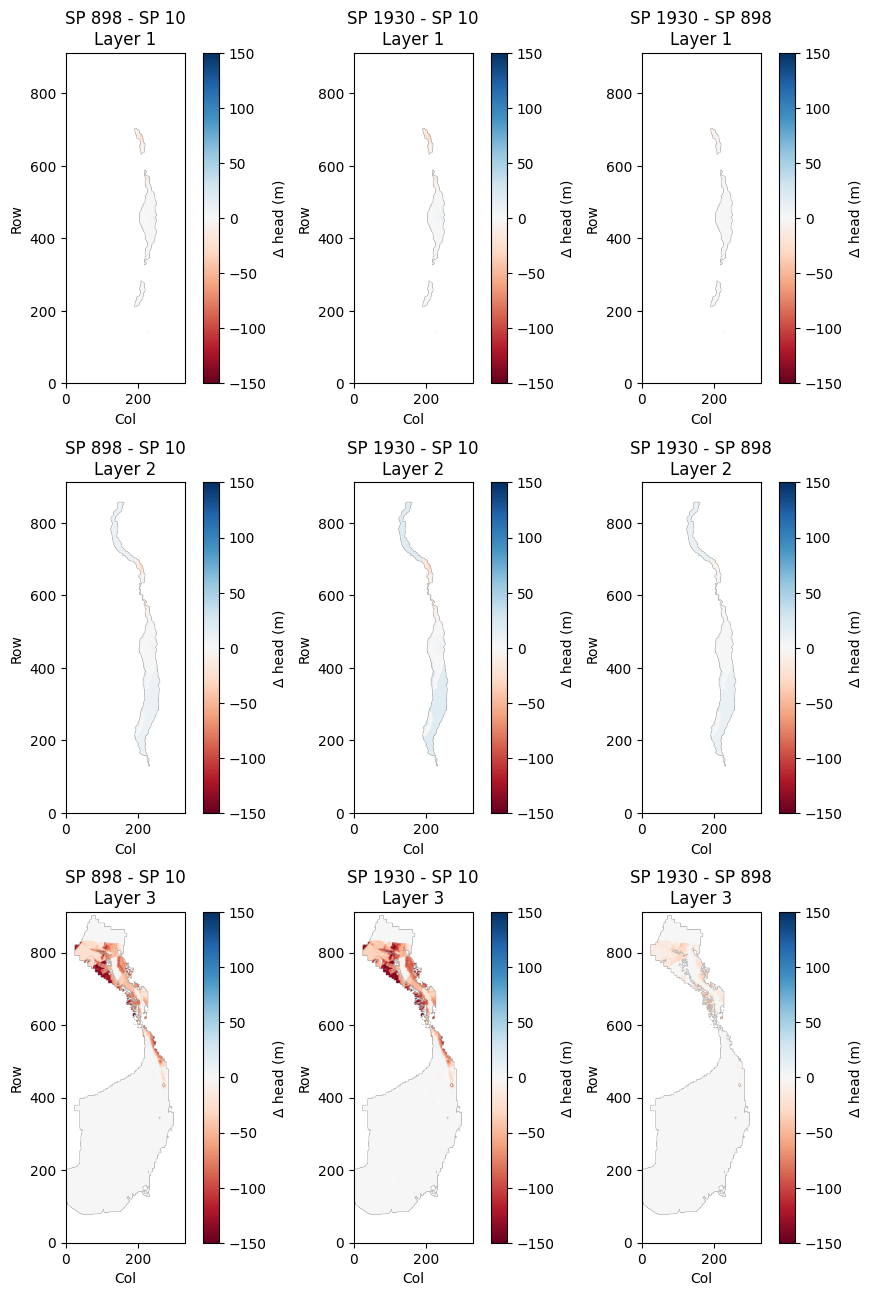

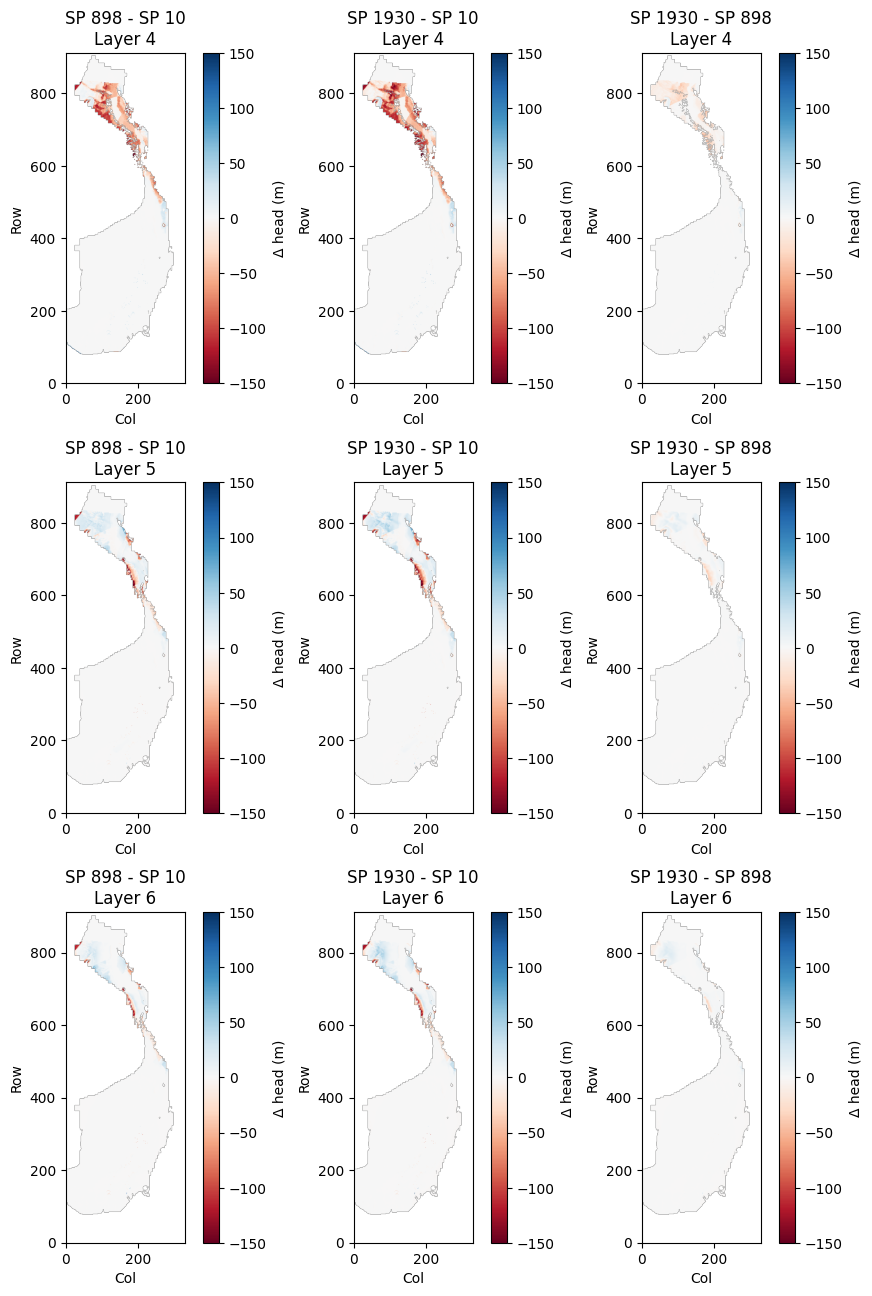

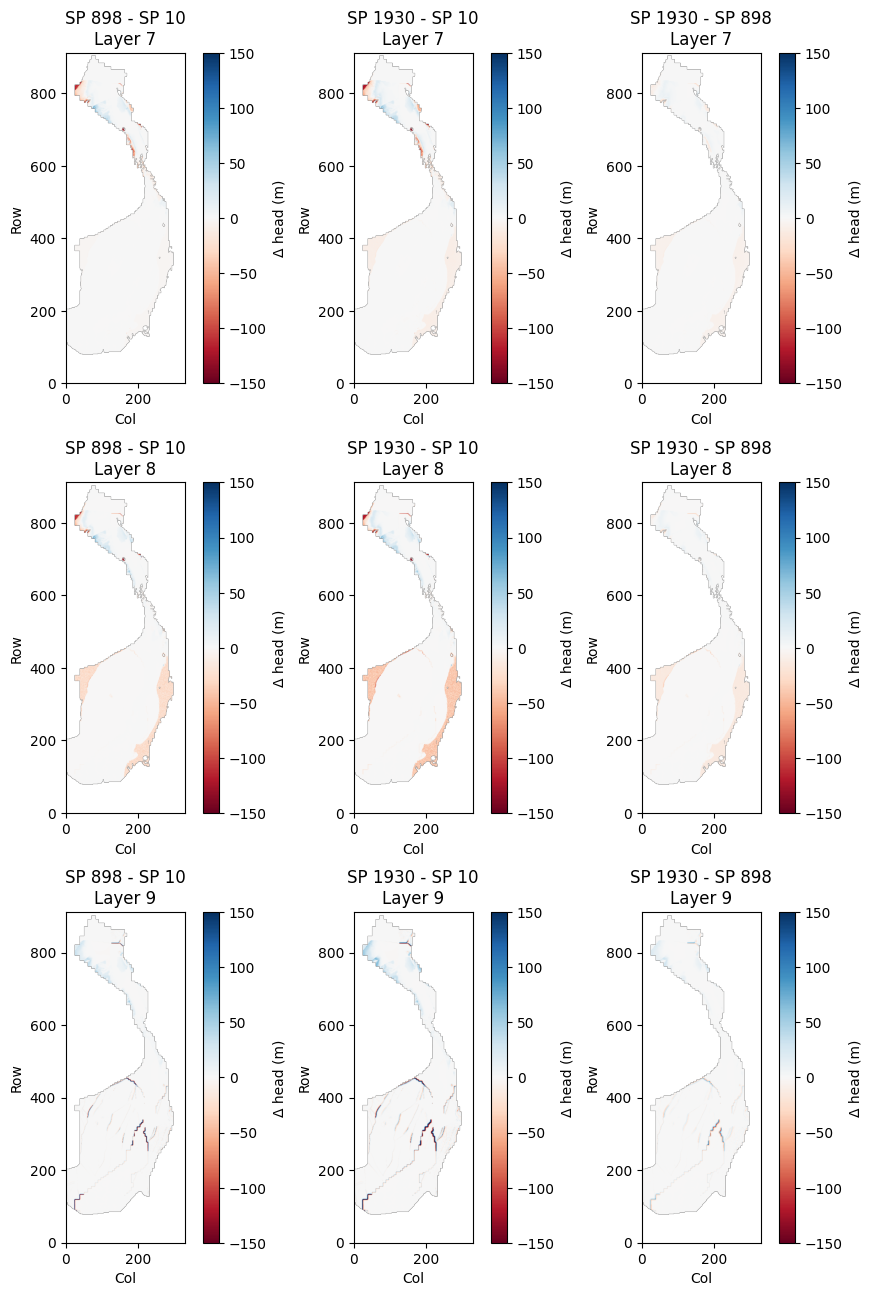

In [73]:
from matplotlib.gridspec import GridSpec

for fig_idx, start in enumerate(range(0, 9, 3), start=1):
    fig = plt.figure(figsize=(12, 14))
    # define a 3×3 grid with very small gaps
    gs = GridSpec(
        3, 3,
        figure=fig,
        left   = 0.02,
        right  = 0.8,
        top    = 0.9,
        bottom = 0.05,
        wspace = -0.2,
        hspace = 0.3
    )

    for i in range(3):
        layer = start + i
        for j, (label, arrA, arrB) in enumerate(comparisons):
            ax = fig.add_subplot(gs[i, j])
            diff = arrA[layer] - arrB[layer]
            im = ax.imshow(diff, cmap="RdBu", vmin=-150, vmax=150, origin="lower")
            ax.set_title(f"{label}\nLayer {layer+1}")
            ax.set_xlabel("Col")
            ax.set_ylabel("Row")
            fig.colorbar(im, ax=ax, label="Δ head (m)")

    if SAVE_FILES:
        fname = f"head_diff_layers{start+1}_{start+3}.png"
        fig.savefig(os.path.join(plots_dir, fname), dpi=150)
    plt.show()


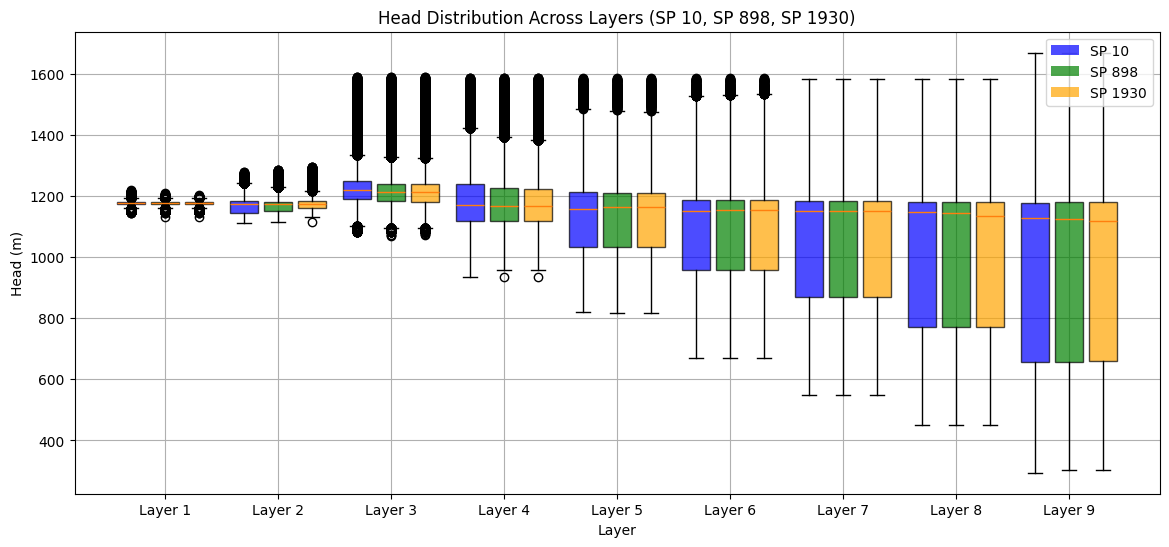

In [74]:
import matplotlib.patches as mpatches
# %%
# Box Plot
fig = plt.figure(figsize=(14, 6))
head_sp10_list = [head_filtered_sp10_m[k].flatten()[~np.isnan(head_filtered_sp10_m[k].flatten())] for k in range(9)]
head_sp898_list = [head_filtered_sp898_m[k].flatten()[~np.isnan(head_filtered_sp898_m[k].flatten())] for k in range(9)]
head_sp1930_list = [head_filtered_sp1930_m[k].flatten()[~np.isnan(head_filtered_sp1930_m[k].flatten())] for k in range(9)]

plt.boxplot(head_sp10_list, positions=np.arange(1, 10)-0.3, widths=0.25, patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.7))
plt.boxplot(head_sp898_list, positions=np.arange(1, 10), widths=0.25, patch_artist=True, boxprops=dict(facecolor='green', alpha=0.7))
plt.boxplot(head_sp1930_list, positions=np.arange(1, 10)+0.3, widths=0.25, patch_artist=True, boxprops=dict(facecolor='orange', alpha=0.7))
# after your three boxplots:
blue = mpatches.Patch(facecolor='blue',  alpha=0.7, label='SP 10')
grn  = mpatches.Patch(facecolor='green', alpha=0.7, label='SP 898')
org  = mpatches.Patch(facecolor='orange',alpha=0.7, label='SP 1930')

plt.title("Head Distribution Across Layers (SP 10, SP 898, SP 1930)")
plt.xlabel("Layer")
plt.ylabel("Head (m)")
plt.xticks(np.arange(1, 10), [f"Layer {k+1}" for k in range(9)])
# plt.legend(['SP 10', 'SP 898', 'SP 1930'], loc='upper right')
plt.legend(handles=[blue, grn, org], loc='upper right')
plt.grid(True)
if SAVE_FILES:
    plt.savefig(os.path.join(plots_dir, "head_boxplot_all.png"))
plt.show()



## UZF package results

In [11]:
# Path to UZF budget file (binary)
uzf_file = os.path.join(model_ws, './rgtihm_2100.uzf.bud')

# Read UZF budget file
uzfbud = flopy.utils.CellBudgetFile(uzf_file, precision='double')
uzf_times = uzfbud.get_times()
print(f"UZF budget has {len(uzf_times)} time steps.")

UZF budget has 3860 time steps.


In [12]:
# Grid dimensions from the model
nlay = gwf.dis.nlay.get_data()
nrow = gwf.dis.nrow.get_data()
ncol = gwf.dis.ncol.get_data()
delr = gwf.dis.delr.get_data()
delc = gwf.dis.delc.get_data()
idomain = gwf.dis.idomain.get_data()
modelgrid = gwf.modelgrid

# Shape of the 3D grid
shape = (nlay, nrow, ncol)

# Convert structured array from .uzf.bud to 3D array
def uzf_structured_to_3darray(data, shape, idomain=None):
    arr = np.full(shape, np.nan)
    for entry in data:
        node = entry['node'] - 1  # Convert from 1-based to 0-based
        k = node // (nrow * ncol)
        rem = node % (nrow * ncol)
        i = rem // ncol
        j = rem % ncol
        if idomain is None or idomain[k, i, j] != 0:
            arr[k, i, j] = entry['q']
    return arr

# UZF budget time steps
uzf_times = uzfbud.get_times()
sp10_time = uzf_times[9]
sp898_time = uzf_times[897]

# Budget components to extract
records = ['INFILTRATION', 'REJ-INF', 'STORAGE', 'GWF']

# Dictionaries to hold data
uzf_sp10_dict = {}
uzf_sp898_dict = {}

# Load each component
for rec in records:
    data10 = uzfbud.get_data(text=rec, totim=sp10_time)[0]
    data898 = uzfbud.get_data(text=rec, totim=sp898_time)[0]

    uzf_sp10_dict[rec] = uzf_structured_to_3darray(data10, shape, idomain) * 304.8  # ft/d to mm/day
    uzf_sp898_dict[rec] = uzf_structured_to_3darray(data898, shape, idomain) * 304.8

print("loaded UZF budget components for SP10 and SP898 (mm/day, structured grid)")

loaded UZF budget components for SP10 and SP898 (mm/day, structured grid)


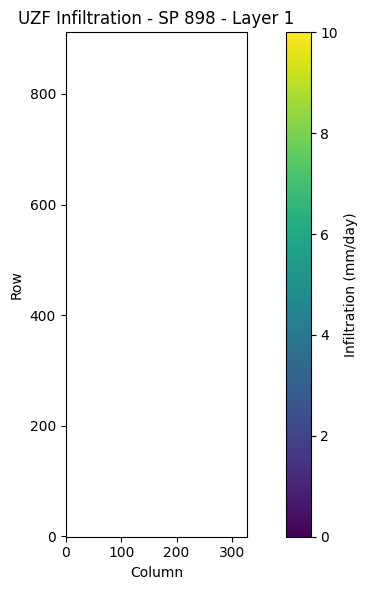

In [13]:
fig, ax = plt.subplots(figsize=(8, 6))
im = ax.imshow(uzf_sp898_dict['INFILTRATION'][0], cmap='viridis', origin='lower', vmin=0, vmax=10)
ax.set_title("UZF Infiltration - SP 898 - Layer 1")
ax.set_xlabel("Column")
ax.set_ylabel("Row")
plt.colorbar(im, ax=ax, label="Infiltration (mm/day)")
plt.tight_layout()
plt.savefig(os.path.join(plots_dir, "uzf_infiltration_sp898_L1.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()



In [14]:
for label, data, sp in [
    ("UZF Infiltration SP 10", uzf_sp10_mm, "10"),
    ("UZF Infiltration SP 898", uzf_sp898_mm, "898")
]:
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(1, 1, 1)
    im = ax.imshow(data[0], cmap="viridis", origin="lower", vmin=0, vmax=10)
    ax.set_title(label)
    ax.set_xlabel("Column Index")
    ax.set_ylabel("Row Index")
    plt.colorbar(im, ax=ax, label="Infiltration (mm/day)")
    plt.tight_layout(pad=3.0)
    plt.savefig(os.path.join(plots_dir, f"uzf_infiltration_layer1_sp{sp}.png"))
    if DISPLAY_PLOTS:
        plt.show()
    plt.close()


NameError: name 'uzf_sp10_mm' is not defined

In [ ]:
row, col = 729, 116
uzf_series = []
for t in uzf_times:
    arr = to_3d_array(uzfbud.get_data(text='INFLOW', totim=t)[0], shape)
    uzf_series.append(arr[0, row, col] * 304.8 if idomain[0, row, col] == 1 else np.nan)

fig = plt.figure(figsize=(10, 5))
plt.plot(uzf_times, uzf_series, label="UZF Infiltration", color="teal")
plt.title(f"UZF Infiltration at (Row {row}, Col {col}) - Layer 1")
plt.xlabel("Time (Stress Period)")
plt.ylabel("Infiltration (mm/day)")
plt.grid(True)
plt.tight_layout(pad=3.0)
plt.savefig(os.path.join(plots_dir, f"uzf_timeseries_r{row}_c{col}.png"))
if DISPLAY_PLOTS:
    plt.show()
plt.close()
